# Model training

## Load Python packages

In [1]:
#import tensorflow as tf
import numpy as np
#from tensorflow import keras
#from tensorflow.keras import layers
from scipy import stats
import session_info
#import tensorflow_probability as tfp
import pdb
from sklearn.metrics import r2_score
import shutil
import pandas as pd
import re
import os
from Bio.Seq import Seq
import gc
import matplotlib.pyplot as plt
import datetime
import socket
import time
import json
from collections import OrderedDict
import random as python_random

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.nn.parameter import Parameter
import math
import pickle as pk
import sys

## Parameters

In [3]:
RUNTIME = 'none'
ARGS = {
  'model_id' : 'm20220727e',
  'global_seed' : 123,
  'shuffle_size' : 1000,
  'max_width' : 100,
  'head_len' : 17,
  'tail_len' : 13,
  'pct_ds' : 1, # % of total data for training/testing,
  'train_split' : 0.95,
  'alphabets' : {'A' : 0, 'C' : 1, 'G' : 2, 'T' : 3, 'N' : 4, 'M' : 5},
  'initial_lr' : 1e-15,
  'max_lr' : 3e-4,
  'initial_epoch': 0,
  'epochs' : 20,
  'batch_size' : 512,
  'dropout_rate' : 0.1,
  'kmer': 10,
  'strides' : 1,
  'embedding_dim' : 512,
  'num_heads' : 8,
  'ff_mult' : 4,
  'num_projectors' : 32,
  'n_blocks_regressor' : 4,
  'warmup_steps' : 12500, # ~ 1 epoch
  'mask_ratio' : 0.05,
  'remote_sample_submission_file' : 'https://raw.githubusercontent.com/de-Boer-Lab/DREAM-2022/main/sample_submission.json',
  'eval' : False,
  'device':'cuda:2'
}
if RUNTIME == 'msi':
  ARGS['remote_data_dir'] = 'https://s3.msi.umn.edu/gongx030/projects/dream_PGE/training_data/pct_ds=' + str(ARGS['pct_ds']) + '/'
  ARGS['local_data_dir'] = re.sub('https://', './', ARGS['remote_data_dir'])
  ARGS['remote_checkpoint_dir'] = 'https://s3.msi.umn.edu/gongx030/projects/dream_PGE/notebooks_msi/' + ARGS['model_id'] + '/tf_ckpts/'
  ARGS['remote_log_dir'] = 'https://s3.msi.umn.edu/gongx030/projects/dream_PGE/notebooks_msi/' + ARGS['model_id'] + '/log/'
  ARGS['local_checkpoint_dir'] = re.sub('https://', './', ARGS['remote_checkpoint_dir'])
  ARGS['local_log_dir'] = re.sub('https://', './', ARGS['remote_log_dir'])
  ARGS['remote_test_data'] = 'https://s3.msi.umn.edu/gongx030/projects/dream_PGE/test_sequences.txt.gz'
  ARGS['local_test_data'] = re.sub('https://', './', ARGS['remote_test_data'])
  ARGS['local_sample_submission_file'] = re.sub('https://', './', ARGS['remote_sample_submission_file'])
  ARGS['remote_prediction_file'] = 'https://s3.msi.umn.edu/gongx030/projects/dream_PGE/predictions/' + ARGS['model_id'] + '/pred.json'
  ARGS['local_prediction_file'] = re.sub('https://', './', ARGS['remote_prediction_file'])
  ARGS['s3_prediction_file'] = re.sub('https://s3.msi.umn.edu', 's3://', ARGS['remote_prediction_file'])
  ARGS['remote_prediction_tsv_file'] = 'https://s3.msi.umn.edu/gongx030/projects/dream_PGE/predictions/' + ARGS['model_id'] + '/pred.tsv'
  ARGS['local_prediction_tsv_file'] = re.sub('https://', './', ARGS['remote_prediction_tsv_file'])
  ARGS['s3_prediction_tsv_file'] = re.sub('https://s3.msi.umn.edu', 's3://', ARGS['remote_prediction_tsv_file'])
else:
  ARGS['local_data_dir'] = '/content/drive/MyDrive/training_data/pct_ds=' + str(ARGS['pct_ds']) + '/'
  ARGS['local_checkpoint_dir'] = '/content/drive/MyDrive/' + ARGS['model_id'] + '/tf_ckpts/'
  ARGS['local_log_dir'] = '/content/drive/MyDrive/' + ARGS['model_id'] + '/log/'

In [4]:
ARGS['local_data_dir'] = '/Data1/PGE/torch_ti/data/'

In [5]:
with open(ARGS['local_data_dir']+"data.pk","rb") as fr:
    data = pk.load(fr)

### Set seeds

In [6]:
np.random.seed(ARGS['global_seed'])

torch.manual_seed(ARGS['global_seed'])

python_random.seed(ARGS['global_seed'])

### pearson_r

In [7]:
def pearson_r(x, y):
    x = torch.tensor(x,dtype=torch.float32)
    y = torch.tensor(y,dtype=torch.float32)
    mx = torch.mean(x, axis = 0, keepdims = True)
    my = torch.mean(y, axis = 0, keepdims = True)
    xm = x - mx
    ym = y - my
    t1_norm = F.normalize(xm, p=2, dim=0)
    t2_norm = F.normalize(ym, p=2, dim=0)
    return torch.sum(torch.mul(t1_norm, t2_norm))

In [8]:
x = np.random.rand(100)
y = np.random.rand(100)
print('pearson r (stats.pearsonr): {}'.format(stats.pearsonr(x, y)[0]))
print('pearson r (pearson_r): {}'.format(pearson_r(torch.unsqueeze(torch.Tensor(x),1), torch.unsqueeze(torch.Tensor(y),1))))

pearson r (stats.pearsonr): -0.09270195576139686
pearson r (pearson_r): -0.09270194172859192


/tmp/ipykernel_3901/3244679858.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x,dtype=torch.float32)
/tmp/ipykernel_3901/3244679858.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y,dtype=torch.float32)


### GLULayer

In [9]:
class GLULayer(nn.Module):
    def __init__(self, dim):
        super(GLULayer, self).__init__()
        self.dim = dim
        self.sig = nn.Sigmoid()

    def forward(self, x):
        out,gate = torch.chunk(x, 2, dim = self.dim)
        return out * self.sig(gate)

In [10]:
layer = GLULayer(dim = 1)
x = torch.randn(3,6,10)
layer(x).shape

torch.Size([3, 3, 10])

### SwiGLU

In [11]:

class SwiGLULayer(nn.Module):
    def __init__(self, dim):
        super(SwiGLULayer, self).__init__()
        self.dim = dim
        self.swish = nn.SiLU() # same as swish

    def forward(self, x):
        out, gate = torch.chunk(x, 2, dim = self.dim)
        return out * self.swish(gate)

In [12]:
layer = SwiGLULayer(dim = 1)
x = torch.randn(3,6,10)
layer(x).shape

torch.Size([3, 3, 10])

### FeedForwardSwiGLU

In [13]:

class FeedForwardSwiGLU(nn.Module):
    def __init__(self, embedding_dim, mult=4, rate = 0.0, use_bias = False):
        super(FeedForwardSwiGLU, self).__init__()
        swiglu_out = int(embedding_dim * mult/2)
        self.layernorm = nn.LayerNorm(embedding_dim,eps = 1e-6)
        self.linear1 = nn.Linear(embedding_dim,embedding_dim * mult, bias = use_bias)
        self.swiglulayer = SwiGLULayer(dim = 1)
        self.drop = nn.Dropout(rate)
        self.linear2 = nn.Linear(swiglu_out,embedding_dim, bias = use_bias)

    def forward(self, inputs):
        x = self.layernorm(inputs.transpose(1,2)) 
        x = self.linear1(x) 
        x = self.swiglulayer(x.transpose(1,2)) 
        x = self.drop(x)
        x = self.linear2(x.transpose(1,2)) 
        out = self.drop(x.transpose(1,2)) 
        return out

In [14]:
ffn = FeedForwardSwiGLU(embedding_dim = 5, mult = 4)
x = torch.randn(3,5,10)
print(ffn(x).shape)

torch.Size([3, 5, 10])


### CustomSchedule

In [15]:
n_train = 6400689
model = FeedForwardSwiGLU(embedding_dim = 5, mult = 4)
optim           = torch.optim.Adam(model.parameters(), lr = ARGS['initial_lr'], betas=(0.9, 0.98), eps=1e-08)
scheduler       = torch.optim.lr_scheduler.OneCycleLR(optim, max_lr=ARGS['max_lr'],pct_start = 0.05, 
                                                                   steps_per_epoch=int(n_train/ARGS['batch_size'])+1, epochs=ARGS['epochs'],anneal_strategy='cos')


/opt/conda/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Text(0.5, 1.0, 'OneCycleLR Scheduler')

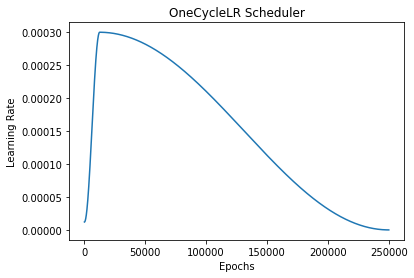

In [16]:
lrs  = []
for  i  in  range(250000):
	scheduler.step()
	lrs.append(optim.param_groups[0]["lr"])  

plt.plot(lrs)
plt.xlabel("Epochs")
plt.ylabel("Learning Rate")
plt.title("OneCycleLR Scheduler")

### ConformerSASwiGLULayer

In [17]:


class ConformerSASwiGLULayer(nn.Module):
    def __init__(self, embedding_dim,  ff_mult = 4, kernel_size = 15, rate = 0.2, num_heads = 4, use_bias = False):
        super(ConformerSASwiGLULayer, self).__init__()
        self.ff1 = FeedForwardSwiGLU(embedding_dim = embedding_dim, mult = ff_mult, rate = rate, use_bias = use_bias)
        self.layernorm1 = nn.LayerNorm(embedding_dim,eps = 1e-6)
        self.conv = nn.Sequential(   
          nn.Conv1d(in_channels=embedding_dim, out_channels=embedding_dim, kernel_size=kernel_size, groups=embedding_dim, padding='same'),
          nn.Conv1d(in_channels=embedding_dim, out_channels=embedding_dim, kernel_size=1, padding='same'),
          nn.ReLU(),
          nn.Dropout(rate),
        )
        self.layernorm2 = nn.LayerNorm(embedding_dim,eps = 1e-6)    
        self.attn = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=num_heads,batch_first=True)
        self.ff2 = FeedForwardSwiGLU(embedding_dim = embedding_dim, mult = ff_mult, rate = rate, use_bias = use_bias)

    def forward(self, x):
        x = x.float()
        x = x + 0.5 * self.ff1(x)
        x = self.layernorm1(x.transpose(1,2))
        x = x + self.conv(x.transpose(1, 2)).transpose(1, 2) 
        x = self.layernorm2(x)
        x = x + self.attn(x, x, x)[0]
        x = x.transpose(1,2) + 0.5 * self.ff2(x.transpose(1,2))
        return x

In [18]:
layer = ConformerSASwiGLULayer(embedding_dim = 16)
x = torch.randn(3,16,10)
print(layer(x).shape)

torch.Size([3, 16, 10])


### SequenceMaskLayer

In [19]:
class SequenceMaskLayer(nn.Module):
    def __init__(self, n_positions, ratio = 0.2):
        super(SequenceMaskLayer, self).__init__()
        self.ratio = ratio
        self.n_positions = n_positions
        self.N = 4
        self.M = 5

    def forward(self, x):

        if self.ratio > 0:
            m = torch.rand(x.shape) < self.ratio
            m = m*1
            is_valid = x == self.N
            is_valid = is_valid * 1
            m = m * is_valid
            x0 = torch.ones(x.shape) * self.M

            x = m * x0 + (1 - m) * x
            m = m.float()
        else:
            m = torch.zeros(x.shape)
    
        return x, m

In [20]:
layer = SequenceMaskLayer(n_positions = 20, ratio = 0.2)
x = torch.rand([3,20])*5
x = torch.floor(x)
x, m = layer(x)
print(x)
print(m)

tensor([[2., 0., 0., 0., 4., 4., 1., 0., 4., 1., 0., 2., 1., 1., 0., 4., 2., 0.,
         0., 3.],
        [0., 2., 2., 3., 3., 0., 1., 3., 1., 3., 4., 2., 1., 5., 5., 1., 1., 0.,
         2., 3.],
        [2., 1., 1., 1., 3., 1., 0., 1., 4., 3., 3., 2., 3., 4., 0., 4., 2., 1.,
         0., 2.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])


## Read data

In [21]:
input_dim = int(6) # A,C,G,T,N,M
#input_dim = int(5) # A,C,G,T,N
n_positions = ARGS['max_width'] * 2

In [22]:
n = int(len(data['seq']))
n_train = int(n * ARGS['train_split'])
print('downsampled dataset size: %d' % (n))
print('training dataset size: %d' % (n_train))

downsampled dataset size: 6737568
training dataset size: 6400689


In [23]:
train_data = {'seq':data['seq'][:n_train],'expression':data['expression'][:n_train]}
val_data = {'seq':data['seq'][n_train:],'expression':data['expression'][n_train:]}
#train_data = {'seq':data['seq'][:10000],'expression':data['expression'][:10000]}
#val_data = {'seq':data['seq'][10000:15000],'expression':data['expression'][10000:15000]}

print('# training samples: %d' % (len(train_data['seq'])))
print('# val samples: %d' % (len(val_data['seq'])))

# training samples: 6400689
# val samples: 336879


# DataLoader & TestSet Preprocessing

In [24]:
class train_loader(object):
    def __init__(self, data):
        self.data = data['seq']
        self.data_label = data['expression']

    def __getitem__(self, index):

        return torch.FloatTensor(self.data[index]), self.data_label[index] 
    
    def __len__(self):
        return len(self.data)

class test_loader(object):
    def __init__(self,args):
        lines = open("/Data1/PGE/torch_ti/filtered_test_data_with_MAUDE_expression.txt", "r").read().splitlines()
        data = [x.split('\t')[0] for x in lines]
        data_label = [x.split('\t')[1] for x in lines]
        df = pd.DataFrame()
        df['dna'] = data
        df['expression'] = data_label
        df['dna'] = df['dna'].astype('string')
        df['len'] = df['dna'].str.len()
        print('number of unique sequences in the first {} positions: {}'.format(args['head_len'], len(df['dna'].str[:args['head_len']].unique())))
        print('number of unique sequences in the last {} positions: {}'.format(args['tail_len'], len(df['dna'].str[-args['tail_len']:].unique())))
        df['dna'] = df['dna'].str[args['head_len']:]
        df['dna'] = df['dna'].str[:-args['tail_len']]
        df['len'] = df['dna'].str.len()
        assert all(df['len'] <= args['max_width'])
        
        df['dna'] = df['dna'].str.pad(width = args['max_width'], side = 'both', fillchar = 'N')
        df['dna'] = df['dna'] + df['dna'].apply(lambda x: str(Seq(x).reverse_complement())).astype('string')
        
        input_dim = int(6) # A,C,G,T,N,M
        n_positions = int(args['max_width'] * 2)
        self.dna = np.empty((0, n_positions), np.uint8)
        for x in np.array_split(df['dna'], 10): # split data into chunks
            y = np.array(x.apply(list))
            y = np.vstack(y)
            y = np.vectorize(ARGS['alphabets'].get)(y)
            y = y.astype(np.uint8)
            print(y.shape)
            self.dna = np.append(self.dna, y, axis = 0)
        print(self.dna.shape)
        self.expression = df['expression'].astype('float32').to_numpy()
#        print(expression[:5])
        expression_std = np.std(self.expression)
        expression_mean = np.mean(self.expression)
        self.expression = (self.expression - expression_mean) / expression_std
        
        print(self.expression.shape)
        
        
    def __getitem__(self, index):

        return torch.FloatTensor(self.dna[index]), self.expression[index] 
    
    def __len__(self):
        return len(self.dna)

## The regressor

In [26]:
class Regressor(nn.Module):
    def __init__(self, n_positions, kmer = 3, embedding_dim = 32, input_dim = 5, n_blocks = 4, 
               kernel_size =15, rate = 0.2, strides = 2, ratio = 0.2, num_heads = 4, ff_mult = 4, 
               use_bias = False, num_projectors = 8):
        super(Regressor, self).__init__()
        self.n_positions = int(n_positions / strides)
        self.input_dim = input_dim
        self.kmer = kmer
        self.strides = strides
        self.num_projectors = num_projectors
        self.n_blocks = n_blocks
        self.masking = SequenceMaskLayer(n_positions = n_positions, ratio = ratio)
        self.pos_embedding = nn.Embedding(self.n_positions, embedding_dim)
        self.strand_embedding = nn.Embedding(2, embedding_dim) # plus/minus strands
        self.expression_embedding = nn.Linear(1,embedding_dim)
        self.kmer_dense = nn.Linear(input_dim*self.kmer,embedding_dim)
        self.blocks = nn.ModuleList([ConformerSASwiGLULayer(embedding_dim = embedding_dim,
                                    kernel_size = kernel_size, rate = rate, num_heads = num_heads) for _ in range(n_blocks)])
        self.dropout = nn.Dropout(rate)
        self.expression_dense = nn.Linear(embedding_dim,1)
        self.nucleotide_dense = nn.Linear(embedding_dim,input_dim)

    def forward(self, x): # x = data['seq']

        batch_size = x.shape[0]

        x = F.one_hot(x.to(torch.int64), self.input_dim)   # b,seq,em

        x = x.unsqueeze(2)  # b,seq,1,em

     #   x = tf.image.extract_patches(x, sizes = [1, self.kmer, 1, 1], strides = [1, self.strides, 1, 1], 
     #                                rates = [1, 1, 1, 1], padding = 'SAME')

        #print(x.shape)
        x_shape = x.shape
        fold_shape = x.unfold(1,self.kmer,self.strides).transpose(3,4).shape
        div = x_shape[1] - fold_shape[1]
        x = F.pad(x.unfold(1,self.kmer,self.strides).transpose(3,4),(0,0,0,0,0,0,0,div),'constant',0).reshape(x.shape[0],x.shape[1]//self.strides,x.shape[2],-1)
        x = x.squeeze(2).float()
    #    print(x.shape)
    #    print(x.dtype)
        x = self.kmer_dense(x)

        pos = torch.arange(start=0, end = self.n_positions, step=1).cuda()
        pos = pos.unsqueeze(0)
        pos = self.pos_embedding(pos.long())

        strand = torch.tensor(np.repeat([0,1], repeats = int(self.n_positions / 2))).cuda()
        strand = strand.unsqueeze(0)
        strand = self.strand_embedding(strand.long())

        x = x + pos + strand  # 채널 dim=2

        expression = torch.zeros((batch_size, self.num_projectors, 1)).cuda()
        expression = self.expression_embedding(expression.float())

        x = torch.cat([expression, x], dim = 1)
        x = x.transpose(1,2)
        for i in range(self.n_blocks) :
            x = self.blocks[i](x)
        #x = self.blocks(x.transpose(1,2)).transpose(1,2)
        x = x.transpose(1,2)
    #    print('x : ',x.shape)
        expression = x[:,:self.num_projectors,:]
        x = x[:, -self.n_positions:, :]
    #    print('exp : ',expression.shape)
    #    print('x : ',x.shape)

        expression = self.dropout(expression)
        expression = self.expression_dense(expression)
        expression = torch.mean(expression, 1)

        x = self.nucleotide_dense(x)

        return expression, x.transpose(1,2)

In [27]:
from tqdm import tqdm

class RegressorModel(nn.Module):
	def __init__(self, args,**kwargs): # lr, lr_decay, C , n_class, m, s, test_step, **kwargs):
		super(RegressorModel, self).__init__()
		## regressor
		self.regressor = Regressor(n_positions = n_positions,embedding_dim = args['embedding_dim'],
                             n_blocks = args['n_blocks_regressor'],kmer = args['kmer'],input_dim = input_dim,
                             strides = args['strides'],ratio = args['mask_ratio'],num_heads = args['num_heads'],
                             rate = args['dropout_rate'],num_projectors = args['num_projectors']).cuda()
		## Classifier
		self.mse_loss = nn.MSELoss(reduction='none').cuda()
		self.scc_loss = nn.CrossEntropyLoss( reduction='none').cuda()
		self.optim           = torch.optim.Adam(self.regressor.parameters(), lr = args['initial_lr'], betas=(0.9, 0.98), eps=1e-08)
		self.scheduler       = torch.optim.lr_scheduler.OneCycleLR(self.optim, max_lr=args['max_lr'],pct_start = 0.05, 
                                                                   steps_per_epoch=int(n_train/args['batch_size'])+1, epochs=args['epochs'],anneal_strategy='cos')
		print(time.strftime("%m-%d %H:%M:%S") + " Model para number(백만) = %.2f"%(sum(param.numel() for param in self.regressor.parameters()) / 1024 / 1024))

	def train_network(self, epoch, loader):
		self.train()
		## Update the learning rate based on the current epcoh
		if epoch > 0 :
			self.scheduler.step((epoch - 1)*int(n_train/args['batch_size']))
			print('LR : ',self.scheduler.get_last_lr()[0])
		index, loss = 0, 0
		for num, (data, labels) in tqdm(enumerate(loader, start = 1)):

			self.zero_grad()
			seq, mask = self.regressor.masking(data)
			labels = labels.cuda()
			expression, seq_pred = self.regressor.forward(data.cuda()) 
#			print(expression.dtype,seq_pred.dtype)
			loss_expression = self.mse_loss(labels.to(torch.float32), expression.squeeze(1).to(torch.float32))
			loss_seq = mask.cuda() * self.scc_loss(seq_pred,data.long().cuda())
			loss_seq = torch.sum(loss_seq) / (torch.sum(mask.cuda()) + 1)
			#print('seq_pred : ',seq_pred.shape,'data : ',data.shape)
			#print('loss_expression : ',loss_expression.to(torch.float32).dtype,'loss_seq : ',loss_seq.dtype)
#			print(loss_expression.shape,loss_seq.shape)
#			loss_expression = loss_expression.to(torch.float32)
			nloss = (loss_expression.to(torch.float32) + loss_seq.to(torch.float32)).mean().to(torch.float32)
#			print(nloss.dtype)
			
			nloss.backward()
			self.optim.step()
			self.scheduler.step()
			lr = self.scheduler.get_last_lr()[0]
			index += len(labels)
			loss += nloss.detach().cpu().numpy()
			if num % 200 == 0 :
				sys.stderr.write(time.strftime("%m-%d %H:%M:%S") + \
				" [%2d] Lr: %5f, Training: %.2f%%, "    %(epoch, lr, 100 * (num / loader.__len__())) + \
				" Loss: %.5f \r"        %(loss/(num)))
				sys.stderr.flush()
				sys.stdout.write("\n")

		return loss/num, lr 

	def eval_network(self, loader):
		self.eval()
		exp = []
		real_exp = []
		for idx, (data,labels) in tqdm(enumerate(loader)):
			# Full utterance
			data_1 = torch.FloatTensor(data).cuda()
			# Speaker embeddings
			with torch.no_grad():
				expression, _ = self.regressor.forward(data_1)
			if len(expression.shape) > 1 :
				expression = expression.reshape(-1)
				expression = expression.detach().cpu().numpy()
				labels = labels.detach().cpu().numpy() 
			exp.append(expression)
			real_exp.append(labels)
			
		# Coumpute Metric
		exp = np.array(exp).reshape(-1)
		real_exp = np.array(real_exp).reshape(-1)
		PR = pearson_r(exp, real_exp)

		return PR

	def save_parameters(self, path):
		torch.save(self.state_dict(), path)

	def load_parameters(self, path):
		self_state = self.state_dict()
		loaded_state = torch.load(path)
		for name, param in loaded_state.items():
			origname = name
			if name not in self_state:
				name = name.replace("module.", "")
				if name not in self_state:
					print("%s is not in the model."%origname)
					continue
			if self_state[name].size() != loaded_state[origname].size():
				print("Wrong parameter length: %s, model: %s, loaded: %s"%(origname, self_state[name].size(), loaded_state[origname].size()))
				continue
			self_state[name].copy_(param)

## Model fitting

### Epoch 1 

initial epoch: 1

In [28]:
torch.cuda.empty_cache()
import gc
gc.collect()
import argparse, glob, os, torch, warnings, time


model_save_path = "exps/model_reproducing"
score_save_path = "exps/score_reproducing.txt"
os.makedirs(model_save_path,exist_ok = True)

device = ARGS['device']
torch.cuda.set_device(device)
print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())


## Define the data loader
trainloader = train_loader(train_data)
trainLoader = torch.utils.data.DataLoader(trainloader, batch_size = ARGS['batch_size'], shuffle = True, num_workers = 0, drop_last = True)
valloader = train_loader(val_data)
valLoader = torch.utils.data.DataLoader(valloader, batch_size = ARGS['batch_size'], shuffle = True, num_workers = 0, drop_last = True)
testloader = test_loader(ARGS)
testLoader = torch.utils.data.DataLoader(testloader, batch_size = ARGS['batch_size'], shuffle = True, num_workers = 0, drop_last = True)

## Search for the exist models
modelfiles = glob.glob('%s/model_0*.model'%model_save_path)
modelfiles.sort()

## Otherwise, system will try to start from the saved model&epoch
if len(modelfiles) >= 1:
	print("Model %s loaded from previous state!"%modelfiles[-1])
	epoch = int(os.path.splitext(os.path.basename(modelfiles[-1]))[0][6:]) + 1
	s = RegressorModel(ARGS)
	s.load_parameters(modelfiles[-1])
	eval_pr_ = s.eval_network(testLoader)
	print('Previous Eval Pearson_R : ',eval_pr_)
## Otherwise, system will train from scratch
else:
	epoch = 1
	s = RegressorModel(ARGS)

pr = []
eval_pr = []
score_file = open(score_save_path, "a+")

while(1):
	## Training for one epoch
	loss, lr = s.train_network(epoch = epoch, loader = trainLoader)

	## Evaluation every [test_step] epochs
	if epoch % 1 == 0:
		s.save_parameters(model_save_path + "/model_%04d.model"%epoch)
		pr.append(s.eval_network(valLoader))
		print(time.strftime("%Y-%m-%d %H:%M:%S"), "%d epoch, Pearson_R %2.2f%%, bestPearson_R %2.2f%%"%(epoch, pr[-1], max(pr)))
		score_file.write("%d epoch, LR %f, LOSS %f, Pearson_R %2.2f%%, bestPearson_R %2.2f%%\n"%(epoch, lr, loss, pr[-1], max(pr)))
		score_file.flush()
		if pr[-1] == max(pr) :
			s.save_parameters(model_save_path + "/model_best.model")
			eval_pr.append(s.eval_network(testLoader))
			print(time.strftime("%Y-%m-%d %H:%M:%S"), "%d epoch, Eval_Pearson_R %2.2f%%, Best_Eval_Pearson_R %2.2f%%"%(epoch, eval_pr[-1], max(eval_pr)))
			score_file.write("%d epoch, LR %f, LOSS %f, Pearson_R %2.2f%%, Best_Eval_Pearson_R %2.2f%%\n"%(epoch, lr, loss, eval_pr[-1], max(eval_pr)))
			score_file.flush()

	if epoch >= ARGS['epochs']:
		quit()

	epoch += 1


Device: cuda:2
Current cuda device: 2
number of unique sequences in the first 17 positions: 1
number of unique sequences in the last 13 positions: 1
(7111, 200)
(7111, 200)
(7111, 200)
(7110, 200)
(7110, 200)
(7110, 200)
(7110, 200)
(7110, 200)
(7110, 200)
(7110, 200)
(71103, 200)
(71103,)
03-07 06:56:28 Model para number(백만) = 17.19
LR :  1.200000000000002e-05


200it [06:18,  1.90s/it]03-07 07:02:46 [ 1] Lr: 0.000012, Training: 1.60%,  Loss: 1.08267 

400it [12:37,  1.90s/it]03-07 07:09:06 [ 1] Lr: 0.000013, Training: 3.20%,  Loss: 0.98839 

600it [18:57,  1.90s/it]03-07 07:15:25 [ 1] Lr: 0.000014, Training: 4.80%,  Loss: 0.95340 

800it [25:16,  1.92s/it]03-07 07:21:45 [ 1] Lr: 0.000015, Training: 6.40%,  Loss: 0.93176 

1000it [31:36,  1.90s/it]3-07 07:28:04 [ 1] Lr: 0.000017, Training: 8.00%,  Loss: 0.91744 

1200it [37:55,  1.90s/it]03-07 07:34:23 [ 1] Lr: 0.000018, Training: 9.60%,  Loss: 0.90441 

1400it [44:15,  1.90s/it]03-07 07:40:43 [ 1] Lr: 0.000021, Training: 11.20%,  Loss: 0.89319 

1600it [50:34,  1.90s/it]03-07 07:47:02 [ 1] Lr: 0.000023, Training: 12.80%,  Loss: 0.88415 

1800it [56:53,  1.90s/it]03-07 07:53:22 [ 1] Lr: 0.000026, Training: 14.40%,  Loss: 0.87535 

2000it [1:03:13,  1.90s/it]03-07 07:59:41 [ 1] Lr: 0.000030, Training: 16.00%,  Loss: 0.86618 

2200it [1:09:32,  1.90s/it]03-07 08:06:01 [ 1] Lr: 0.000033, Training: 17.60%,  Loss: 0.85583 

2400it [1:15:52,  1.90s/it]03-07 08:12:21 [ 1] Lr: 0.000037, Training: 19.20%,  Loss: 0.84526 

2600it [1:22:12,  1.90s/it]03-07 08:18:40 [ 1] Lr: 0.000042, Training: 20.80%,  Loss: 0.83336 

2800it [1:28:31,  1.89s/it]03-07 08:24:59 [ 1] Lr: 0.000046, Training: 22.40%,  Loss: 0.82211 

3000it [1:34:50,  1.89s/it]03-07 08:31:18 [ 1] Lr: 0.000051, Training: 24.00%,  Loss: 0.81164 

3200it [1:41:08,  1.89s/it]03-07 08:37:37 [ 1] Lr: 0.000056, Training: 25.60%,  Loss: 0.80222 

3400it [1:47:27,  1.89s/it]03-07 08:43:55 [ 1] Lr: 0.000061, Training: 27.20%,  Loss: 0.79315 

3600it [1:53:46,  1.89s/it]03-07 08:50:14 [ 1] Lr: 0.000067, Training: 28.80%,  Loss: 0.78492 

3800it [2:00:04,  1.89s/it]03-07 08:56:32 [ 1] Lr: 0.000073, Training: 30.40%,  Loss: 0.77712 

4000it [2:06:22,  1.89s/it]03-07 09:02:51 [ 1] Lr: 0.000079, Training: 32.00%,  Loss: 0.76991 

4200it [2:12:41,  1.89s/it]03-07 09:09:09 [ 1] Lr: 0.000085, Training: 33.60%,  Loss: 0.76331 

4400it [2:18:59,  1.89s/it]03-07 09:15:27 [ 1] Lr: 0.000091, Training: 35.20%,  Loss: 0.75672 

4600it [2:25:17,  1.89s/it]03-07 09:21:46 [ 1] Lr: 0.000098, Training: 36.80%,  Loss: 0.75095 

4800it [2:31:36,  1.89s/it]03-07 09:28:04 [ 1] Lr: 0.000105, Training: 38.40%,  Loss: 0.74525 

5000it [2:37:54,  1.89s/it]03-07 09:34:22 [ 1] Lr: 0.000111, Training: 40.00%,  Loss: 0.73987 

5200it [2:44:13,  1.89s/it]03-07 09:40:41 [ 1] Lr: 0.000118, Training: 41.60%,  Loss: 0.73546 

5400it [2:50:31,  1.90s/it]03-07 09:46:59 [ 1] Lr: 0.000125, Training: 43.20%,  Loss: 0.73077 

5600it [2:56:50,  1.90s/it]03-07 09:53:18 [ 1] Lr: 0.000133, Training: 44.80%,  Loss: 0.72613 

5800it [3:03:08,  1.90s/it]03-07 09:59:37 [ 1] Lr: 0.000140, Training: 46.40%,  Loss: 0.72153 

6000it [3:09:28,  1.90s/it]03-07 10:05:57 [ 1] Lr: 0.000147, Training: 48.00%,  Loss: 0.71760 

6200it [3:15:48,  1.90s/it]03-07 10:12:17 [ 1] Lr: 0.000154, Training: 49.60%,  Loss: 0.71373 

6400it [3:22:08,  1.90s/it]03-07 10:18:36 [ 1] Lr: 0.000161, Training: 51.20%,  Loss: 0.70985 

6600it [3:28:27,  1.90s/it]03-07 10:24:56 [ 1] Lr: 0.000169, Training: 52.80%,  Loss: 0.70616 

6800it [3:34:47,  1.90s/it]03-07 10:31:16 [ 1] Lr: 0.000176, Training: 54.40%,  Loss: 0.70304 

7000it [3:41:07,  1.90s/it]03-07 10:37:35 [ 1] Lr: 0.000183, Training: 56.00%,  Loss: 0.69952 

7200it [3:47:26,  1.90s/it]03-07 10:43:55 [ 1] Lr: 0.000190, Training: 57.60%,  Loss: 0.69619 

7400it [3:53:46,  1.90s/it]03-07 10:50:14 [ 1] Lr: 0.000197, Training: 59.20%,  Loss: 0.69300 

7600it [4:00:06,  1.90s/it]03-07 10:56:34 [ 1] Lr: 0.000204, Training: 60.80%,  Loss: 0.68994 

7800it [4:06:26,  1.90s/it]03-07 11:02:54 [ 1] Lr: 0.000211, Training: 62.40%,  Loss: 0.68692 

8000it [4:12:45,  1.90s/it]03-07 11:09:14 [ 1] Lr: 0.000217, Training: 63.99%,  Loss: 0.68391 

8200it [4:19:05,  1.90s/it]03-07 11:15:33 [ 1] Lr: 0.000224, Training: 65.59%,  Loss: 0.68111 

8400it [4:25:25,  1.90s/it]03-07 11:21:53 [ 1] Lr: 0.000230, Training: 67.19%,  Loss: 0.67830 

8600it [4:31:44,  1.90s/it]03-07 11:28:13 [ 1] Lr: 0.000236, Training: 68.79%,  Loss: 0.67553 

8800it [4:38:04,  1.90s/it]03-07 11:34:32 [ 1] Lr: 0.000242, Training: 70.39%,  Loss: 0.67266 

9000it [4:44:24,  1.90s/it]03-07 11:40:52 [ 1] Lr: 0.000248, Training: 71.99%,  Loss: 0.66990 

9200it [4:50:43,  1.90s/it]03-07 11:47:12 [ 1] Lr: 0.000253, Training: 73.59%,  Loss: 0.66742 

9400it [4:57:03,  1.90s/it]03-07 11:53:32 [ 1] Lr: 0.000258, Training: 75.19%,  Loss: 0.66486 

9600it [5:03:23,  1.90s/it]03-07 11:59:51 [ 1] Lr: 0.000263, Training: 76.79%,  Loss: 0.66234 

9800it [5:09:43,  1.90s/it]03-07 12:06:11 [ 1] Lr: 0.000268, Training: 78.39%,  Loss: 0.65990 

10000it [5:16:02,  1.90s/it]3-07 12:12:31 [ 1] Lr: 0.000272, Training: 79.99%,  Loss: 0.65744 

10200it [5:22:22,  1.91s/it]03-07 12:18:51 [ 1] Lr: 0.000277, Training: 81.59%,  Loss: 0.65494 

10400it [5:28:44,  1.91s/it]03-07 12:25:12 [ 1] Lr: 0.000280, Training: 83.19%,  Loss: 0.65240 

10600it [5:35:04,  1.90s/it]03-07 12:31:32 [ 1] Lr: 0.000284, Training: 84.79%,  Loss: 0.64984 

10800it [5:41:25,  1.90s/it]03-07 12:37:54 [ 1] Lr: 0.000287, Training: 86.39%,  Loss: 0.64744 

11000it [5:47:46,  1.90s/it]03-07 12:44:14 [ 1] Lr: 0.000290, Training: 87.99%,  Loss: 0.64516 

11200it [5:54:05,  1.90s/it]03-07 12:50:34 [ 1] Lr: 0.000292, Training: 89.59%,  Loss: 0.64273 

11400it [6:00:25,  1.90s/it]03-07 12:56:54 [ 1] Lr: 0.000295, Training: 91.19%,  Loss: 0.64043 

11600it [6:06:45,  1.90s/it]03-07 13:03:14 [ 1] Lr: 0.000296, Training: 92.79%,  Loss: 0.63823 

11800it [6:13:05,  1.90s/it]03-07 13:09:33 [ 1] Lr: 0.000298, Training: 94.39%,  Loss: 0.63595 

12000it [6:19:25,  1.90s/it]03-07 13:15:53 [ 1] Lr: 0.000299, Training: 95.99%,  Loss: 0.63373 

12200it [6:25:45,  1.90s/it]03-07 13:22:13 [ 1] Lr: 0.000300, Training: 97.59%,  Loss: 0.63152 

12400it [6:32:04,  1.90s/it]03-07 13:28:33 [ 1] Lr: 0.000300, Training: 99.19%,  Loss: 0.62927 

12501it [6:35:17,  1.90s/it]
657it [06:35,  1.66it/s]


2023-03-07 13:38:21 1 epoch, Pearson_R 0.71%, bestPearson_R 0.71%


138it [01:22,  1.66it/s]


2023-03-07 13:39:44 1 epoch, Eval_Pearson_R 0.91%, Best_Eval_Pearson_R 0.91%
LR :  0.0003


200it [06:20,  1.91s/it]03-07 13:46:04 [ 2] Lr: 0.000300, Training: 1.60%,  Loss: 0.49173 

400it [12:40,  1.90s/it]03-07 13:52:24 [ 2] Lr: 0.000300, Training: 3.20%,  Loss: 0.49301 

600it [19:00,  1.90s/it]03-07 13:58:44 [ 2] Lr: 0.000300, Training: 4.80%,  Loss: 0.49097 

800it [25:21,  1.90s/it]03-07 14:05:05 [ 2] Lr: 0.000300, Training: 6.40%,  Loss: 0.48960 

1000it [31:42,  1.90s/it]3-07 14:11:26 [ 2] Lr: 0.000300, Training: 8.00%,  Loss: 0.48852 

1200it [38:02,  1.90s/it]03-07 14:17:46 [ 2] Lr: 0.000300, Training: 9.60%,  Loss: 0.48798 

1400it [44:22,  1.90s/it]03-07 14:24:06 [ 2] Lr: 0.000300, Training: 11.20%,  Loss: 0.48845 

1600it [50:41,  1.90s/it]03-07 14:30:25 [ 2] Lr: 0.000300, Training: 12.80%,  Loss: 0.48671 

1800it [57:00,  1.89s/it]03-07 14:36:45 [ 2] Lr: 0.000300, Training: 14.40%,  Loss: 0.48607 

2000it [1:03:19,  1.89s/it]03-07 14:43:03 [ 2] Lr: 0.000300, Training: 16.00%,  Loss: 0.48533 

2200it [1:09:38,  1.89s/it]03-07 14:49:22 [ 2] Lr: 0.000300, Training: 17.60%,  Loss: 0.48476 

2400it [1:15:56,  1.89s/it]03-07 14:55:41 [ 2] Lr: 0.000300, Training: 19.20%,  Loss: 0.48414 

2600it [1:22:15,  1.89s/it]03-07 15:01:59 [ 2] Lr: 0.000300, Training: 20.80%,  Loss: 0.48412 

2800it [1:28:34,  1.89s/it]03-07 15:08:18 [ 2] Lr: 0.000300, Training: 22.40%,  Loss: 0.48393 

3000it [1:34:52,  1.89s/it]03-07 15:14:37 [ 2] Lr: 0.000300, Training: 24.00%,  Loss: 0.48317 

3200it [1:41:11,  1.89s/it]03-07 15:20:55 [ 2] Lr: 0.000300, Training: 25.60%,  Loss: 0.48295 

3400it [1:47:29,  1.88s/it]03-07 15:27:13 [ 2] Lr: 0.000300, Training: 27.20%,  Loss: 0.48243 

3600it [1:53:48,  1.90s/it]03-07 15:33:33 [ 2] Lr: 0.000300, Training: 28.80%,  Loss: 0.48212 

3800it [2:00:08,  1.90s/it]03-07 15:39:52 [ 2] Lr: 0.000300, Training: 30.40%,  Loss: 0.48145 

4000it [2:06:28,  1.90s/it]03-07 15:46:12 [ 2] Lr: 0.000300, Training: 32.00%,  Loss: 0.48109 

4200it [2:12:48,  1.90s/it]03-07 15:52:32 [ 2] Lr: 0.000300, Training: 33.60%,  Loss: 0.48057 

4400it [2:19:08,  1.90s/it]03-07 15:58:52 [ 2] Lr: 0.000300, Training: 35.20%,  Loss: 0.48005 

4600it [2:25:28,  1.90s/it]03-07 16:05:12 [ 2] Lr: 0.000300, Training: 36.80%,  Loss: 0.47940 

4800it [2:31:48,  1.90s/it]03-07 16:11:32 [ 2] Lr: 0.000300, Training: 38.40%,  Loss: 0.47908 

5000it [2:38:07,  1.90s/it]03-07 16:17:52 [ 2] Lr: 0.000300, Training: 40.00%,  Loss: 0.47878 

5200it [2:44:27,  1.90s/it]03-07 16:24:11 [ 2] Lr: 0.000300, Training: 41.60%,  Loss: 0.47837 

5400it [2:50:47,  1.90s/it]03-07 16:30:31 [ 2] Lr: 0.000300, Training: 43.20%,  Loss: 0.47826 

5600it [2:57:07,  1.89s/it]03-07 16:36:51 [ 2] Lr: 0.000300, Training: 44.80%,  Loss: 0.47797 

5800it [3:03:26,  1.90s/it]03-07 16:43:10 [ 2] Lr: 0.000300, Training: 46.40%,  Loss: 0.47779 

6000it [3:09:45,  1.90s/it]03-07 16:49:29 [ 2] Lr: 0.000300, Training: 48.00%,  Loss: 0.47752 

6200it [3:16:04,  1.90s/it]03-07 16:55:49 [ 2] Lr: 0.000299, Training: 49.60%,  Loss: 0.47729 

6400it [3:22:24,  1.90s/it]03-07 17:02:08 [ 2] Lr: 0.000299, Training: 51.20%,  Loss: 0.47689 

6600it [3:28:43,  1.90s/it]03-07 17:08:28 [ 2] Lr: 0.000299, Training: 52.80%,  Loss: 0.47690 

6800it [3:35:03,  1.90s/it]03-07 17:14:47 [ 2] Lr: 0.000299, Training: 54.40%,  Loss: 0.47668 

7000it [3:41:22,  1.90s/it]03-07 17:21:06 [ 2] Lr: 0.000299, Training: 56.00%,  Loss: 0.47632 

7200it [3:47:42,  1.90s/it]03-07 17:27:27 [ 2] Lr: 0.000299, Training: 57.60%,  Loss: 0.47601 

7400it [3:54:03,  1.90s/it]03-07 17:33:47 [ 2] Lr: 0.000299, Training: 59.20%,  Loss: 0.47562 

7600it [4:00:22,  1.90s/it]03-07 17:40:07 [ 2] Lr: 0.000299, Training: 60.80%,  Loss: 0.47541 

7800it [4:06:42,  1.90s/it]03-07 17:46:26 [ 2] Lr: 0.000299, Training: 62.40%,  Loss: 0.47514 

8000it [4:13:02,  1.90s/it]03-07 17:52:46 [ 2] Lr: 0.000299, Training: 63.99%,  Loss: 0.47488 

8200it [4:19:22,  1.90s/it]03-07 17:59:06 [ 2] Lr: 0.000299, Training: 65.59%,  Loss: 0.47468 

8400it [4:25:42,  1.90s/it]03-07 18:05:26 [ 2] Lr: 0.000299, Training: 67.19%,  Loss: 0.47424 

8600it [4:32:01,  1.90s/it]03-07 18:11:45 [ 2] Lr: 0.000299, Training: 68.79%,  Loss: 0.47385 

8800it [4:38:21,  1.90s/it]03-07 18:18:05 [ 2] Lr: 0.000299, Training: 70.39%,  Loss: 0.47364 

9000it [4:44:40,  1.90s/it]03-07 18:24:25 [ 2] Lr: 0.000299, Training: 71.99%,  Loss: 0.47331 

9200it [4:51:00,  1.90s/it]03-07 18:30:44 [ 2] Lr: 0.000299, Training: 73.59%,  Loss: 0.47307 

9400it [4:57:20,  1.90s/it]03-07 18:37:04 [ 2] Lr: 0.000299, Training: 75.19%,  Loss: 0.47280 

9600it [5:03:39,  1.90s/it]03-07 18:43:23 [ 2] Lr: 0.000299, Training: 76.79%,  Loss: 0.47257 

9800it [5:09:59,  1.89s/it]03-07 18:49:43 [ 2] Lr: 0.000299, Training: 78.39%,  Loss: 0.47239 

10000it [5:16:18,  1.90s/it]3-07 18:56:03 [ 2] Lr: 0.000299, Training: 79.99%,  Loss: 0.47215 

10200it [5:22:39,  1.90s/it]03-07 19:02:23 [ 2] Lr: 0.000299, Training: 81.59%,  Loss: 0.47203 

10400it [5:28:59,  1.91s/it]03-07 19:08:43 [ 2] Lr: 0.000299, Training: 83.19%,  Loss: 0.47183 

10600it [5:35:19,  1.90s/it]03-07 19:15:03 [ 2] Lr: 0.000299, Training: 84.79%,  Loss: 0.47165 

10800it [5:41:39,  1.90s/it]03-07 19:21:23 [ 2] Lr: 0.000298, Training: 86.39%,  Loss: 0.47140 

11000it [5:47:59,  1.90s/it]03-07 19:27:43 [ 2] Lr: 0.000298, Training: 87.99%,  Loss: 0.47123 

11200it [5:54:18,  1.90s/it]03-07 19:34:02 [ 2] Lr: 0.000298, Training: 89.59%,  Loss: 0.47119 

11400it [6:00:38,  1.90s/it]03-07 19:40:22 [ 2] Lr: 0.000298, Training: 91.19%,  Loss: 0.47096 

11600it [6:06:58,  1.90s/it]03-07 19:46:42 [ 2] Lr: 0.000298, Training: 92.79%,  Loss: 0.47077 

11800it [6:13:18,  1.90s/it]03-07 19:53:02 [ 2] Lr: 0.000298, Training: 94.39%,  Loss: 0.47065 

12000it [6:19:38,  1.90s/it]03-07 19:59:22 [ 2] Lr: 0.000298, Training: 95.99%,  Loss: 0.47050 

12200it [6:25:57,  1.89s/it]03-07 20:05:41 [ 2] Lr: 0.000298, Training: 97.59%,  Loss: 0.47028 

12400it [6:32:15,  1.89s/it]03-07 20:11:59 [ 2] Lr: 0.000298, Training: 99.19%,  Loss: 0.47001 

12501it [6:35:27,  1.90s/it]
657it [06:34,  1.67it/s]


2023-03-07 20:21:45 2 epoch, Pearson_R 0.74%, bestPearson_R 0.74%


138it [01:22,  1.67it/s]


2023-03-07 20:23:08 2 epoch, Eval_Pearson_R 0.95%, Best_Eval_Pearson_R 0.95%
LR :  0.00029795453020976006


200it [06:19,  1.89s/it]03-07 20:29:28 [ 3] Lr: 0.000298, Training: 1.60%,  Loss: 0.44994 

400it [12:38,  1.89s/it]03-07 20:35:47 [ 3] Lr: 0.000298, Training: 3.20%,  Loss: 0.45122 

600it [18:56,  1.89s/it]03-07 20:42:05 [ 3] Lr: 0.000298, Training: 4.80%,  Loss: 0.45139 

800it [25:14,  1.89s/it]03-07 20:48:23 [ 3] Lr: 0.000298, Training: 6.40%,  Loss: 0.45191 

1000it [31:33,  1.89s/it]3-07 20:54:42 [ 3] Lr: 0.000298, Training: 8.00%,  Loss: 0.45116 

1200it [37:51,  1.89s/it]03-07 21:01:00 [ 3] Lr: 0.000298, Training: 9.60%,  Loss: 0.45113 

1400it [44:10,  1.89s/it]03-07 21:07:18 [ 3] Lr: 0.000297, Training: 11.20%,  Loss: 0.45116 

1600it [50:28,  1.89s/it]03-07 21:13:37 [ 3] Lr: 0.000297, Training: 12.80%,  Loss: 0.45122 

1800it [56:46,  1.89s/it]03-07 21:19:55 [ 3] Lr: 0.000297, Training: 14.40%,  Loss: 0.45148 

2000it [1:03:05,  1.89s/it]03-07 21:26:14 [ 3] Lr: 0.000297, Training: 16.00%,  Loss: 0.45188 

2200it [1:09:23,  1.89s/it]03-07 21:32:32 [ 3] Lr: 0.000297, Training: 17.60%,  Loss: 0.45222 

2400it [1:15:42,  1.89s/it]03-07 21:38:51 [ 3] Lr: 0.000297, Training: 19.20%,  Loss: 0.45225 

2600it [1:22:01,  1.90s/it]03-07 21:45:10 [ 3] Lr: 0.000297, Training: 20.80%,  Loss: 0.45212 

2800it [1:28:20,  1.90s/it]03-07 21:51:29 [ 3] Lr: 0.000297, Training: 22.40%,  Loss: 0.45227 

3000it [1:34:38,  1.90s/it]03-07 21:57:47 [ 3] Lr: 0.000297, Training: 24.00%,  Loss: 0.45252 

3200it [1:40:57,  1.89s/it]03-07 22:04:06 [ 3] Lr: 0.000297, Training: 25.60%,  Loss: 0.45289 

3400it [1:47:15,  1.89s/it]03-07 22:10:24 [ 3] Lr: 0.000297, Training: 27.20%,  Loss: 0.45319 

3600it [1:53:34,  1.89s/it]03-07 22:16:43 [ 3] Lr: 0.000297, Training: 28.80%,  Loss: 0.45317 

3800it [1:59:52,  1.89s/it]03-07 22:23:01 [ 3] Lr: 0.000297, Training: 30.40%,  Loss: 0.45292 

4000it [2:06:11,  1.89s/it]03-07 22:29:19 [ 3] Lr: 0.000296, Training: 32.00%,  Loss: 0.45285 

4200it [2:12:29,  1.89s/it]03-07 22:35:38 [ 3] Lr: 0.000296, Training: 33.60%,  Loss: 0.45292 

4400it [2:18:47,  1.89s/it]03-07 22:41:56 [ 3] Lr: 0.000296, Training: 35.20%,  Loss: 0.45300 

4600it [2:25:06,  1.89s/it]03-07 22:48:14 [ 3] Lr: 0.000296, Training: 36.80%,  Loss: 0.45301 

4800it [2:31:24,  1.89s/it]03-07 22:54:33 [ 3] Lr: 0.000296, Training: 38.40%,  Loss: 0.45319 

5000it [2:37:42,  1.89s/it]03-07 23:00:51 [ 3] Lr: 0.000296, Training: 40.00%,  Loss: 0.45302 

5200it [2:44:01,  1.89s/it]03-07 23:07:10 [ 3] Lr: 0.000296, Training: 41.60%,  Loss: 0.45296 

5400it [2:50:20,  1.89s/it]03-07 23:13:29 [ 3] Lr: 0.000296, Training: 43.20%,  Loss: 0.45305 

5600it [2:56:39,  1.89s/it]03-07 23:19:48 [ 3] Lr: 0.000296, Training: 44.80%,  Loss: 0.45297 

5800it [3:02:57,  1.89s/it]03-07 23:26:06 [ 3] Lr: 0.000296, Training: 46.40%,  Loss: 0.45282 

6000it [3:09:16,  1.89s/it]03-07 23:32:25 [ 3] Lr: 0.000296, Training: 48.00%,  Loss: 0.45272 

6200it [3:15:34,  1.89s/it]03-07 23:38:43 [ 3] Lr: 0.000295, Training: 49.60%,  Loss: 0.45266 

6400it [3:21:52,  1.89s/it]03-07 23:45:01 [ 3] Lr: 0.000295, Training: 51.20%,  Loss: 0.45275 

6600it [3:28:11,  1.89s/it]03-07 23:51:20 [ 3] Lr: 0.000295, Training: 52.80%,  Loss: 0.45264 

6800it [3:34:30,  1.89s/it]03-07 23:57:38 [ 3] Lr: 0.000295, Training: 54.40%,  Loss: 0.45275 

7000it [3:40:48,  1.93s/it]03-08 00:03:57 [ 3] Lr: 0.000295, Training: 56.00%,  Loss: 0.45266 

7200it [3:47:07,  1.89s/it]03-08 00:10:15 [ 3] Lr: 0.000295, Training: 57.60%,  Loss: 0.45270 

7400it [3:53:25,  1.90s/it]03-08 00:16:34 [ 3] Lr: 0.000295, Training: 59.20%,  Loss: 0.45255 

7600it [3:59:43,  1.89s/it]03-08 00:22:52 [ 3] Lr: 0.000295, Training: 60.80%,  Loss: 0.45260 

7800it [4:06:02,  1.89s/it]03-08 00:29:11 [ 3] Lr: 0.000295, Training: 62.40%,  Loss: 0.45256 

8000it [4:12:21,  1.90s/it]03-08 00:35:30 [ 3] Lr: 0.000295, Training: 63.99%,  Loss: 0.45248 

8200it [4:18:40,  1.90s/it]03-08 00:41:49 [ 3] Lr: 0.000294, Training: 65.59%,  Loss: 0.45233 

8400it [4:24:58,  1.89s/it]03-08 00:48:07 [ 3] Lr: 0.000294, Training: 67.19%,  Loss: 0.45225 

8600it [4:31:17,  1.89s/it]03-08 00:54:26 [ 3] Lr: 0.000294, Training: 68.79%,  Loss: 0.45220 

8800it [4:37:35,  1.89s/it]03-08 01:00:44 [ 3] Lr: 0.000294, Training: 70.39%,  Loss: 0.45204 

9000it [4:43:53,  1.89s/it]03-08 01:07:02 [ 3] Lr: 0.000294, Training: 71.99%,  Loss: 0.45194 

9200it [4:50:12,  1.89s/it]03-08 01:13:21 [ 3] Lr: 0.000294, Training: 73.59%,  Loss: 0.45195 

9400it [4:56:31,  1.90s/it]03-08 01:19:39 [ 3] Lr: 0.000294, Training: 75.19%,  Loss: 0.45198 

9600it [5:02:50,  1.90s/it]03-08 01:25:59 [ 3] Lr: 0.000294, Training: 76.79%,  Loss: 0.45195 

9800it [5:09:09,  1.89s/it]03-08 01:32:18 [ 3] Lr: 0.000294, Training: 78.39%,  Loss: 0.45192 

10000it [5:15:27,  1.89s/it]3-08 01:38:36 [ 3] Lr: 0.000293, Training: 79.99%,  Loss: 0.45188 

10200it [5:21:46,  1.89s/it]03-08 01:44:54 [ 3] Lr: 0.000293, Training: 81.59%,  Loss: 0.45194 

10400it [5:28:04,  1.89s/it]03-08 01:51:13 [ 3] Lr: 0.000293, Training: 83.19%,  Loss: 0.45189 

10600it [5:34:22,  1.89s/it]03-08 01:57:31 [ 3] Lr: 0.000293, Training: 84.79%,  Loss: 0.45194 

10800it [5:40:40,  1.90s/it]03-08 02:03:48 [ 3] Lr: 0.000293, Training: 86.39%,  Loss: 0.45188 

11000it [5:47:00,  1.90s/it]03-08 02:10:09 [ 3] Lr: 0.000293, Training: 87.99%,  Loss: 0.45184 

11200it [5:53:20,  1.90s/it]03-08 02:16:29 [ 3] Lr: 0.000293, Training: 89.59%,  Loss: 0.45178 

11400it [5:59:40,  1.89s/it]03-08 02:22:48 [ 3] Lr: 0.000293, Training: 91.19%,  Loss: 0.45161 

11600it [6:05:59,  1.90s/it]03-08 02:29:08 [ 3] Lr: 0.000292, Training: 92.79%,  Loss: 0.45155 

11800it [6:12:19,  1.90s/it]03-08 02:35:28 [ 3] Lr: 0.000292, Training: 94.39%,  Loss: 0.45153 

12000it [6:18:38,  1.90s/it]03-08 02:41:47 [ 3] Lr: 0.000292, Training: 95.99%,  Loss: 0.45157 

12200it [6:24:58,  1.90s/it]03-08 02:48:07 [ 3] Lr: 0.000292, Training: 97.59%,  Loss: 0.45156 

12400it [6:31:17,  1.90s/it]03-08 02:54:26 [ 3] Lr: 0.000292, Training: 99.19%,  Loss: 0.45152 

12501it [6:34:29,  1.89s/it]
657it [06:35,  1.66it/s]


2023-03-08 03:04:14 3 epoch, Pearson_R 0.74%, bestPearson_R 0.74%


138it [01:23,  1.66it/s]


2023-03-08 03:05:37 3 epoch, Eval_Pearson_R 0.95%, Best_Eval_Pearson_R 0.95%
LR :  0.0002918739070176888


200it [06:20,  1.89s/it]03-08 03:11:57 [ 4] Lr: 0.000292, Training: 1.60%,  Loss: 0.43664 

400it [12:39,  1.89s/it]03-08 03:18:16 [ 4] Lr: 0.000292, Training: 3.20%,  Loss: 0.44513 

600it [18:58,  1.89s/it]03-08 03:24:36 [ 4] Lr: 0.000291, Training: 4.80%,  Loss: 0.44568 

800it [25:18,  1.90s/it]03-08 03:30:55 [ 4] Lr: 0.000291, Training: 6.40%,  Loss: 0.44422 

1000it [31:38,  1.90s/it]3-08 03:37:15 [ 4] Lr: 0.000291, Training: 8.00%,  Loss: 0.44403 

1200it [37:57,  1.90s/it]03-08 03:43:35 [ 4] Lr: 0.000291, Training: 9.60%,  Loss: 0.44357 

1400it [44:16,  1.90s/it]03-08 03:49:54 [ 4] Lr: 0.000291, Training: 11.20%,  Loss: 0.44321 

1600it [50:36,  1.90s/it]03-08 03:56:13 [ 4] Lr: 0.000291, Training: 12.80%,  Loss: 0.44316 

1800it [56:57,  1.91s/it]03-08 04:02:34 [ 4] Lr: 0.000291, Training: 14.40%,  Loss: 0.44210 

2000it [1:03:18,  1.90s/it]03-08 04:08:55 [ 4] Lr: 0.000291, Training: 16.00%,  Loss: 0.44209 

2200it [1:09:38,  1.90s/it]03-08 04:15:15 [ 4] Lr: 0.000290, Training: 17.60%,  Loss: 0.44217 

2400it [1:15:58,  1.90s/it]03-08 04:21:36 [ 4] Lr: 0.000290, Training: 19.20%,  Loss: 0.44216 

2600it [1:22:18,  1.90s/it]03-08 04:27:55 [ 4] Lr: 0.000290, Training: 20.80%,  Loss: 0.44217 

2800it [1:28:38,  1.90s/it]03-08 04:34:16 [ 4] Lr: 0.000290, Training: 22.40%,  Loss: 0.44220 

3000it [1:34:58,  1.90s/it]03-08 04:40:36 [ 4] Lr: 0.000290, Training: 24.00%,  Loss: 0.44251 

3200it [1:41:19,  1.91s/it]03-08 04:46:56 [ 4] Lr: 0.000290, Training: 25.60%,  Loss: 0.44254 

3400it [1:47:39,  1.90s/it]03-08 04:53:17 [ 4] Lr: 0.000290, Training: 27.20%,  Loss: 0.44268 

3600it [1:53:59,  1.90s/it]03-08 04:59:36 [ 4] Lr: 0.000289, Training: 28.80%,  Loss: 0.44267 

3800it [2:00:20,  1.90s/it]03-08 05:05:57 [ 4] Lr: 0.000289, Training: 30.40%,  Loss: 0.44281 

4000it [2:06:40,  1.90s/it]03-08 05:12:17 [ 4] Lr: 0.000289, Training: 32.00%,  Loss: 0.44295 

4200it [2:13:00,  1.90s/it]03-08 05:18:37 [ 4] Lr: 0.000289, Training: 33.60%,  Loss: 0.44313 

4400it [2:19:20,  1.90s/it]03-08 05:24:58 [ 4] Lr: 0.000289, Training: 35.20%,  Loss: 0.44305 

4600it [2:25:40,  1.90s/it]03-08 05:31:17 [ 4] Lr: 0.000289, Training: 36.80%,  Loss: 0.44304 

4800it [2:32:00,  1.90s/it]03-08 05:37:37 [ 4] Lr: 0.000288, Training: 38.40%,  Loss: 0.44312 

5000it [2:38:20,  1.90s/it]03-08 05:43:57 [ 4] Lr: 0.000288, Training: 40.00%,  Loss: 0.44316 

5200it [2:44:40,  1.90s/it]03-08 05:50:17 [ 4] Lr: 0.000288, Training: 41.60%,  Loss: 0.44321 

5400it [2:51:00,  1.90s/it]03-08 05:56:37 [ 4] Lr: 0.000288, Training: 43.20%,  Loss: 0.44315 

5600it [2:57:20,  1.90s/it]03-08 06:02:58 [ 4] Lr: 0.000288, Training: 44.80%,  Loss: 0.44308 

5800it [3:03:40,  1.90s/it]03-08 06:09:18 [ 4] Lr: 0.000288, Training: 46.40%,  Loss: 0.44285 

6000it [3:10:01,  1.91s/it]03-08 06:15:38 [ 4] Lr: 0.000288, Training: 48.00%,  Loss: 0.44290 

6200it [3:16:21,  1.90s/it]03-08 06:21:59 [ 4] Lr: 0.000287, Training: 49.60%,  Loss: 0.44322 

6400it [3:22:42,  1.92s/it]03-08 06:28:19 [ 4] Lr: 0.000287, Training: 51.20%,  Loss: 0.44340 

6600it [3:29:02,  1.90s/it]03-08 06:34:39 [ 4] Lr: 0.000287, Training: 52.80%,  Loss: 0.44346 

6800it [3:35:20,  1.89s/it]03-08 06:40:58 [ 4] Lr: 0.000287, Training: 54.40%,  Loss: 0.44341 

7000it [3:41:39,  1.90s/it]03-08 06:47:17 [ 4] Lr: 0.000287, Training: 56.00%,  Loss: 0.44360 

7200it [3:47:58,  1.89s/it]03-08 06:53:35 [ 4] Lr: 0.000287, Training: 57.60%,  Loss: 0.44347 

7400it [3:54:16,  1.89s/it]03-08 06:59:54 [ 4] Lr: 0.000286, Training: 59.20%,  Loss: 0.44360 

7600it [4:00:35,  1.89s/it]03-08 07:06:12 [ 4] Lr: 0.000286, Training: 60.80%,  Loss: 0.44368 

7800it [4:06:54,  1.89s/it]03-08 07:12:31 [ 4] Lr: 0.000286, Training: 62.40%,  Loss: 0.44360 

8000it [4:13:13,  1.89s/it]03-08 07:18:50 [ 4] Lr: 0.000286, Training: 63.99%,  Loss: 0.44358 

8200it [4:19:31,  1.89s/it]03-08 07:25:09 [ 4] Lr: 0.000286, Training: 65.59%,  Loss: 0.44363 

8400it [4:25:50,  1.89s/it]03-08 07:31:27 [ 4] Lr: 0.000286, Training: 67.19%,  Loss: 0.44363 

8600it [4:32:09,  1.89s/it]03-08 07:37:46 [ 4] Lr: 0.000285, Training: 68.79%,  Loss: 0.44360 

8800it [4:38:27,  1.89s/it]03-08 07:44:05 [ 4] Lr: 0.000285, Training: 70.39%,  Loss: 0.44354 

9000it [4:44:46,  1.89s/it]03-08 07:50:23 [ 4] Lr: 0.000285, Training: 71.99%,  Loss: 0.44340 

9200it [4:51:08,  1.96s/it]03-08 07:56:45 [ 4] Lr: 0.000285, Training: 73.59%,  Loss: 0.44339 

9400it [4:57:35,  1.95s/it]03-08 08:03:12 [ 4] Lr: 0.000285, Training: 75.19%,  Loss: 0.44336 

9600it [5:03:54,  1.89s/it]03-08 08:09:31 [ 4] Lr: 0.000285, Training: 76.79%,  Loss: 0.44345 

9800it [5:10:12,  1.89s/it]03-08 08:15:50 [ 4] Lr: 0.000284, Training: 78.39%,  Loss: 0.44350 

10000it [5:16:31,  1.89s/it]3-08 08:22:08 [ 4] Lr: 0.000284, Training: 79.99%,  Loss: 0.44346 

10200it [5:22:49,  1.89s/it]03-08 08:28:27 [ 4] Lr: 0.000284, Training: 81.59%,  Loss: 0.44343 

10400it [5:29:08,  1.89s/it]03-08 08:34:45 [ 4] Lr: 0.000284, Training: 83.19%,  Loss: 0.44349 

10600it [5:35:26,  1.89s/it]03-08 08:41:04 [ 4] Lr: 0.000284, Training: 84.79%,  Loss: 0.44342 

10800it [5:41:45,  1.89s/it]03-08 08:47:23 [ 4] Lr: 0.000283, Training: 86.39%,  Loss: 0.44350 

11000it [5:48:04,  1.89s/it]03-08 08:53:41 [ 4] Lr: 0.000283, Training: 87.99%,  Loss: 0.44346 

11200it [5:54:23,  1.90s/it]03-08 09:00:00 [ 4] Lr: 0.000283, Training: 89.59%,  Loss: 0.44347 

11400it [6:00:41,  1.89s/it]03-08 09:06:19 [ 4] Lr: 0.000283, Training: 91.19%,  Loss: 0.44342 

11600it [6:07:00,  1.89s/it]03-08 09:12:38 [ 4] Lr: 0.000283, Training: 92.79%,  Loss: 0.44345 

11800it [6:13:19,  1.90s/it]03-08 09:18:56 [ 4] Lr: 0.000283, Training: 94.39%,  Loss: 0.44346 

12000it [6:19:38,  1.89s/it]03-08 09:25:15 [ 4] Lr: 0.000282, Training: 95.99%,  Loss: 0.44340 

12200it [6:25:57,  1.89s/it]03-08 09:31:34 [ 4] Lr: 0.000282, Training: 97.59%,  Loss: 0.44333 

12400it [6:32:16,  1.89s/it]03-08 09:37:53 [ 4] Lr: 0.000282, Training: 99.19%,  Loss: 0.44328 

12501it [6:35:27,  1.90s/it]
657it [06:34,  1.67it/s]


2023-03-08 09:47:39 4 epoch, Pearson_R 0.75%, bestPearson_R 0.75%


138it [01:23,  1.66it/s]


2023-03-08 09:49:02 4 epoch, Eval_Pearson_R 0.95%, Best_Eval_Pearson_R 0.95%
LR :  0.00028192396750107085


200it [06:19,  1.90s/it]03-08 09:55:22 [ 5] Lr: 0.000282, Training: 1.60%,  Loss: 0.43659 

400it [12:38,  1.89s/it]03-08 10:01:41 [ 5] Lr: 0.000282, Training: 3.20%,  Loss: 0.43528 

600it [18:57,  1.89s/it]03-08 10:07:59 [ 5] Lr: 0.000281, Training: 4.80%,  Loss: 0.43376 

800it [25:15,  1.89s/it]03-08 10:14:18 [ 5] Lr: 0.000281, Training: 6.40%,  Loss: 0.43366 

1000it [31:34,  1.89s/it]3-08 10:20:37 [ 5] Lr: 0.000281, Training: 8.00%,  Loss: 0.43381 

1200it [37:53,  1.89s/it]03-08 10:26:56 [ 5] Lr: 0.000281, Training: 9.60%,  Loss: 0.43369 

1400it [44:11,  1.89s/it]03-08 10:33:14 [ 5] Lr: 0.000281, Training: 11.20%,  Loss: 0.43309 

1600it [50:30,  1.90s/it]03-08 10:39:33 [ 5] Lr: 0.000280, Training: 12.80%,  Loss: 0.43349 

1800it [56:49,  1.89s/it]03-08 10:45:52 [ 5] Lr: 0.000280, Training: 14.40%,  Loss: 0.43380 

2000it [1:03:08,  1.90s/it]03-08 10:52:11 [ 5] Lr: 0.000280, Training: 16.00%,  Loss: 0.43382 

2200it [1:09:27,  1.89s/it]03-08 10:58:29 [ 5] Lr: 0.000280, Training: 17.60%,  Loss: 0.43404 

2400it [1:15:45,  1.89s/it]03-08 11:04:48 [ 5] Lr: 0.000280, Training: 19.20%,  Loss: 0.43410 

2600it [1:22:04,  1.89s/it]03-08 11:11:07 [ 5] Lr: 0.000279, Training: 20.80%,  Loss: 0.43443 

2800it [1:28:23,  1.89s/it]03-08 11:17:26 [ 5] Lr: 0.000279, Training: 22.40%,  Loss: 0.43459 

3000it [1:34:41,  1.89s/it]03-08 11:23:44 [ 5] Lr: 0.000279, Training: 24.00%,  Loss: 0.43456 

3200it [1:41:00,  1.89s/it]03-08 11:30:03 [ 5] Lr: 0.000279, Training: 25.60%,  Loss: 0.43468 

3400it [1:47:19,  1.90s/it]03-08 11:36:22 [ 5] Lr: 0.000279, Training: 27.20%,  Loss: 0.43501 

3600it [1:53:38,  1.89s/it]03-08 11:42:41 [ 5] Lr: 0.000278, Training: 28.80%,  Loss: 0.43505 

3800it [1:59:57,  1.89s/it]03-08 11:49:00 [ 5] Lr: 0.000278, Training: 30.40%,  Loss: 0.43504 

4000it [2:06:15,  1.89s/it]03-08 11:55:18 [ 5] Lr: 0.000278, Training: 32.00%,  Loss: 0.43518 

4200it [2:12:34,  1.89s/it]03-08 12:01:37 [ 5] Lr: 0.000278, Training: 33.60%,  Loss: 0.43527 

4400it [2:18:53,  1.89s/it]03-08 12:07:56 [ 5] Lr: 0.000278, Training: 35.20%,  Loss: 0.43552 

4600it [2:25:11,  1.89s/it]03-08 12:14:14 [ 5] Lr: 0.000277, Training: 36.80%,  Loss: 0.43556 

4800it [2:31:30,  1.90s/it]03-08 12:20:32 [ 5] Lr: 0.000277, Training: 38.40%,  Loss: 0.43559 

5000it [2:37:50,  1.91s/it]03-08 12:26:53 [ 5] Lr: 0.000277, Training: 40.00%,  Loss: 0.43576 

5200it [2:44:10,  1.90s/it]03-08 12:33:13 [ 5] Lr: 0.000277, Training: 41.60%,  Loss: 0.43583 

5400it [2:50:30,  1.91s/it]03-08 12:39:33 [ 5] Lr: 0.000276, Training: 43.20%,  Loss: 0.43577 

5600it [2:56:50,  1.90s/it]03-08 12:45:53 [ 5] Lr: 0.000276, Training: 44.80%,  Loss: 0.43596 

5800it [3:03:11,  1.91s/it]03-08 12:52:14 [ 5] Lr: 0.000276, Training: 46.40%,  Loss: 0.43610 

6000it [3:09:31,  1.90s/it]03-08 12:58:34 [ 5] Lr: 0.000276, Training: 48.00%,  Loss: 0.43622 

6200it [3:15:51,  1.90s/it]03-08 13:04:54 [ 5] Lr: 0.000276, Training: 49.60%,  Loss: 0.43629 

6400it [3:22:12,  1.90s/it]03-08 13:11:15 [ 5] Lr: 0.000275, Training: 51.20%,  Loss: 0.43636 

6600it [3:28:32,  1.90s/it]03-08 13:17:35 [ 5] Lr: 0.000275, Training: 52.80%,  Loss: 0.43650 

6800it [3:34:52,  1.90s/it]03-08 13:23:55 [ 5] Lr: 0.000275, Training: 54.40%,  Loss: 0.43654 

7000it [3:41:13,  1.90s/it]03-08 13:30:16 [ 5] Lr: 0.000275, Training: 56.00%,  Loss: 0.43658 

7200it [3:47:33,  1.90s/it]03-08 13:36:36 [ 5] Lr: 0.000275, Training: 57.60%,  Loss: 0.43660 

7400it [3:53:54,  1.90s/it]03-08 13:42:56 [ 5] Lr: 0.000274, Training: 59.20%,  Loss: 0.43658 

7600it [4:00:14,  1.90s/it]03-08 13:49:17 [ 5] Lr: 0.000274, Training: 60.80%,  Loss: 0.43668 

7800it [4:06:34,  1.90s/it]03-08 13:55:37 [ 5] Lr: 0.000274, Training: 62.40%,  Loss: 0.43687 

8000it [4:12:54,  1.90s/it]03-08 14:01:57 [ 5] Lr: 0.000274, Training: 63.99%,  Loss: 0.43695 

8200it [4:19:14,  1.90s/it]03-08 14:08:17 [ 5] Lr: 0.000273, Training: 65.59%,  Loss: 0.43693 

8400it [4:25:34,  1.90s/it]03-08 14:14:37 [ 5] Lr: 0.000273, Training: 67.19%,  Loss: 0.43685 

8600it [4:31:54,  1.90s/it]03-08 14:20:57 [ 5] Lr: 0.000273, Training: 68.79%,  Loss: 0.43685 

8800it [4:38:15,  1.90s/it]03-08 14:27:17 [ 5] Lr: 0.000273, Training: 70.39%,  Loss: 0.43689 

9000it [4:44:35,  1.90s/it]03-08 14:33:38 [ 5] Lr: 0.000273, Training: 71.99%,  Loss: 0.43683 

9200it [4:50:55,  1.90s/it]03-08 14:39:58 [ 5] Lr: 0.000272, Training: 73.59%,  Loss: 0.43687 

9400it [4:57:16,  1.90s/it]03-08 14:46:19 [ 5] Lr: 0.000272, Training: 75.19%,  Loss: 0.43698 

9600it [5:03:36,  1.90s/it]03-08 14:52:39 [ 5] Lr: 0.000272, Training: 76.79%,  Loss: 0.43700 

9800it [5:09:56,  1.90s/it]03-08 14:58:59 [ 5] Lr: 0.000272, Training: 78.39%,  Loss: 0.43698 

10000it [5:16:16,  1.90s/it]3-08 15:05:19 [ 5] Lr: 0.000271, Training: 79.99%,  Loss: 0.43705 

10200it [5:22:37,  1.90s/it]03-08 15:11:40 [ 5] Lr: 0.000271, Training: 81.59%,  Loss: 0.43706 

10400it [5:28:57,  1.90s/it]03-08 15:18:00 [ 5] Lr: 0.000271, Training: 83.19%,  Loss: 0.43716 

10600it [5:35:17,  1.90s/it]03-08 15:24:20 [ 5] Lr: 0.000271, Training: 84.79%,  Loss: 0.43712 

10800it [5:41:37,  1.90s/it]03-08 15:30:40 [ 5] Lr: 0.000270, Training: 86.39%,  Loss: 0.43717 

11000it [5:47:58,  1.91s/it]03-08 15:37:01 [ 5] Lr: 0.000270, Training: 87.99%,  Loss: 0.43719 

11200it [5:54:18,  1.90s/it]03-08 15:43:21 [ 5] Lr: 0.000270, Training: 89.59%,  Loss: 0.43725 

11400it [6:00:38,  1.90s/it]03-08 15:49:41 [ 5] Lr: 0.000270, Training: 91.19%,  Loss: 0.43724 

11600it [6:06:59,  1.90s/it]03-08 15:56:01 [ 5] Lr: 0.000269, Training: 92.79%,  Loss: 0.43725 

11800it [6:13:19,  1.90s/it]03-08 16:02:22 [ 5] Lr: 0.000269, Training: 94.39%,  Loss: 0.43712 

12000it [6:19:39,  1.91s/it]03-08 16:08:42 [ 5] Lr: 0.000269, Training: 95.99%,  Loss: 0.43708 

12200it [6:25:59,  1.90s/it]03-08 16:15:02 [ 5] Lr: 0.000269, Training: 97.59%,  Loss: 0.43716 

12400it [6:32:20,  1.90s/it]03-08 16:21:22 [ 5] Lr: 0.000268, Training: 99.19%,  Loss: 0.43719 

12501it [6:35:32,  1.90s/it]
657it [06:35,  1.66it/s]


2023-03-08 16:31:10 5 epoch, Pearson_R 0.74%, bestPearson_R 0.75%
LR :  0.0002683760767546458


200it [06:21,  1.90s/it]03-08 16:37:32 [ 6] Lr: 0.000268, Training: 1.60%,  Loss: 0.43030 

400it [12:41,  1.90s/it]03-08 16:43:52 [ 6] Lr: 0.000268, Training: 3.20%,  Loss: 0.42991 

600it [19:01,  1.90s/it]03-08 16:50:12 [ 6] Lr: 0.000268, Training: 4.80%,  Loss: 0.43011 

800it [25:21,  1.90s/it]03-08 16:56:32 [ 6] Lr: 0.000267, Training: 6.40%,  Loss: 0.42986 

1000it [31:41,  1.89s/it]3-08 17:02:52 [ 6] Lr: 0.000267, Training: 8.00%,  Loss: 0.42876 

1200it [38:00,  1.89s/it]03-08 17:09:10 [ 6] Lr: 0.000267, Training: 9.60%,  Loss: 0.42963 

1400it [44:18,  1.89s/it]03-08 17:15:29 [ 6] Lr: 0.000267, Training: 11.20%,  Loss: 0.42930 

1600it [50:37,  1.89s/it]03-08 17:21:48 [ 6] Lr: 0.000266, Training: 12.80%,  Loss: 0.42898 

1800it [56:56,  1.90s/it]03-08 17:28:07 [ 6] Lr: 0.000266, Training: 14.40%,  Loss: 0.42907 

2000it [1:03:15,  1.89s/it]03-08 17:34:25 [ 6] Lr: 0.000266, Training: 16.00%,  Loss: 0.42893 

2200it [1:09:33,  1.90s/it]03-08 17:40:44 [ 6] Lr: 0.000266, Training: 17.60%,  Loss: 0.42923 

2400it [1:15:52,  1.90s/it]03-08 17:47:03 [ 6] Lr: 0.000265, Training: 19.20%,  Loss: 0.42935 

2600it [1:22:11,  1.89s/it]03-08 17:53:22 [ 6] Lr: 0.000265, Training: 20.80%,  Loss: 0.42946 

2800it [1:28:30,  1.89s/it]03-08 17:59:40 [ 6] Lr: 0.000265, Training: 22.40%,  Loss: 0.42948 

3000it [1:34:48,  1.89s/it]03-08 18:05:59 [ 6] Lr: 0.000265, Training: 24.00%,  Loss: 0.42953 

3200it [1:41:07,  1.89s/it]03-08 18:12:17 [ 6] Lr: 0.000264, Training: 25.60%,  Loss: 0.42976 

3400it [1:47:25,  1.89s/it]03-08 18:18:36 [ 6] Lr: 0.000264, Training: 27.20%,  Loss: 0.42969 

3600it [1:53:44,  1.89s/it]03-08 18:24:55 [ 6] Lr: 0.000264, Training: 28.80%,  Loss: 0.42965 

3800it [2:00:02,  1.89s/it]03-08 18:31:13 [ 6] Lr: 0.000264, Training: 30.40%,  Loss: 0.42961 

4000it [2:06:21,  1.89s/it]03-08 18:37:32 [ 6] Lr: 0.000263, Training: 32.00%,  Loss: 0.42977 

4200it [2:12:39,  1.89s/it]03-08 18:43:50 [ 6] Lr: 0.000263, Training: 33.60%,  Loss: 0.42982 

4400it [2:18:58,  1.89s/it]03-08 18:50:09 [ 6] Lr: 0.000263, Training: 35.20%,  Loss: 0.42966 

4600it [2:25:16,  1.89s/it]03-08 18:56:27 [ 6] Lr: 0.000263, Training: 36.80%,  Loss: 0.42989 

4800it [2:31:35,  1.89s/it]03-08 19:02:46 [ 6] Lr: 0.000262, Training: 38.40%,  Loss: 0.42996 

5000it [2:37:54,  1.89s/it]03-08 19:09:04 [ 6] Lr: 0.000262, Training: 40.00%,  Loss: 0.43004 

5200it [2:44:12,  1.89s/it]03-08 19:15:23 [ 6] Lr: 0.000262, Training: 41.60%,  Loss: 0.43003 

5400it [2:50:31,  1.89s/it]03-08 19:21:42 [ 6] Lr: 0.000262, Training: 43.20%,  Loss: 0.43012 

5600it [2:56:50,  1.89s/it]03-08 19:28:00 [ 6] Lr: 0.000261, Training: 44.80%,  Loss: 0.43019 

5800it [3:03:08,  1.90s/it]03-08 19:34:19 [ 6] Lr: 0.000261, Training: 46.40%,  Loss: 0.43031 

6000it [3:09:28,  1.90s/it]03-08 19:40:38 [ 6] Lr: 0.000261, Training: 48.00%,  Loss: 0.43039 

6200it [3:15:47,  1.90s/it]03-08 19:46:58 [ 6] Lr: 0.000260, Training: 49.60%,  Loss: 0.43053 

6400it [3:22:06,  1.89s/it]03-08 19:53:16 [ 6] Lr: 0.000260, Training: 51.20%,  Loss: 0.43079 

6600it [3:28:25,  1.90s/it]03-08 19:59:35 [ 6] Lr: 0.000260, Training: 52.80%,  Loss: 0.43085 

6800it [3:34:43,  1.89s/it]03-08 20:05:54 [ 6] Lr: 0.000260, Training: 54.40%,  Loss: 0.43075 

7000it [3:41:02,  1.89s/it]03-08 20:12:13 [ 6] Lr: 0.000259, Training: 56.00%,  Loss: 0.43082 

7200it [3:47:21,  1.89s/it]03-08 20:18:31 [ 6] Lr: 0.000259, Training: 57.60%,  Loss: 0.43092 

7400it [3:53:39,  1.89s/it]03-08 20:24:50 [ 6] Lr: 0.000259, Training: 59.20%,  Loss: 0.43097 

7600it [3:59:58,  1.89s/it]03-08 20:31:09 [ 6] Lr: 0.000259, Training: 60.80%,  Loss: 0.43088 

7800it [4:06:17,  1.90s/it]03-08 20:37:27 [ 6] Lr: 0.000258, Training: 62.40%,  Loss: 0.43096 

8000it [4:12:36,  1.89s/it]03-08 20:43:46 [ 6] Lr: 0.000258, Training: 63.99%,  Loss: 0.43104 

8200it [4:18:54,  1.89s/it]03-08 20:50:05 [ 6] Lr: 0.000258, Training: 65.59%,  Loss: 0.43104 

8400it [4:25:13,  1.89s/it]03-08 20:56:23 [ 6] Lr: 0.000257, Training: 67.19%,  Loss: 0.43111 

8600it [4:31:31,  1.89s/it]03-08 21:02:42 [ 6] Lr: 0.000257, Training: 68.79%,  Loss: 0.43131 

8800it [4:37:50,  1.89s/it]03-08 21:09:00 [ 6] Lr: 0.000257, Training: 70.39%,  Loss: 0.43125 

9000it [4:44:08,  1.89s/it]03-08 21:15:19 [ 6] Lr: 0.000257, Training: 71.99%,  Loss: 0.43129 

9200it [4:50:27,  1.89s/it]03-08 21:21:38 [ 6] Lr: 0.000256, Training: 73.59%,  Loss: 0.43127 

9400it [4:56:45,  1.89s/it]03-08 21:27:56 [ 6] Lr: 0.000256, Training: 75.19%,  Loss: 0.43138 

9600it [5:03:04,  1.89s/it]03-08 21:34:15 [ 6] Lr: 0.000256, Training: 76.79%,  Loss: 0.43130 

9800it [5:09:23,  1.89s/it]03-08 21:40:33 [ 6] Lr: 0.000255, Training: 78.39%,  Loss: 0.43116 

10000it [5:15:41,  1.89s/it]3-08 21:46:52 [ 6] Lr: 0.000255, Training: 79.99%,  Loss: 0.43116 

10200it [5:22:00,  1.89s/it]03-08 21:53:10 [ 6] Lr: 0.000255, Training: 81.59%,  Loss: 0.43105 

10400it [5:28:18,  1.89s/it]03-08 21:59:29 [ 6] Lr: 0.000255, Training: 83.19%,  Loss: 0.43105 

10600it [5:34:36,  1.89s/it]03-08 22:05:47 [ 6] Lr: 0.000254, Training: 84.79%,  Loss: 0.43115 

10800it [5:40:55,  1.89s/it]03-08 22:12:06 [ 6] Lr: 0.000254, Training: 86.39%,  Loss: 0.43115 

11000it [5:47:13,  1.89s/it]03-08 22:18:24 [ 6] Lr: 0.000254, Training: 87.99%,  Loss: 0.43126 

11200it [5:53:32,  1.89s/it]03-08 22:24:43 [ 6] Lr: 0.000253, Training: 89.59%,  Loss: 0.43125 

11400it [5:59:50,  1.89s/it]03-08 22:31:01 [ 6] Lr: 0.000253, Training: 91.19%,  Loss: 0.43132 

11600it [6:06:08,  1.89s/it]03-08 22:37:19 [ 6] Lr: 0.000253, Training: 92.79%,  Loss: 0.43137 

11800it [6:12:27,  1.89s/it]03-08 22:43:38 [ 6] Lr: 0.000253, Training: 94.39%,  Loss: 0.43146 

12000it [6:18:45,  1.89s/it]03-08 22:49:56 [ 6] Lr: 0.000252, Training: 95.99%,  Loss: 0.43140 

12200it [6:25:04,  1.89s/it]03-08 22:56:15 [ 6] Lr: 0.000252, Training: 97.59%,  Loss: 0.43154 

12400it [6:31:22,  1.89s/it]03-08 23:02:33 [ 6] Lr: 0.000252, Training: 99.19%,  Loss: 0.43155 

12501it [6:34:34,  1.89s/it]
657it [06:33,  1.67it/s]


2023-03-08 23:12:19 6 epoch, Pearson_R 0.75%, bestPearson_R 0.75%


138it [01:22,  1.67it/s]


2023-03-08 23:13:42 6 epoch, Eval_Pearson_R 0.95%, Best_Eval_Pearson_R 0.95%
LR :  0.0002515997269396262


200it [06:18,  1.89s/it]03-08 23:20:01 [ 7] Lr: 0.000251, Training: 1.60%,  Loss: 0.41731 

400it [12:37,  1.89s/it]03-08 23:26:19 [ 7] Lr: 0.000251, Training: 3.20%,  Loss: 0.42089 

600it [18:55,  1.89s/it]03-08 23:32:38 [ 7] Lr: 0.000251, Training: 4.80%,  Loss: 0.42160 

800it [25:14,  1.89s/it]03-08 23:38:56 [ 7] Lr: 0.000250, Training: 6.40%,  Loss: 0.42212 

1000it [31:32,  1.89s/it]3-08 23:45:15 [ 7] Lr: 0.000250, Training: 8.00%,  Loss: 0.42214 

1200it [37:51,  1.89s/it]03-08 23:51:33 [ 7] Lr: 0.000250, Training: 9.60%,  Loss: 0.42303 

1400it [44:09,  1.89s/it]03-08 23:57:52 [ 7] Lr: 0.000250, Training: 11.20%,  Loss: 0.42275 

1600it [50:28,  1.89s/it]03-09 00:04:10 [ 7] Lr: 0.000249, Training: 12.80%,  Loss: 0.42253 

1800it [56:46,  1.89s/it]03-09 00:10:29 [ 7] Lr: 0.000249, Training: 14.40%,  Loss: 0.42271 

2000it [1:03:05,  1.89s/it]03-09 00:16:47 [ 7] Lr: 0.000249, Training: 16.00%,  Loss: 0.42313 

2200it [1:09:23,  1.89s/it]03-09 00:23:06 [ 7] Lr: 0.000248, Training: 17.60%,  Loss: 0.42270 

2400it [1:15:42,  1.89s/it]03-09 00:29:24 [ 7] Lr: 0.000248, Training: 19.20%,  Loss: 0.42264 

2600it [1:22:00,  1.89s/it]03-09 00:35:42 [ 7] Lr: 0.000248, Training: 20.80%,  Loss: 0.42259 

2800it [1:28:19,  1.89s/it]03-09 00:42:01 [ 7] Lr: 0.000247, Training: 22.40%,  Loss: 0.42294 

3000it [1:34:37,  1.89s/it]03-09 00:48:19 [ 7] Lr: 0.000247, Training: 24.00%,  Loss: 0.42307 

3200it [1:40:56,  1.89s/it]03-09 00:54:38 [ 7] Lr: 0.000247, Training: 25.60%,  Loss: 0.42306 

3400it [1:47:14,  1.89s/it]03-09 01:00:56 [ 7] Lr: 0.000247, Training: 27.20%,  Loss: 0.42302 

3600it [1:53:32,  1.89s/it]03-09 01:07:15 [ 7] Lr: 0.000246, Training: 28.80%,  Loss: 0.42334 

3800it [1:59:51,  1.89s/it]03-09 01:13:33 [ 7] Lr: 0.000246, Training: 30.40%,  Loss: 0.42346 

4000it [2:06:09,  1.89s/it]03-09 01:19:51 [ 7] Lr: 0.000246, Training: 32.00%,  Loss: 0.42356 

4200it [2:12:28,  1.90s/it]03-09 01:26:10 [ 7] Lr: 0.000245, Training: 33.60%,  Loss: 0.42363 

4400it [2:18:47,  1.89s/it]03-09 01:32:29 [ 7] Lr: 0.000245, Training: 35.20%,  Loss: 0.42363 

4600it [2:25:05,  1.89s/it]03-09 01:38:48 [ 7] Lr: 0.000245, Training: 36.80%,  Loss: 0.42364 

4800it [2:31:24,  1.89s/it]03-09 01:45:06 [ 7] Lr: 0.000244, Training: 38.40%,  Loss: 0.42374 

5000it [2:37:42,  1.89s/it]03-09 01:51:25 [ 7] Lr: 0.000244, Training: 40.00%,  Loss: 0.42393 

5200it [2:44:01,  1.89s/it]03-09 01:57:43 [ 7] Lr: 0.000244, Training: 41.60%,  Loss: 0.42386 

5400it [2:50:19,  1.89s/it]03-09 02:04:02 [ 7] Lr: 0.000243, Training: 43.20%,  Loss: 0.42392 

5600it [2:56:38,  1.89s/it]03-09 02:10:20 [ 7] Lr: 0.000243, Training: 44.80%,  Loss: 0.42397 

5800it [3:02:57,  1.89s/it]03-09 02:16:39 [ 7] Lr: 0.000243, Training: 46.40%,  Loss: 0.42403 

6000it [3:09:15,  1.89s/it]03-09 02:22:57 [ 7] Lr: 0.000243, Training: 48.00%,  Loss: 0.42415 

6200it [3:15:33,  1.89s/it]03-09 02:29:16 [ 7] Lr: 0.000242, Training: 49.60%,  Loss: 0.42417 

6400it [3:21:52,  1.89s/it]03-09 02:35:34 [ 7] Lr: 0.000242, Training: 51.20%,  Loss: 0.42414 

6600it [3:28:10,  1.89s/it]03-09 02:41:53 [ 7] Lr: 0.000242, Training: 52.80%,  Loss: 0.42415 

6800it [3:34:29,  1.89s/it]03-09 02:48:11 [ 7] Lr: 0.000241, Training: 54.40%,  Loss: 0.42416 

7000it [3:40:47,  1.89s/it]03-09 02:54:30 [ 7] Lr: 0.000241, Training: 56.00%,  Loss: 0.42430 

7200it [3:47:06,  1.89s/it]03-09 03:00:48 [ 7] Lr: 0.000241, Training: 57.60%,  Loss: 0.42423 

7400it [3:53:24,  1.89s/it]03-09 03:07:07 [ 7] Lr: 0.000240, Training: 59.20%,  Loss: 0.42438 

7600it [3:59:43,  1.89s/it]03-09 03:13:25 [ 7] Lr: 0.000240, Training: 60.80%,  Loss: 0.42449 

7800it [4:06:01,  1.89s/it]03-09 03:19:44 [ 7] Lr: 0.000240, Training: 62.40%,  Loss: 0.42453 

8000it [4:12:20,  1.90s/it]03-09 03:26:02 [ 7] Lr: 0.000239, Training: 63.99%,  Loss: 0.42449 

8200it [4:18:39,  1.89s/it]03-09 03:32:21 [ 7] Lr: 0.000239, Training: 65.59%,  Loss: 0.42458 

8400it [4:24:58,  1.89s/it]03-09 03:38:40 [ 7] Lr: 0.000239, Training: 67.19%,  Loss: 0.42462 

8600it [4:31:16,  1.89s/it]03-09 03:44:58 [ 7] Lr: 0.000238, Training: 68.79%,  Loss: 0.42470 

8800it [4:37:35,  1.89s/it]03-09 03:51:17 [ 7] Lr: 0.000238, Training: 70.39%,  Loss: 0.42478 

9000it [4:43:53,  1.89s/it]03-09 03:57:36 [ 7] Lr: 0.000238, Training: 71.99%,  Loss: 0.42468 

9200it [4:50:12,  1.89s/it]03-09 04:03:54 [ 7] Lr: 0.000237, Training: 73.59%,  Loss: 0.42476 

9400it [4:56:30,  1.89s/it]03-09 04:10:12 [ 7] Lr: 0.000237, Training: 75.19%,  Loss: 0.42479 

9600it [5:02:49,  1.89s/it]03-09 04:16:31 [ 7] Lr: 0.000237, Training: 76.79%,  Loss: 0.42494 

9800it [5:09:07,  1.89s/it]03-09 04:22:49 [ 7] Lr: 0.000236, Training: 78.39%,  Loss: 0.42495 

10000it [5:15:26,  1.89s/it]3-09 04:29:08 [ 7] Lr: 0.000236, Training: 79.99%,  Loss: 0.42507 

10200it [5:21:44,  1.89s/it]03-09 04:35:27 [ 7] Lr: 0.000236, Training: 81.59%,  Loss: 0.42513 

10400it [5:28:03,  1.89s/it]03-09 04:41:45 [ 7] Lr: 0.000236, Training: 83.19%,  Loss: 0.42517 

10600it [5:34:21,  1.89s/it]03-09 04:48:04 [ 7] Lr: 0.000235, Training: 84.79%,  Loss: 0.42518 

10800it [5:40:40,  1.89s/it]03-09 04:54:22 [ 7] Lr: 0.000235, Training: 86.39%,  Loss: 0.42530 

11000it [5:46:58,  1.89s/it]03-09 05:00:41 [ 7] Lr: 0.000235, Training: 87.99%,  Loss: 0.42532 

11200it [5:53:17,  1.89s/it]03-09 05:06:59 [ 7] Lr: 0.000234, Training: 89.59%,  Loss: 0.42529 

11400it [5:59:36,  1.89s/it]03-09 05:13:18 [ 7] Lr: 0.000234, Training: 91.19%,  Loss: 0.42534 

11600it [6:05:54,  1.89s/it]03-09 05:19:36 [ 7] Lr: 0.000234, Training: 92.79%,  Loss: 0.42534 

11800it [6:12:13,  1.89s/it]03-09 05:25:55 [ 7] Lr: 0.000233, Training: 94.39%,  Loss: 0.42535 

12000it [6:18:31,  1.89s/it]03-09 05:32:13 [ 7] Lr: 0.000233, Training: 95.99%,  Loss: 0.42536 

12200it [6:24:50,  1.89s/it]03-09 05:38:32 [ 7] Lr: 0.000233, Training: 97.59%,  Loss: 0.42542 

12400it [6:31:09,  1.89s/it]03-09 05:44:51 [ 7] Lr: 0.000232, Training: 99.19%,  Loss: 0.42553 

12501it [6:34:20,  1.89s/it]
657it [06:34,  1.67it/s]


2023-03-09 05:54:37 7 epoch, Pearson_R 0.75%, bestPearson_R 0.75%


138it [01:23,  1.66it/s]


2023-03-09 05:56:00 7 epoch, Eval_Pearson_R 0.95%, Best_Eval_Pearson_R 0.95%
LR :  0.00023205246010934175


200it [06:19,  1.89s/it]03-09 06:02:20 [ 8] Lr: 0.000232, Training: 1.60%,  Loss: 0.41776 

400it [12:38,  1.89s/it]03-09 06:08:38 [ 8] Lr: 0.000231, Training: 3.20%,  Loss: 0.41417 

600it [18:57,  1.89s/it]03-09 06:14:57 [ 8] Lr: 0.000231, Training: 4.80%,  Loss: 0.41510 

800it [25:15,  1.89s/it]03-09 06:21:16 [ 8] Lr: 0.000231, Training: 6.40%,  Loss: 0.41743 

1000it [31:34,  1.89s/it]3-09 06:27:35 [ 8] Lr: 0.000230, Training: 8.00%,  Loss: 0.41649 

1200it [37:53,  1.89s/it]03-09 06:33:53 [ 8] Lr: 0.000230, Training: 9.60%,  Loss: 0.41654 

1400it [44:11,  1.89s/it]03-09 06:40:12 [ 8] Lr: 0.000230, Training: 11.20%,  Loss: 0.41629 

1600it [50:30,  1.89s/it]03-09 06:46:31 [ 8] Lr: 0.000229, Training: 12.80%,  Loss: 0.41634 

1800it [56:48,  1.89s/it]03-09 06:52:49 [ 8] Lr: 0.000229, Training: 14.40%,  Loss: 0.41643 

2000it [1:03:07,  1.89s/it]03-09 06:59:08 [ 8] Lr: 0.000229, Training: 16.00%,  Loss: 0.41646 

2200it [1:09:25,  1.89s/it]03-09 07:05:26 [ 8] Lr: 0.000228, Training: 17.60%,  Loss: 0.41598 

2400it [1:15:44,  1.89s/it]03-09 07:11:45 [ 8] Lr: 0.000228, Training: 19.20%,  Loss: 0.41599 

2600it [1:22:02,  1.90s/it]03-09 07:18:03 [ 8] Lr: 0.000228, Training: 20.80%,  Loss: 0.41588 

2800it [1:28:22,  1.90s/it]03-09 07:24:23 [ 8] Lr: 0.000227, Training: 22.40%,  Loss: 0.41607 

3000it [1:34:43,  1.90s/it]03-09 07:30:43 [ 8] Lr: 0.000227, Training: 24.00%,  Loss: 0.41644 

3200it [1:41:03,  1.90s/it]03-09 07:37:04 [ 8] Lr: 0.000227, Training: 25.60%,  Loss: 0.41631 

3400it [1:47:23,  1.90s/it]03-09 07:43:24 [ 8] Lr: 0.000226, Training: 27.20%,  Loss: 0.41643 

3600it [1:53:43,  1.94s/it]03-09 07:49:44 [ 8] Lr: 0.000226, Training: 28.80%,  Loss: 0.41645 

3800it [2:00:03,  1.90s/it]03-09 07:56:04 [ 8] Lr: 0.000226, Training: 30.40%,  Loss: 0.41665 

4000it [2:06:23,  1.90s/it]03-09 08:02:24 [ 8] Lr: 0.000225, Training: 32.00%,  Loss: 0.41701 

4200it [2:12:44,  1.90s/it]03-09 08:08:44 [ 8] Lr: 0.000225, Training: 33.60%,  Loss: 0.41706 

4400it [2:19:04,  1.90s/it]03-09 08:15:04 [ 8] Lr: 0.000225, Training: 35.20%,  Loss: 0.41716 

4600it [2:25:24,  1.90s/it]03-09 08:21:24 [ 8] Lr: 0.000224, Training: 36.80%,  Loss: 0.41723 

4800it [2:31:44,  1.90s/it]03-09 08:27:45 [ 8] Lr: 0.000224, Training: 38.40%,  Loss: 0.41713 

5000it [2:38:04,  1.90s/it]03-09 08:34:05 [ 8] Lr: 0.000224, Training: 40.00%,  Loss: 0.41730 

5200it [2:44:24,  1.90s/it]03-09 08:40:25 [ 8] Lr: 0.000223, Training: 41.60%,  Loss: 0.41719 

5400it [2:50:44,  1.90s/it]03-09 08:46:45 [ 8] Lr: 0.000223, Training: 43.20%,  Loss: 0.41720 

5600it [2:57:04,  1.90s/it]03-09 08:53:05 [ 8] Lr: 0.000223, Training: 44.80%,  Loss: 0.41734 

5800it [3:03:24,  1.90s/it]03-09 08:59:25 [ 8] Lr: 0.000222, Training: 46.40%,  Loss: 0.41738 

6000it [3:09:44,  1.90s/it]03-09 09:05:45 [ 8] Lr: 0.000222, Training: 48.00%,  Loss: 0.41740 

6200it [3:16:04,  1.90s/it]03-09 09:12:05 [ 8] Lr: 0.000221, Training: 49.60%,  Loss: 0.41739 

6400it [3:22:24,  1.90s/it]03-09 09:18:25 [ 8] Lr: 0.000221, Training: 51.20%,  Loss: 0.41756 

6600it [3:28:44,  1.90s/it]03-09 09:24:45 [ 8] Lr: 0.000221, Training: 52.80%,  Loss: 0.41774 

6800it [3:35:05,  1.90s/it]03-09 09:31:05 [ 8] Lr: 0.000220, Training: 54.40%,  Loss: 0.41796 

7000it [3:41:25,  1.90s/it]03-09 09:37:25 [ 8] Lr: 0.000220, Training: 56.00%,  Loss: 0.41798 

7200it [3:47:45,  1.90s/it]03-09 09:43:46 [ 8] Lr: 0.000220, Training: 57.60%,  Loss: 0.41788 

7400it [3:54:05,  1.90s/it]03-09 09:50:06 [ 8] Lr: 0.000219, Training: 59.20%,  Loss: 0.41798 

7600it [4:00:26,  1.90s/it]03-09 09:56:27 [ 8] Lr: 0.000219, Training: 60.80%,  Loss: 0.41801 

7800it [4:06:46,  1.90s/it]03-09 10:02:47 [ 8] Lr: 0.000219, Training: 62.40%,  Loss: 0.41812 

8000it [4:13:07,  1.90s/it]03-09 10:09:08 [ 8] Lr: 0.000218, Training: 63.99%,  Loss: 0.41817 

8200it [4:19:27,  1.90s/it]03-09 10:15:28 [ 8] Lr: 0.000218, Training: 65.59%,  Loss: 0.41820 

8400it [4:25:48,  1.91s/it]03-09 10:21:49 [ 8] Lr: 0.000218, Training: 67.19%,  Loss: 0.41810 

8600it [4:32:08,  1.90s/it]03-09 10:28:09 [ 8] Lr: 0.000217, Training: 68.79%,  Loss: 0.41821 

8800it [4:38:28,  1.90s/it]03-09 10:34:29 [ 8] Lr: 0.000217, Training: 70.39%,  Loss: 0.41822 

9000it [4:44:49,  1.90s/it]03-09 10:40:50 [ 8] Lr: 0.000217, Training: 71.99%,  Loss: 0.41822 

9200it [4:51:09,  1.90s/it]03-09 10:47:10 [ 8] Lr: 0.000216, Training: 73.59%,  Loss: 0.41815 

9400it [4:57:29,  1.90s/it]03-09 10:53:30 [ 8] Lr: 0.000216, Training: 75.19%,  Loss: 0.41817 

9600it [5:03:49,  1.90s/it]03-09 10:59:50 [ 8] Lr: 0.000215, Training: 76.79%,  Loss: 0.41826 

9800it [5:10:09,  1.90s/it]03-09 11:06:10 [ 8] Lr: 0.000215, Training: 78.39%,  Loss: 0.41839 

10000it [5:16:29,  1.90s/it]3-09 11:12:30 [ 8] Lr: 0.000215, Training: 79.99%,  Loss: 0.41838 

10200it [5:22:49,  1.90s/it]03-09 11:18:50 [ 8] Lr: 0.000214, Training: 81.59%,  Loss: 0.41834 

10400it [5:29:09,  1.90s/it]03-09 11:25:10 [ 8] Lr: 0.000214, Training: 83.19%,  Loss: 0.41830 

10600it [5:35:30,  1.90s/it]03-09 11:31:31 [ 8] Lr: 0.000214, Training: 84.79%,  Loss: 0.41828 

10800it [5:41:50,  1.90s/it]03-09 11:37:51 [ 8] Lr: 0.000213, Training: 86.39%,  Loss: 0.41824 

11000it [5:48:10,  1.90s/it]03-09 11:44:11 [ 8] Lr: 0.000213, Training: 87.99%,  Loss: 0.41832 

11200it [5:54:30,  1.90s/it]03-09 11:50:31 [ 8] Lr: 0.000213, Training: 89.59%,  Loss: 0.41839 

11400it [6:00:50,  1.90s/it]03-09 11:56:51 [ 8] Lr: 0.000212, Training: 91.19%,  Loss: 0.41848 

11600it [6:07:10,  1.90s/it]03-09 12:03:11 [ 8] Lr: 0.000212, Training: 92.79%,  Loss: 0.41862 

11800it [6:13:31,  1.90s/it]03-09 12:09:31 [ 8] Lr: 0.000212, Training: 94.39%,  Loss: 0.41864 

12000it [6:19:51,  1.90s/it]03-09 12:15:51 [ 8] Lr: 0.000211, Training: 95.99%,  Loss: 0.41867 

12200it [6:26:11,  1.90s/it]03-09 12:22:12 [ 8] Lr: 0.000211, Training: 97.59%,  Loss: 0.41878 

12400it [6:32:31,  1.90s/it]03-09 12:28:32 [ 8] Lr: 0.000210, Training: 99.19%,  Loss: 0.41882 

12501it [6:35:44,  1.90s/it]
657it [06:35,  1.66it/s]


2023-03-09 12:38:20 8 epoch, Pearson_R 0.74%, bestPearson_R 0.75%
LR :  0.0002102673896466875


200it [06:20,  1.90s/it]03-09 12:44:41 [ 9] Lr: 0.000210, Training: 1.60%,  Loss: 0.40760 

400it [12:40,  1.90s/it]03-09 12:51:01 [ 9] Lr: 0.000210, Training: 3.20%,  Loss: 0.40786 

600it [19:01,  1.90s/it]03-09 12:57:21 [ 9] Lr: 0.000209, Training: 4.80%,  Loss: 0.40753 

800it [25:21,  1.90s/it]03-09 13:03:41 [ 9] Lr: 0.000209, Training: 6.40%,  Loss: 0.40675 

1000it [31:41,  1.90s/it]3-09 13:10:01 [ 9] Lr: 0.000208, Training: 8.00%,  Loss: 0.40642 

1200it [38:01,  1.90s/it]03-09 13:16:22 [ 9] Lr: 0.000208, Training: 9.60%,  Loss: 0.40629 

1400it [44:21,  1.90s/it]03-09 13:22:42 [ 9] Lr: 0.000208, Training: 11.20%,  Loss: 0.40641 

1600it [50:41,  1.90s/it]03-09 13:29:02 [ 9] Lr: 0.000207, Training: 12.80%,  Loss: 0.40680 

1800it [57:02,  1.90s/it]03-09 13:35:22 [ 9] Lr: 0.000207, Training: 14.40%,  Loss: 0.40714 

2000it [1:03:22,  1.90s/it]03-09 13:41:42 [ 9] Lr: 0.000207, Training: 16.00%,  Loss: 0.40668 

2200it [1:09:42,  1.90s/it]03-09 13:48:03 [ 9] Lr: 0.000206, Training: 17.60%,  Loss: 0.40682 

2400it [1:16:02,  1.90s/it]03-09 13:54:23 [ 9] Lr: 0.000206, Training: 19.20%,  Loss: 0.40685 

2600it [1:22:22,  1.90s/it]03-09 14:00:43 [ 9] Lr: 0.000206, Training: 20.80%,  Loss: 0.40682 

2800it [1:28:43,  1.90s/it]03-09 14:07:04 [ 9] Lr: 0.000205, Training: 22.40%,  Loss: 0.40698 

3000it [1:35:03,  1.90s/it]03-09 14:13:24 [ 9] Lr: 0.000205, Training: 24.00%,  Loss: 0.40736 

3200it [1:41:23,  1.90s/it]03-09 14:19:44 [ 9] Lr: 0.000204, Training: 25.60%,  Loss: 0.40752 

3400it [1:47:43,  1.90s/it]03-09 14:26:04 [ 9] Lr: 0.000204, Training: 27.20%,  Loss: 0.40781 

3600it [1:54:03,  1.90s/it]03-09 14:32:24 [ 9] Lr: 0.000204, Training: 28.80%,  Loss: 0.40795 

3800it [2:00:21,  1.90s/it]03-09 14:38:42 [ 9] Lr: 0.000203, Training: 30.40%,  Loss: 0.40817 

4000it [2:06:41,  1.90s/it]03-09 14:45:02 [ 9] Lr: 0.000203, Training: 32.00%,  Loss: 0.40829 

4200it [2:13:01,  1.90s/it]03-09 14:51:22 [ 9] Lr: 0.000203, Training: 33.60%,  Loss: 0.40835 

4400it [2:19:21,  1.90s/it]03-09 14:57:42 [ 9] Lr: 0.000202, Training: 35.20%,  Loss: 0.40843 

4600it [2:25:41,  1.90s/it]03-09 15:04:02 [ 9] Lr: 0.000202, Training: 36.80%,  Loss: 0.40849 

4800it [2:32:02,  1.90s/it]03-09 15:10:22 [ 9] Lr: 0.000201, Training: 38.40%,  Loss: 0.40865 

5000it [2:38:22,  1.90s/it]03-09 15:16:42 [ 9] Lr: 0.000201, Training: 40.00%,  Loss: 0.40868 

5200it [2:44:42,  1.90s/it]03-09 15:23:03 [ 9] Lr: 0.000201, Training: 41.60%,  Loss: 0.40887 

5400it [2:51:02,  1.90s/it]03-09 15:29:23 [ 9] Lr: 0.000200, Training: 43.20%,  Loss: 0.40894 

5600it [2:57:22,  1.90s/it]03-09 15:35:43 [ 9] Lr: 0.000200, Training: 44.80%,  Loss: 0.40914 

5800it [3:03:42,  1.90s/it]03-09 15:42:03 [ 9] Lr: 0.000200, Training: 46.40%,  Loss: 0.40921 

6000it [3:10:02,  1.90s/it]03-09 15:48:23 [ 9] Lr: 0.000199, Training: 48.00%,  Loss: 0.40925 

6200it [3:16:22,  1.91s/it]03-09 15:54:43 [ 9] Lr: 0.000199, Training: 49.60%,  Loss: 0.40950 

6400it [3:22:42,  1.90s/it]03-09 16:01:03 [ 9] Lr: 0.000198, Training: 51.20%,  Loss: 0.40953 

6600it [3:29:03,  1.90s/it]03-09 16:07:23 [ 9] Lr: 0.000198, Training: 52.80%,  Loss: 0.40957 

6800it [3:35:23,  1.90s/it]03-09 16:13:43 [ 9] Lr: 0.000198, Training: 54.40%,  Loss: 0.40973 

7000it [3:41:43,  1.90s/it]03-09 16:20:03 [ 9] Lr: 0.000197, Training: 56.00%,  Loss: 0.40986 

7200it [3:48:03,  1.90s/it]03-09 16:26:23 [ 9] Lr: 0.000197, Training: 57.60%,  Loss: 0.40977 

7400it [3:54:23,  1.90s/it]03-09 16:32:43 [ 9] Lr: 0.000197, Training: 59.20%,  Loss: 0.40989 

7600it [4:00:43,  1.90s/it]03-09 16:39:03 [ 9] Lr: 0.000196, Training: 60.80%,  Loss: 0.41006 

7800it [4:07:02,  1.90s/it]03-09 16:45:23 [ 9] Lr: 0.000196, Training: 62.40%,  Loss: 0.41005 

8000it [4:13:22,  1.90s/it]03-09 16:51:43 [ 9] Lr: 0.000195, Training: 63.99%,  Loss: 0.40996 

8200it [4:19:42,  1.90s/it]03-09 16:58:03 [ 9] Lr: 0.000195, Training: 65.59%,  Loss: 0.41008 

8400it [4:26:02,  1.90s/it]03-09 17:04:23 [ 9] Lr: 0.000195, Training: 67.19%,  Loss: 0.41017 

8600it [4:32:22,  1.90s/it]03-09 17:10:43 [ 9] Lr: 0.000194, Training: 68.79%,  Loss: 0.41023 

8800it [4:38:42,  1.90s/it]03-09 17:17:03 [ 9] Lr: 0.000194, Training: 70.39%,  Loss: 0.41036 

9000it [4:45:02,  1.90s/it]03-09 17:23:22 [ 9] Lr: 0.000194, Training: 71.99%,  Loss: 0.41045 

9200it [4:51:22,  1.90s/it]03-09 17:29:42 [ 9] Lr: 0.000193, Training: 73.59%,  Loss: 0.41050 

9400it [4:57:42,  1.90s/it]03-09 17:36:02 [ 9] Lr: 0.000193, Training: 75.19%,  Loss: 0.41057 

9600it [5:04:02,  1.90s/it]03-09 17:42:22 [ 9] Lr: 0.000192, Training: 76.79%,  Loss: 0.41069 

9800it [5:10:21,  1.90s/it]03-09 17:48:42 [ 9] Lr: 0.000192, Training: 78.39%,  Loss: 0.41076 

10000it [5:16:41,  1.90s/it]3-09 17:55:02 [ 9] Lr: 0.000192, Training: 79.99%,  Loss: 0.41078 

10200it [5:23:01,  1.90s/it]03-09 18:01:22 [ 9] Lr: 0.000191, Training: 81.59%,  Loss: 0.41084 

10400it [5:29:21,  1.90s/it]03-09 18:07:42 [ 9] Lr: 0.000191, Training: 83.19%,  Loss: 0.41089 

10600it [5:35:41,  1.90s/it]03-09 18:14:02 [ 9] Lr: 0.000190, Training: 84.79%,  Loss: 0.41097 

10800it [5:42:01,  1.90s/it]03-09 18:20:22 [ 9] Lr: 0.000190, Training: 86.39%,  Loss: 0.41101 

11000it [5:48:21,  1.90s/it]03-09 18:26:41 [ 9] Lr: 0.000190, Training: 87.99%,  Loss: 0.41108 

11200it [5:54:41,  1.90s/it]03-09 18:33:01 [ 9] Lr: 0.000189, Training: 89.59%,  Loss: 0.41101 

11400it [6:01:01,  1.90s/it]03-09 18:39:21 [ 9] Lr: 0.000189, Training: 91.19%,  Loss: 0.41106 

11600it [6:07:20,  1.90s/it]03-09 18:45:41 [ 9] Lr: 0.000189, Training: 92.79%,  Loss: 0.41117 

11800it [6:13:40,  1.90s/it]03-09 18:52:01 [ 9] Lr: 0.000188, Training: 94.39%,  Loss: 0.41126 

12000it [6:20:00,  1.90s/it]03-09 18:58:21 [ 9] Lr: 0.000188, Training: 95.99%,  Loss: 0.41121 

12200it [6:26:20,  1.90s/it]03-09 19:04:41 [ 9] Lr: 0.000187, Training: 97.59%,  Loss: 0.41122 

12400it [6:32:40,  1.90s/it]03-09 19:11:00 [ 9] Lr: 0.000187, Training: 99.19%,  Loss: 0.41123 

12501it [6:35:52,  1.90s/it]
657it [06:36,  1.66it/s]


2023-03-09 19:20:49 9 epoch, Pearson_R 0.74%, bestPearson_R 0.75%
LR :  0.00018683866064170515


200it [06:19,  1.89s/it]03-09 19:27:08 [10] Lr: 0.000186, Training: 1.60%,  Loss: 0.39797 

400it [12:37,  1.89s/it]03-09 19:33:27 [10] Lr: 0.000186, Training: 3.20%,  Loss: 0.39861 

600it [18:56,  1.89s/it]03-09 19:39:45 [10] Lr: 0.000186, Training: 4.80%,  Loss: 0.39913 

800it [25:14,  1.89s/it]03-09 19:46:04 [10] Lr: 0.000185, Training: 6.40%,  Loss: 0.39873 

1000it [31:32,  1.89s/it]3-09 19:52:22 [10] Lr: 0.000185, Training: 8.00%,  Loss: 0.39851 

1200it [37:51,  1.89s/it]03-09 19:58:40 [10] Lr: 0.000185, Training: 9.60%,  Loss: 0.39786 

1400it [44:09,  1.89s/it]03-09 20:04:59 [10] Lr: 0.000184, Training: 11.20%,  Loss: 0.39719 

1600it [50:27,  1.89s/it]03-09 20:11:17 [10] Lr: 0.000184, Training: 12.80%,  Loss: 0.39776 

1800it [56:46,  1.89s/it]03-09 20:17:35 [10] Lr: 0.000183, Training: 14.40%,  Loss: 0.39823 

2000it [1:03:04,  1.89s/it]03-09 20:23:54 [10] Lr: 0.000183, Training: 16.00%,  Loss: 0.39862 

2200it [1:09:23,  1.89s/it]03-09 20:30:12 [10] Lr: 0.000183, Training: 17.60%,  Loss: 0.39854 

2400it [1:15:41,  1.89s/it]03-09 20:36:30 [10] Lr: 0.000182, Training: 19.20%,  Loss: 0.39831 

2600it [1:21:59,  1.89s/it]03-09 20:42:49 [10] Lr: 0.000182, Training: 20.80%,  Loss: 0.39813 

2800it [1:28:18,  1.89s/it]03-09 20:49:07 [10] Lr: 0.000181, Training: 22.40%,  Loss: 0.39826 

3000it [1:34:36,  1.89s/it]03-09 20:55:25 [10] Lr: 0.000181, Training: 24.00%,  Loss: 0.39847 

3200it [1:40:54,  1.89s/it]03-09 21:01:43 [10] Lr: 0.000181, Training: 25.60%,  Loss: 0.39837 

3400it [1:47:12,  1.89s/it]03-09 21:08:02 [10] Lr: 0.000180, Training: 27.20%,  Loss: 0.39842 

3600it [1:53:31,  1.89s/it]03-09 21:14:20 [10] Lr: 0.000180, Training: 28.80%,  Loss: 0.39836 

3800it [1:59:49,  1.89s/it]03-09 21:20:39 [10] Lr: 0.000179, Training: 30.40%,  Loss: 0.39866 

4000it [2:06:07,  1.89s/it]03-09 21:26:57 [10] Lr: 0.000179, Training: 32.00%,  Loss: 0.39896 

4200it [2:12:26,  1.89s/it]03-09 21:33:15 [10] Lr: 0.000179, Training: 33.60%,  Loss: 0.39894 

4400it [2:18:44,  1.89s/it]03-09 21:39:34 [10] Lr: 0.000178, Training: 35.20%,  Loss: 0.39916 

4600it [2:25:02,  1.89s/it]03-09 21:45:52 [10] Lr: 0.000178, Training: 36.80%,  Loss: 0.39923 

4800it [2:31:21,  1.89s/it]03-09 21:52:10 [10] Lr: 0.000178, Training: 38.40%,  Loss: 0.39932 

5000it [2:37:39,  1.89s/it]03-09 21:58:29 [10] Lr: 0.000177, Training: 40.00%,  Loss: 0.39954 

5200it [2:43:57,  1.89s/it]03-09 22:04:47 [10] Lr: 0.000177, Training: 41.60%,  Loss: 0.39989 

5400it [2:50:16,  1.89s/it]03-09 22:11:05 [10] Lr: 0.000176, Training: 43.20%,  Loss: 0.39999 

5600it [2:56:34,  1.89s/it]03-09 22:17:24 [10] Lr: 0.000176, Training: 44.80%,  Loss: 0.40014 

5800it [3:02:52,  1.89s/it]03-09 22:23:42 [10] Lr: 0.000176, Training: 46.40%,  Loss: 0.40033 

6000it [3:09:11,  1.89s/it]03-09 22:30:00 [10] Lr: 0.000175, Training: 48.00%,  Loss: 0.40038 

6200it [3:15:30,  1.90s/it]03-09 22:36:19 [10] Lr: 0.000175, Training: 49.60%,  Loss: 0.40054 

6400it [3:21:49,  1.90s/it]03-09 22:42:38 [10] Lr: 0.000174, Training: 51.20%,  Loss: 0.40064 

6600it [3:28:08,  1.90s/it]03-09 22:48:57 [10] Lr: 0.000174, Training: 52.80%,  Loss: 0.40072 

6800it [3:34:26,  1.90s/it]03-09 22:55:16 [10] Lr: 0.000174, Training: 54.40%,  Loss: 0.40093 

7000it [3:40:46,  1.89s/it]03-09 23:01:35 [10] Lr: 0.000173, Training: 56.00%,  Loss: 0.40108 

7200it [3:47:04,  1.89s/it]03-09 23:07:54 [10] Lr: 0.000173, Training: 57.60%,  Loss: 0.40101 

7400it [3:53:23,  1.90s/it]03-09 23:14:13 [10] Lr: 0.000172, Training: 59.20%,  Loss: 0.40113 

7600it [3:59:42,  1.89s/it]03-09 23:20:32 [10] Lr: 0.000172, Training: 60.80%,  Loss: 0.40118 

7800it [4:06:01,  1.89s/it]03-09 23:26:51 [10] Lr: 0.000172, Training: 62.40%,  Loss: 0.40143 

8000it [4:12:20,  1.89s/it]03-09 23:33:10 [10] Lr: 0.000171, Training: 63.99%,  Loss: 0.40152 

8200it [4:18:38,  1.89s/it]03-09 23:39:28 [10] Lr: 0.000171, Training: 65.59%,  Loss: 0.40165 

8400it [4:24:57,  1.89s/it]03-09 23:45:46 [10] Lr: 0.000170, Training: 67.19%,  Loss: 0.40167 

8600it [4:31:15,  1.89s/it]03-09 23:52:05 [10] Lr: 0.000170, Training: 68.79%,  Loss: 0.40175 

8800it [4:37:33,  1.89s/it]03-09 23:58:23 [10] Lr: 0.000170, Training: 70.39%,  Loss: 0.40183 

9000it [4:43:52,  1.89s/it]03-10 00:04:41 [10] Lr: 0.000169, Training: 71.99%,  Loss: 0.40192 

9200it [4:50:10,  1.89s/it]03-10 00:11:00 [10] Lr: 0.000169, Training: 73.59%,  Loss: 0.40198 

9400it [4:56:29,  1.89s/it]03-10 00:17:18 [10] Lr: 0.000169, Training: 75.19%,  Loss: 0.40223 

9600it [5:02:47,  1.89s/it]03-10 00:23:37 [10] Lr: 0.000168, Training: 76.79%,  Loss: 0.40233 

9800it [5:09:06,  1.89s/it]03-10 00:29:55 [10] Lr: 0.000168, Training: 78.39%,  Loss: 0.40250 

10000it [5:15:24,  1.89s/it]3-10 00:36:14 [10] Lr: 0.000167, Training: 79.99%,  Loss: 0.40250 

10200it [5:21:43,  1.89s/it]03-10 00:42:32 [10] Lr: 0.000167, Training: 81.59%,  Loss: 0.40260 

10400it [5:28:01,  1.89s/it]03-10 00:48:51 [10] Lr: 0.000167, Training: 83.19%,  Loss: 0.40252 

10600it [5:34:19,  1.89s/it]03-10 00:55:09 [10] Lr: 0.000166, Training: 84.79%,  Loss: 0.40260 

10800it [5:40:38,  1.89s/it]03-10 01:01:27 [10] Lr: 0.000166, Training: 86.39%,  Loss: 0.40259 

11000it [5:46:56,  1.89s/it]03-10 01:07:46 [10] Lr: 0.000165, Training: 87.99%,  Loss: 0.40257 

11200it [5:53:14,  1.89s/it]03-10 01:14:04 [10] Lr: 0.000165, Training: 89.59%,  Loss: 0.40265 

11400it [5:59:33,  1.89s/it]03-10 01:20:22 [10] Lr: 0.000165, Training: 91.19%,  Loss: 0.40260 

11600it [6:05:51,  1.89s/it]03-10 01:26:40 [10] Lr: 0.000164, Training: 92.79%,  Loss: 0.40261 

11800it [6:12:10,  1.89s/it]03-10 01:32:59 [10] Lr: 0.000164, Training: 94.39%,  Loss: 0.40273 

12000it [6:18:28,  1.89s/it]03-10 01:39:18 [10] Lr: 0.000163, Training: 95.99%,  Loss: 0.40274 

12200it [6:24:47,  1.89s/it]03-10 01:45:37 [10] Lr: 0.000163, Training: 97.59%,  Loss: 0.40279 

12400it [6:31:04,  1.89s/it]03-10 01:51:54 [10] Lr: 0.000163, Training: 99.19%,  Loss: 0.40279 

12501it [6:34:17,  1.89s/it]
657it [06:35,  1.66it/s]


2023-03-10 02:01:42 10 epoch, Pearson_R 0.74%, bestPearson_R 0.75%
LR :  0.00016240524574899747


200it [06:20,  1.90s/it]03-10 02:08:02 [11] Lr: 0.000162, Training: 1.60%,  Loss: 0.38872 

400it [12:39,  1.90s/it]03-10 02:14:21 [11] Lr: 0.000162, Training: 3.20%,  Loss: 0.38520 

600it [18:59,  1.90s/it]03-10 02:20:41 [11] Lr: 0.000161, Training: 4.80%,  Loss: 0.38630 

800it [25:18,  1.90s/it]03-10 02:27:01 [11] Lr: 0.000161, Training: 6.40%,  Loss: 0.38692 

1000it [31:38,  1.90s/it]3-10 02:33:20 [11] Lr: 0.000160, Training: 8.00%,  Loss: 0.38660 

1200it [37:58,  1.90s/it]03-10 02:39:40 [11] Lr: 0.000160, Training: 9.60%,  Loss: 0.38705 

1400it [44:19,  1.90s/it]03-10 02:46:01 [11] Lr: 0.000160, Training: 11.20%,  Loss: 0.38762 

1600it [50:38,  1.90s/it]03-10 02:52:20 [11] Lr: 0.000159, Training: 12.80%,  Loss: 0.38806 

1800it [56:58,  1.90s/it]03-10 02:58:40 [11] Lr: 0.000159, Training: 14.40%,  Loss: 0.38791 

2000it [1:03:18,  1.90s/it]03-10 03:05:00 [11] Lr: 0.000158, Training: 16.00%,  Loss: 0.38855 

2200it [1:09:38,  1.90s/it]03-10 03:11:20 [11] Lr: 0.000158, Training: 17.60%,  Loss: 0.38872 

2400it [1:15:57,  1.90s/it]03-10 03:17:39 [11] Lr: 0.000158, Training: 19.20%,  Loss: 0.38883 

2600it [1:22:17,  1.90s/it]03-10 03:23:59 [11] Lr: 0.000157, Training: 20.80%,  Loss: 0.38914 

2800it [1:28:36,  1.90s/it]03-10 03:30:18 [11] Lr: 0.000157, Training: 22.40%,  Loss: 0.38918 

3000it [1:34:55,  1.90s/it]03-10 03:36:38 [11] Lr: 0.000156, Training: 24.00%,  Loss: 0.38941 

3200it [1:41:15,  1.90s/it]03-10 03:42:57 [11] Lr: 0.000156, Training: 25.60%,  Loss: 0.38939 

3400it [1:47:34,  1.89s/it]03-10 03:49:16 [11] Lr: 0.000156, Training: 27.20%,  Loss: 0.38978 

3600it [1:53:54,  1.89s/it]03-10 03:55:36 [11] Lr: 0.000155, Training: 28.80%,  Loss: 0.38963 

3800it [2:00:12,  1.90s/it]03-10 04:01:54 [11] Lr: 0.000155, Training: 30.40%,  Loss: 0.38975 

4000it [2:06:32,  1.90s/it]03-10 04:08:14 [11] Lr: 0.000154, Training: 32.00%,  Loss: 0.38992 

4200it [2:12:53,  1.90s/it]03-10 04:14:35 [11] Lr: 0.000154, Training: 33.60%,  Loss: 0.38988 

4400it [2:19:13,  1.90s/it]03-10 04:20:55 [11] Lr: 0.000154, Training: 35.20%,  Loss: 0.39000 

4600it [2:25:32,  1.90s/it]03-10 04:27:14 [11] Lr: 0.000153, Training: 36.80%,  Loss: 0.39007 

4800it [2:31:52,  1.90s/it]03-10 04:33:34 [11] Lr: 0.000153, Training: 38.40%,  Loss: 0.39012 

5000it [2:38:12,  1.90s/it]03-10 04:39:54 [11] Lr: 0.000153, Training: 40.00%,  Loss: 0.39031 

5200it [2:44:32,  1.90s/it]03-10 04:46:14 [11] Lr: 0.000152, Training: 41.60%,  Loss: 0.39048 

5400it [2:50:51,  1.91s/it]03-10 04:52:33 [11] Lr: 0.000152, Training: 43.20%,  Loss: 0.39064 

5600it [2:57:11,  1.90s/it]03-10 04:58:53 [11] Lr: 0.000151, Training: 44.80%,  Loss: 0.39074 

5800it [3:03:30,  1.90s/it]03-10 05:05:12 [11] Lr: 0.000151, Training: 46.40%,  Loss: 0.39095 

6000it [3:09:50,  1.90s/it]03-10 05:11:32 [11] Lr: 0.000151, Training: 48.00%,  Loss: 0.39108 

6200it [3:16:10,  1.90s/it]03-10 05:17:52 [11] Lr: 0.000150, Training: 49.60%,  Loss: 0.39110 

6400it [3:22:29,  1.90s/it]03-10 05:24:11 [11] Lr: 0.000150, Training: 51.20%,  Loss: 0.39128 

6600it [3:28:49,  1.90s/it]03-10 05:30:31 [11] Lr: 0.000149, Training: 52.80%,  Loss: 0.39132 

6800it [3:35:08,  1.90s/it]03-10 05:36:50 [11] Lr: 0.000149, Training: 54.40%,  Loss: 0.39141 

7000it [3:41:28,  1.90s/it]03-10 05:43:10 [11] Lr: 0.000149, Training: 56.00%,  Loss: 0.39150 

7200it [3:47:47,  1.90s/it]03-10 05:49:29 [11] Lr: 0.000148, Training: 57.60%,  Loss: 0.39153 

7400it [3:54:07,  1.90s/it]03-10 05:55:49 [11] Lr: 0.000148, Training: 59.20%,  Loss: 0.39165 

7600it [4:00:27,  1.90s/it]03-10 06:02:09 [11] Lr: 0.000147, Training: 60.80%,  Loss: 0.39172 

7800it [4:06:46,  1.90s/it]03-10 06:08:28 [11] Lr: 0.000147, Training: 62.40%,  Loss: 0.39179 

8000it [4:13:05,  1.90s/it]03-10 06:14:47 [11] Lr: 0.000147, Training: 63.99%,  Loss: 0.39192 

8200it [4:19:26,  1.90s/it]03-10 06:21:08 [11] Lr: 0.000146, Training: 65.59%,  Loss: 0.39200 

8400it [4:25:46,  1.90s/it]03-10 06:27:28 [11] Lr: 0.000146, Training: 67.19%,  Loss: 0.39208 

8600it [4:32:06,  1.90s/it]03-10 06:33:48 [11] Lr: 0.000145, Training: 68.79%,  Loss: 0.39217 

8800it [4:38:26,  1.89s/it]03-10 06:40:08 [11] Lr: 0.000145, Training: 70.39%,  Loss: 0.39217 

9000it [4:44:45,  1.89s/it]03-10 06:46:27 [11] Lr: 0.000145, Training: 71.99%,  Loss: 0.39226 

9200it [4:51:03,  1.89s/it]03-10 06:52:45 [11] Lr: 0.000144, Training: 73.59%,  Loss: 0.39230 

9400it [4:57:21,  1.89s/it]03-10 06:59:03 [11] Lr: 0.000144, Training: 75.19%,  Loss: 0.39240 

9600it [5:03:40,  1.89s/it]03-10 07:05:22 [11] Lr: 0.000143, Training: 76.79%,  Loss: 0.39247 

9800it [5:09:58,  1.89s/it]03-10 07:11:40 [11] Lr: 0.000143, Training: 78.39%,  Loss: 0.39256 

10000it [5:16:16,  1.89s/it]3-10 07:17:58 [11] Lr: 0.000143, Training: 79.99%,  Loss: 0.39257 

10200it [5:22:35,  1.89s/it]03-10 07:24:17 [11] Lr: 0.000142, Training: 81.59%,  Loss: 0.39259 

10400it [5:28:53,  1.89s/it]03-10 07:30:35 [11] Lr: 0.000142, Training: 83.19%,  Loss: 0.39268 

10600it [5:35:11,  1.89s/it]03-10 07:36:53 [11] Lr: 0.000141, Training: 84.79%,  Loss: 0.39272 

10800it [5:41:30,  1.89s/it]03-10 07:43:12 [11] Lr: 0.000141, Training: 86.39%,  Loss: 0.39279 

11000it [5:47:48,  1.89s/it]03-10 07:49:30 [11] Lr: 0.000141, Training: 87.99%,  Loss: 0.39285 

11200it [5:54:06,  1.89s/it]03-10 07:55:48 [11] Lr: 0.000140, Training: 89.59%,  Loss: 0.39291 

11400it [6:00:24,  1.89s/it]03-10 08:02:06 [11] Lr: 0.000140, Training: 91.19%,  Loss: 0.39300 

11600it [6:06:43,  1.89s/it]03-10 08:08:25 [11] Lr: 0.000139, Training: 92.79%,  Loss: 0.39309 

11800it [6:13:02,  1.89s/it]03-10 08:14:44 [11] Lr: 0.000139, Training: 94.39%,  Loss: 0.39315 

12000it [6:19:20,  1.89s/it]03-10 08:21:02 [11] Lr: 0.000139, Training: 95.99%,  Loss: 0.39331 

12200it [6:25:39,  1.89s/it]03-10 08:27:21 [11] Lr: 0.000138, Training: 97.59%,  Loss: 0.39336 

12400it [6:31:57,  1.89s/it]03-10 08:33:39 [11] Lr: 0.000138, Training: 99.19%,  Loss: 0.39347 

12501it [6:35:09,  1.90s/it]
657it [06:35,  1.66it/s]


2023-03-10 08:43:26 11 epoch, Pearson_R 0.73%, bestPearson_R 0.75%
LR :  0.00013763351846119752


200it [06:19,  1.89s/it]03-10 08:49:46 [12] Lr: 0.000137, Training: 1.60%,  Loss: 0.37797 

400it [12:38,  1.89s/it]03-10 08:56:04 [12] Lr: 0.000137, Training: 3.20%,  Loss: 0.37710 

600it [18:56,  1.89s/it]03-10 09:02:23 [12] Lr: 0.000136, Training: 4.80%,  Loss: 0.37822 

800it [25:15,  1.89s/it]03-10 09:08:41 [12] Lr: 0.000136, Training: 6.40%,  Loss: 0.37765 

1000it [31:33,  1.89s/it]3-10 09:15:00 [12] Lr: 0.000136, Training: 8.00%,  Loss: 0.37802 

1200it [37:51,  1.89s/it]03-10 09:21:18 [12] Lr: 0.000135, Training: 9.60%,  Loss: 0.37749 

1400it [44:10,  1.89s/it]03-10 09:27:36 [12] Lr: 0.000135, Training: 11.20%,  Loss: 0.37751 

1600it [50:28,  1.89s/it]03-10 09:33:54 [12] Lr: 0.000134, Training: 12.80%,  Loss: 0.37854 

1800it [56:46,  1.89s/it]03-10 09:40:13 [12] Lr: 0.000134, Training: 14.40%,  Loss: 0.37902 

2000it [1:03:05,  1.90s/it]03-10 09:46:32 [12] Lr: 0.000134, Training: 16.00%,  Loss: 0.37908 

2200it [1:09:24,  1.89s/it]03-10 09:52:51 [12] Lr: 0.000133, Training: 17.60%,  Loss: 0.37928 

2400it [1:15:43,  1.89s/it]03-10 09:59:10 [12] Lr: 0.000133, Training: 19.20%,  Loss: 0.37958 

2600it [1:22:02,  1.89s/it]03-10 10:05:28 [12] Lr: 0.000133, Training: 20.80%,  Loss: 0.37978 

2800it [1:28:20,  1.89s/it]03-10 10:11:47 [12] Lr: 0.000132, Training: 22.40%,  Loss: 0.37967 

3000it [1:34:39,  1.89s/it]03-10 10:18:06 [12] Lr: 0.000132, Training: 24.00%,  Loss: 0.37947 

3200it [1:40:58,  1.89s/it]03-10 10:24:24 [12] Lr: 0.000131, Training: 25.60%,  Loss: 0.37947 

3400it [1:47:17,  1.89s/it]03-10 10:30:43 [12] Lr: 0.000131, Training: 27.20%,  Loss: 0.37925 

3600it [1:53:35,  1.89s/it]03-10 10:37:02 [12] Lr: 0.000131, Training: 28.80%,  Loss: 0.37918 

3800it [1:59:54,  1.89s/it]03-10 10:43:21 [12] Lr: 0.000130, Training: 30.40%,  Loss: 0.37924 

4000it [2:06:13,  1.89s/it]03-10 10:49:40 [12] Lr: 0.000130, Training: 32.00%,  Loss: 0.37956 

4200it [2:12:31,  1.89s/it]03-10 10:55:58 [12] Lr: 0.000129, Training: 33.60%,  Loss: 0.37972 

4400it [2:18:50,  1.89s/it]03-10 11:02:17 [12] Lr: 0.000129, Training: 35.20%,  Loss: 0.37988 

4600it [2:25:09,  1.90s/it]03-10 11:08:35 [12] Lr: 0.000129, Training: 36.80%,  Loss: 0.38004 

4800it [2:31:27,  1.89s/it]03-10 11:14:54 [12] Lr: 0.000128, Training: 38.40%,  Loss: 0.38018 

5000it [2:37:46,  1.89s/it]03-10 11:21:13 [12] Lr: 0.000128, Training: 40.00%,  Loss: 0.38037 

5200it [2:44:04,  1.89s/it]03-10 11:27:31 [12] Lr: 0.000127, Training: 41.60%,  Loss: 0.38035 

5400it [2:50:22,  1.89s/it]03-10 11:33:49 [12] Lr: 0.000127, Training: 43.20%,  Loss: 0.38052 

5600it [2:56:41,  1.89s/it]03-10 11:40:07 [12] Lr: 0.000127, Training: 44.80%,  Loss: 0.38074 

5800it [3:02:59,  1.89s/it]03-10 11:46:25 [12] Lr: 0.000126, Training: 46.40%,  Loss: 0.38088 

6000it [3:09:17,  1.89s/it]03-10 11:52:44 [12] Lr: 0.000126, Training: 48.00%,  Loss: 0.38109 

6200it [3:15:36,  1.89s/it]03-10 11:59:02 [12] Lr: 0.000125, Training: 49.60%,  Loss: 0.38113 

6400it [3:21:54,  1.89s/it]03-10 12:05:21 [12] Lr: 0.000125, Training: 51.20%,  Loss: 0.38146 

6600it [3:28:13,  1.89s/it]03-10 12:11:39 [12] Lr: 0.000125, Training: 52.80%,  Loss: 0.38154 

6800it [3:34:31,  1.89s/it]03-10 12:17:57 [12] Lr: 0.000124, Training: 54.40%,  Loss: 0.38144 

7000it [3:40:47,  1.87s/it]03-10 12:24:13 [12] Lr: 0.000124, Training: 56.00%,  Loss: 0.38158 

7200it [3:47:06,  1.90s/it]03-10 12:30:33 [12] Lr: 0.000123, Training: 57.60%,  Loss: 0.38160 

7400it [3:53:25,  1.89s/it]03-10 12:36:51 [12] Lr: 0.000123, Training: 59.20%,  Loss: 0.38167 

7600it [3:59:43,  1.89s/it]03-10 12:43:10 [12] Lr: 0.000123, Training: 60.80%,  Loss: 0.38174 

7800it [4:06:01,  1.89s/it]03-10 12:49:28 [12] Lr: 0.000122, Training: 62.40%,  Loss: 0.38193 

8000it [4:12:19,  1.89s/it]03-10 12:55:46 [12] Lr: 0.000122, Training: 63.99%,  Loss: 0.38209 

8200it [4:18:37,  1.89s/it]03-10 13:02:04 [12] Lr: 0.000122, Training: 65.59%,  Loss: 0.38213 

8400it [4:24:55,  1.89s/it]03-10 13:08:22 [12] Lr: 0.000121, Training: 67.19%,  Loss: 0.38224 

8600it [4:31:13,  1.89s/it]03-10 13:14:40 [12] Lr: 0.000121, Training: 68.79%,  Loss: 0.38227 

8800it [4:37:32,  1.89s/it]03-10 13:20:58 [12] Lr: 0.000120, Training: 70.39%,  Loss: 0.38236 

9000it [4:43:50,  1.89s/it]03-10 13:27:16 [12] Lr: 0.000120, Training: 71.99%,  Loss: 0.38260 

9200it [4:50:08,  1.89s/it]03-10 13:33:35 [12] Lr: 0.000120, Training: 73.59%,  Loss: 0.38259 

9400it [4:56:26,  1.89s/it]03-10 13:39:53 [12] Lr: 0.000119, Training: 75.19%,  Loss: 0.38263 

9600it [5:02:45,  1.89s/it]03-10 13:46:11 [12] Lr: 0.000119, Training: 76.79%,  Loss: 0.38272 

9800it [5:09:03,  1.89s/it]03-10 13:52:30 [12] Lr: 0.000118, Training: 78.39%,  Loss: 0.38276 

10000it [5:15:22,  1.89s/it]3-10 13:58:48 [12] Lr: 0.000118, Training: 79.99%,  Loss: 0.38281 

10200it [5:21:40,  1.89s/it]03-10 14:05:07 [12] Lr: 0.000118, Training: 81.59%,  Loss: 0.38292 

10400it [5:27:58,  1.89s/it]03-10 14:11:25 [12] Lr: 0.000117, Training: 83.19%,  Loss: 0.38302 

10600it [5:34:16,  1.89s/it]03-10 14:17:43 [12] Lr: 0.000117, Training: 84.79%,  Loss: 0.38302 

10800it [5:40:34,  1.89s/it]03-10 14:24:01 [12] Lr: 0.000116, Training: 86.39%,  Loss: 0.38300 

11000it [5:46:52,  1.89s/it]03-10 14:30:19 [12] Lr: 0.000116, Training: 87.99%,  Loss: 0.38311 

11200it [5:53:10,  1.89s/it]03-10 14:36:37 [12] Lr: 0.000116, Training: 89.59%,  Loss: 0.38309 

11400it [5:59:28,  1.89s/it]03-10 14:42:55 [12] Lr: 0.000115, Training: 91.19%,  Loss: 0.38319 

11600it [6:05:46,  1.89s/it]03-10 14:49:13 [12] Lr: 0.000115, Training: 92.79%,  Loss: 0.38329 

11800it [6:12:04,  1.89s/it]03-10 14:55:31 [12] Lr: 0.000115, Training: 94.39%,  Loss: 0.38331 

12000it [6:18:23,  1.89s/it]03-10 15:01:49 [12] Lr: 0.000114, Training: 95.99%,  Loss: 0.38342 

12200it [6:24:41,  1.89s/it]03-10 15:08:08 [12] Lr: 0.000114, Training: 97.59%,  Loss: 0.38342 

12400it [6:31:00,  1.89s/it]03-10 15:14:26 [12] Lr: 0.000113, Training: 99.19%,  Loss: 0.38343 

12501it [6:34:11,  1.89s/it]
657it [06:33,  1.67it/s]


2023-03-10 15:24:12 12 epoch, Pearson_R 0.73%, bestPearson_R 0.75%
LR :  0.00011319907907829658


200it [06:18,  1.89s/it]03-10 15:30:31 [13] Lr: 0.000113, Training: 1.60%,  Loss: 0.36791 

400it [12:37,  1.89s/it]03-10 15:36:49 [13] Lr: 0.000112, Training: 3.20%,  Loss: 0.36988 

600it [18:55,  1.89s/it]03-10 15:43:07 [13] Lr: 0.000112, Training: 4.80%,  Loss: 0.36868 

800it [25:13,  1.89s/it]03-10 15:49:26 [13] Lr: 0.000112, Training: 6.40%,  Loss: 0.36715 

1000it [31:31,  1.89s/it]3-10 15:55:44 [13] Lr: 0.000111, Training: 8.00%,  Loss: 0.36770 

1200it [37:49,  1.89s/it]03-10 16:02:02 [13] Lr: 0.000111, Training: 9.60%,  Loss: 0.36786 

1400it [44:08,  1.89s/it]03-10 16:08:20 [13] Lr: 0.000111, Training: 11.20%,  Loss: 0.36796 

1600it [50:26,  1.89s/it]03-10 16:14:38 [13] Lr: 0.000110, Training: 12.80%,  Loss: 0.36829 

1800it [56:44,  1.90s/it]03-10 16:20:57 [13] Lr: 0.000110, Training: 14.40%,  Loss: 0.36839 

2000it [1:03:04,  1.89s/it]03-10 16:27:16 [13] Lr: 0.000109, Training: 16.00%,  Loss: 0.36841 

2200it [1:09:22,  1.89s/it]03-10 16:33:34 [13] Lr: 0.000109, Training: 17.60%,  Loss: 0.36868 

2400it [1:15:40,  1.89s/it]03-10 16:39:53 [13] Lr: 0.000109, Training: 19.20%,  Loss: 0.36881 

2600it [1:21:59,  1.89s/it]03-10 16:46:11 [13] Lr: 0.000108, Training: 20.80%,  Loss: 0.36879 

2800it [1:28:17,  1.89s/it]03-10 16:52:29 [13] Lr: 0.000108, Training: 22.40%,  Loss: 0.36911 

3000it [1:34:35,  1.89s/it]03-10 16:58:48 [13] Lr: 0.000107, Training: 24.00%,  Loss: 0.36934 

3200it [1:40:53,  1.89s/it]03-10 17:05:06 [13] Lr: 0.000107, Training: 25.60%,  Loss: 0.36954 

3400it [1:47:12,  1.89s/it]03-10 17:11:24 [13] Lr: 0.000107, Training: 27.20%,  Loss: 0.36966 

3600it [1:53:30,  1.89s/it]03-10 17:17:42 [13] Lr: 0.000106, Training: 28.80%,  Loss: 0.36956 

3800it [1:59:48,  1.89s/it]03-10 17:24:01 [13] Lr: 0.000106, Training: 30.40%,  Loss: 0.36976 

4000it [2:06:06,  1.89s/it]03-10 17:30:19 [13] Lr: 0.000106, Training: 32.00%,  Loss: 0.36978 

4200it [2:12:26,  1.90s/it]03-10 17:36:38 [13] Lr: 0.000105, Training: 33.60%,  Loss: 0.36980 

4400it [2:18:45,  1.90s/it]03-10 17:42:57 [13] Lr: 0.000105, Training: 35.20%,  Loss: 0.36995 

4600it [2:25:04,  1.89s/it]03-10 17:49:17 [13] Lr: 0.000104, Training: 36.80%,  Loss: 0.36993 

4800it [2:31:23,  1.89s/it]03-10 17:55:35 [13] Lr: 0.000104, Training: 38.40%,  Loss: 0.37018 

5000it [2:37:42,  1.93s/it]03-10 18:01:54 [13] Lr: 0.000104, Training: 40.00%,  Loss: 0.37025 

5200it [2:44:00,  1.89s/it]03-10 18:08:13 [13] Lr: 0.000103, Training: 41.60%,  Loss: 0.37038 

5400it [2:50:18,  1.89s/it]03-10 18:14:31 [13] Lr: 0.000103, Training: 43.20%,  Loss: 0.37048 

5600it [2:56:37,  1.89s/it]03-10 18:20:49 [13] Lr: 0.000103, Training: 44.80%,  Loss: 0.37049 

5800it [3:02:55,  1.89s/it]03-10 18:27:08 [13] Lr: 0.000102, Training: 46.40%,  Loss: 0.37047 

6000it [3:09:14,  1.89s/it]03-10 18:33:26 [13] Lr: 0.000102, Training: 48.00%,  Loss: 0.37055 

6200it [3:15:32,  1.89s/it]03-10 18:39:45 [13] Lr: 0.000101, Training: 49.60%,  Loss: 0.37065 

6400it [3:21:51,  1.89s/it]03-10 18:46:03 [13] Lr: 0.000101, Training: 51.20%,  Loss: 0.37091 

6600it [3:28:10,  1.90s/it]03-10 18:52:22 [13] Lr: 0.000101, Training: 52.80%,  Loss: 0.37089 

6800it [3:34:28,  1.90s/it]03-10 18:58:41 [13] Lr: 0.000100, Training: 54.40%,  Loss: 0.37098 

7000it [3:40:47,  1.89s/it]03-10 19:05:00 [13] Lr: 0.000100, Training: 56.00%,  Loss: 0.37102 

7200it [3:47:06,  1.89s/it]03-10 19:11:18 [13] Lr: 0.000100, Training: 57.60%,  Loss: 0.37107 

7400it [3:53:24,  1.89s/it]03-10 19:17:36 [13] Lr: 0.000099, Training: 59.20%,  Loss: 0.37120 

7600it [3:59:42,  1.90s/it]03-10 19:23:55 [13] Lr: 0.000099, Training: 60.80%,  Loss: 0.37125 

7800it [4:06:01,  1.89s/it]03-10 19:30:14 [13] Lr: 0.000098, Training: 62.40%,  Loss: 0.37133 

8000it [4:12:19,  1.89s/it]03-10 19:36:32 [13] Lr: 0.000098, Training: 63.99%,  Loss: 0.37135 

8200it [4:18:38,  1.89s/it]03-10 19:42:50 [13] Lr: 0.000098, Training: 65.59%,  Loss: 0.37135 

8400it [4:24:56,  1.89s/it]03-10 19:49:08 [13] Lr: 0.000097, Training: 67.19%,  Loss: 0.37152 

8600it [4:31:14,  1.89s/it]03-10 19:55:26 [13] Lr: 0.000097, Training: 68.79%,  Loss: 0.37156 

8800it [4:37:33,  1.89s/it]03-10 20:01:45 [13] Lr: 0.000097, Training: 70.39%,  Loss: 0.37163 

9000it [4:43:52,  1.89s/it]03-10 20:08:04 [13] Lr: 0.000096, Training: 71.99%,  Loss: 0.37170 

9200it [4:50:10,  1.89s/it]03-10 20:14:23 [13] Lr: 0.000096, Training: 73.59%,  Loss: 0.37177 

9400it [4:56:29,  1.89s/it]03-10 20:20:41 [13] Lr: 0.000095, Training: 75.19%,  Loss: 0.37194 

9600it [5:02:47,  1.89s/it]03-10 20:27:00 [13] Lr: 0.000095, Training: 76.79%,  Loss: 0.37197 

9800it [5:09:05,  1.89s/it]03-10 20:33:18 [13] Lr: 0.000095, Training: 78.39%,  Loss: 0.37200 

10000it [5:15:24,  1.89s/it]3-10 20:39:36 [13] Lr: 0.000094, Training: 79.99%,  Loss: 0.37215 

10200it [5:21:42,  1.89s/it]03-10 20:45:54 [13] Lr: 0.000094, Training: 81.59%,  Loss: 0.37221 

10400it [5:28:00,  1.89s/it]03-10 20:52:13 [13] Lr: 0.000094, Training: 83.19%,  Loss: 0.37219 

10600it [5:34:19,  1.89s/it]03-10 20:58:31 [13] Lr: 0.000093, Training: 84.79%,  Loss: 0.37220 

10800it [5:40:37,  1.89s/it]03-10 21:04:49 [13] Lr: 0.000093, Training: 86.39%,  Loss: 0.37229 

11000it [5:46:55,  1.89s/it]03-10 21:11:08 [13] Lr: 0.000093, Training: 87.99%,  Loss: 0.37221 

11200it [5:53:14,  1.89s/it]03-10 21:17:26 [13] Lr: 0.000092, Training: 89.59%,  Loss: 0.37228 

11400it [5:59:33,  1.89s/it]03-10 21:23:45 [13] Lr: 0.000092, Training: 91.19%,  Loss: 0.37232 

11600it [6:05:51,  1.89s/it]03-10 21:30:04 [13] Lr: 0.000091, Training: 92.79%,  Loss: 0.37242 

11800it [6:12:09,  1.89s/it]03-10 21:36:22 [13] Lr: 0.000091, Training: 94.39%,  Loss: 0.37246 

12000it [6:18:28,  1.89s/it]03-10 21:42:40 [13] Lr: 0.000091, Training: 95.99%,  Loss: 0.37247 

12200it [6:24:46,  1.89s/it]03-10 21:48:59 [13] Lr: 0.000090, Training: 97.59%,  Loss: 0.37249 

12400it [6:31:04,  1.89s/it]03-10 21:55:17 [13] Lr: 0.000090, Training: 99.19%,  Loss: 0.37249 

12501it [6:34:16,  1.89s/it]
657it [06:33,  1.67it/s]


2023-03-10 22:05:03 13 epoch, Pearson_R 0.72%, bestPearson_R 0.75%
LR :  8.976832903388935e-05


200it [06:18,  1.89s/it]03-10 22:11:22 [14] Lr: 0.000089, Training: 1.60%,  Loss: 0.35743 

400it [12:37,  1.89s/it]03-10 22:17:40 [14] Lr: 0.000089, Training: 3.20%,  Loss: 0.35664 

600it [18:55,  1.89s/it]03-10 22:23:58 [14] Lr: 0.000089, Training: 4.80%,  Loss: 0.35811 

800it [25:14,  1.90s/it]03-10 22:30:17 [14] Lr: 0.000088, Training: 6.40%,  Loss: 0.35737 

1000it [31:33,  1.90s/it]3-10 22:36:36 [14] Lr: 0.000088, Training: 8.00%,  Loss: 0.35681 

1200it [37:52,  1.89s/it]03-10 22:42:55 [14] Lr: 0.000088, Training: 9.60%,  Loss: 0.35618 

1400it [44:10,  1.89s/it]03-10 22:49:14 [14] Lr: 0.000087, Training: 11.20%,  Loss: 0.35622 

1600it [50:29,  1.89s/it]03-10 22:55:32 [14] Lr: 0.000087, Training: 12.80%,  Loss: 0.35704 

1800it [56:48,  1.89s/it]03-10 23:01:51 [14] Lr: 0.000087, Training: 14.40%,  Loss: 0.35736 

2000it [1:03:06,  1.89s/it]03-10 23:08:10 [14] Lr: 0.000086, Training: 16.00%,  Loss: 0.35748 

2200it [1:09:25,  1.89s/it]03-10 23:14:28 [14] Lr: 0.000086, Training: 17.60%,  Loss: 0.35775 

2400it [1:15:43,  1.89s/it]03-10 23:20:46 [14] Lr: 0.000085, Training: 19.20%,  Loss: 0.35778 

2600it [1:22:01,  1.89s/it]03-10 23:27:05 [14] Lr: 0.000085, Training: 20.80%,  Loss: 0.35772 

2800it [1:28:20,  1.89s/it]03-10 23:33:23 [14] Lr: 0.000085, Training: 22.40%,  Loss: 0.35784 

3000it [1:34:38,  1.89s/it]03-10 23:39:42 [14] Lr: 0.000084, Training: 24.00%,  Loss: 0.35779 

3200it [1:40:57,  1.89s/it]03-10 23:46:00 [14] Lr: 0.000084, Training: 25.60%,  Loss: 0.35788 

3400it [1:47:16,  1.89s/it]03-10 23:52:19 [14] Lr: 0.000084, Training: 27.20%,  Loss: 0.35820 

3600it [1:53:34,  1.89s/it]03-10 23:58:38 [14] Lr: 0.000083, Training: 28.80%,  Loss: 0.35816 

3800it [1:59:52,  1.89s/it]03-11 00:04:56 [14] Lr: 0.000083, Training: 30.40%,  Loss: 0.35807 

4000it [2:06:11,  1.89s/it]03-11 00:11:14 [14] Lr: 0.000083, Training: 32.00%,  Loss: 0.35839 

4200it [2:12:29,  1.89s/it]03-11 00:17:32 [14] Lr: 0.000082, Training: 33.60%,  Loss: 0.35846 

4400it [2:18:47,  1.89s/it]03-11 00:23:51 [14] Lr: 0.000082, Training: 35.20%,  Loss: 0.35860 

4600it [2:25:06,  1.89s/it]03-11 00:30:09 [14] Lr: 0.000082, Training: 36.80%,  Loss: 0.35850 

4800it [2:31:24,  1.89s/it]03-11 00:36:27 [14] Lr: 0.000081, Training: 38.40%,  Loss: 0.35865 

5000it [2:37:42,  1.89s/it]03-11 00:42:46 [14] Lr: 0.000081, Training: 40.00%,  Loss: 0.35883 

5200it [2:44:01,  1.89s/it]03-11 00:49:04 [14] Lr: 0.000080, Training: 41.60%,  Loss: 0.35896 

5400it [2:50:19,  1.89s/it]03-11 00:55:22 [14] Lr: 0.000080, Training: 43.20%,  Loss: 0.35875 

5600it [2:56:38,  1.90s/it]03-11 01:01:41 [14] Lr: 0.000080, Training: 44.80%,  Loss: 0.35899 

5800it [3:02:57,  1.89s/it]03-11 01:08:00 [14] Lr: 0.000079, Training: 46.40%,  Loss: 0.35910 

6000it [3:09:15,  1.89s/it]03-11 01:14:19 [14] Lr: 0.000079, Training: 48.00%,  Loss: 0.35913 

6200it [3:15:34,  1.89s/it]03-11 01:20:37 [14] Lr: 0.000079, Training: 49.60%,  Loss: 0.35907 

6400it [3:21:52,  1.89s/it]03-11 01:26:55 [14] Lr: 0.000078, Training: 51.20%,  Loss: 0.35914 

6600it [3:28:10,  1.89s/it]03-11 01:33:13 [14] Lr: 0.000078, Training: 52.80%,  Loss: 0.35930 

6800it [3:34:28,  1.89s/it]03-11 01:39:32 [14] Lr: 0.000078, Training: 54.40%,  Loss: 0.35951 

7000it [3:40:46,  1.89s/it]03-11 01:45:50 [14] Lr: 0.000077, Training: 56.00%,  Loss: 0.35957 

7200it [3:47:05,  1.89s/it]03-11 01:52:08 [14] Lr: 0.000077, Training: 57.60%,  Loss: 0.35970 

7400it [3:53:23,  1.89s/it]03-11 01:58:26 [14] Lr: 0.000077, Training: 59.20%,  Loss: 0.35987 

7600it [3:59:41,  1.89s/it]03-11 02:04:44 [14] Lr: 0.000076, Training: 60.80%,  Loss: 0.35997 

7800it [4:05:59,  1.89s/it]03-11 02:11:03 [14] Lr: 0.000076, Training: 62.40%,  Loss: 0.36005 

8000it [4:12:17,  1.89s/it]03-11 02:17:21 [14] Lr: 0.000076, Training: 63.99%,  Loss: 0.36020 

8200it [4:18:36,  1.89s/it]03-11 02:23:39 [14] Lr: 0.000075, Training: 65.59%,  Loss: 0.36035 

8400it [4:24:54,  1.89s/it]03-11 02:29:57 [14] Lr: 0.000075, Training: 67.19%,  Loss: 0.36042 

8600it [4:31:13,  1.90s/it]03-11 02:36:16 [14] Lr: 0.000075, Training: 68.79%,  Loss: 0.36052 

8800it [4:37:32,  1.89s/it]03-11 02:42:35 [14] Lr: 0.000074, Training: 70.39%,  Loss: 0.36050 

9000it [4:43:50,  1.89s/it]03-11 02:48:53 [14] Lr: 0.000074, Training: 71.99%,  Loss: 0.36067 

9200it [4:50:08,  1.89s/it]03-11 02:55:11 [14] Lr: 0.000074, Training: 73.59%,  Loss: 0.36076 

9400it [4:56:26,  1.89s/it]03-11 03:01:30 [14] Lr: 0.000073, Training: 75.19%,  Loss: 0.36075 

9600it [5:02:45,  1.89s/it]03-11 03:07:48 [14] Lr: 0.000073, Training: 76.79%,  Loss: 0.36085 

9800it [5:09:03,  1.89s/it]03-11 03:14:06 [14] Lr: 0.000073, Training: 78.39%,  Loss: 0.36086 

10000it [5:15:21,  1.89s/it]3-11 03:20:25 [14] Lr: 0.000072, Training: 79.99%,  Loss: 0.36090 

10200it [5:21:39,  1.89s/it]03-11 03:26:43 [14] Lr: 0.000072, Training: 81.59%,  Loss: 0.36091 

10400it [5:27:58,  1.90s/it]03-11 03:33:01 [14] Lr: 0.000072, Training: 83.19%,  Loss: 0.36093 

10600it [5:34:17,  1.89s/it]03-11 03:39:20 [14] Lr: 0.000071, Training: 84.79%,  Loss: 0.36089 

10800it [5:40:36,  1.89s/it]03-11 03:45:39 [14] Lr: 0.000071, Training: 86.39%,  Loss: 0.36091 

11000it [5:46:54,  1.89s/it]03-11 03:51:57 [14] Lr: 0.000070, Training: 87.99%,  Loss: 0.36106 

11200it [5:53:12,  1.89s/it]03-11 03:58:15 [14] Lr: 0.000070, Training: 89.59%,  Loss: 0.36112 

11400it [5:59:30,  1.89s/it]03-11 04:04:34 [14] Lr: 0.000070, Training: 91.19%,  Loss: 0.36123 

11600it [6:05:49,  1.89s/it]03-11 04:10:52 [14] Lr: 0.000069, Training: 92.79%,  Loss: 0.36125 

11800it [6:12:08,  1.90s/it]03-11 04:17:11 [14] Lr: 0.000069, Training: 94.39%,  Loss: 0.36135 

12000it [6:18:27,  1.89s/it]03-11 04:23:30 [14] Lr: 0.000069, Training: 95.99%,  Loss: 0.36144 

12200it [6:24:45,  1.89s/it]03-11 04:29:49 [14] Lr: 0.000068, Training: 97.59%,  Loss: 0.36153 

12400it [6:31:04,  1.89s/it]03-11 04:36:07 [14] Lr: 0.000068, Training: 99.19%,  Loss: 0.36156 

12501it [6:34:16,  1.89s/it]
657it [06:34,  1.67it/s]


2023-03-11 04:45:53 14 epoch, Pearson_R 0.72%, bestPearson_R 0.75%
LR :  6.798029610246684e-05


200it [06:18,  1.89s/it]03-11 04:52:12 [15] Lr: 0.000068, Training: 1.60%,  Loss: 0.34710 

400it [12:37,  1.89s/it]03-11 04:58:31 [15] Lr: 0.000067, Training: 3.20%,  Loss: 0.34785 

600it [18:56,  1.89s/it]03-11 05:04:49 [15] Lr: 0.000067, Training: 4.80%,  Loss: 0.34742 

800it [25:14,  1.89s/it]03-11 05:11:07 [15] Lr: 0.000067, Training: 6.40%,  Loss: 0.34768 

1000it [31:33,  1.89s/it]3-11 05:17:26 [15] Lr: 0.000066, Training: 8.00%,  Loss: 0.34736 

1200it [37:51,  1.89s/it]03-11 05:23:44 [15] Lr: 0.000066, Training: 9.60%,  Loss: 0.34652 

1400it [44:09,  1.89s/it]03-11 05:30:03 [15] Lr: 0.000066, Training: 11.20%,  Loss: 0.34670 

1600it [50:28,  1.89s/it]03-11 05:36:21 [15] Lr: 0.000065, Training: 12.80%,  Loss: 0.34729 

1800it [56:46,  1.89s/it]03-11 05:42:40 [15] Lr: 0.000065, Training: 14.40%,  Loss: 0.34798 

2000it [1:03:05,  1.89s/it]03-11 05:48:58 [15] Lr: 0.000065, Training: 16.00%,  Loss: 0.34794 

2200it [1:09:23,  1.89s/it]03-11 05:55:17 [15] Lr: 0.000064, Training: 17.60%,  Loss: 0.34812 

2400it [1:15:42,  1.89s/it]03-11 06:01:35 [15] Lr: 0.000064, Training: 19.20%,  Loss: 0.34847 

2600it [1:22:00,  1.89s/it]03-11 06:07:54 [15] Lr: 0.000064, Training: 20.80%,  Loss: 0.34835 

2800it [1:28:18,  1.89s/it]03-11 06:14:12 [15] Lr: 0.000063, Training: 22.40%,  Loss: 0.34851 

3000it [1:34:37,  1.89s/it]03-11 06:20:30 [15] Lr: 0.000063, Training: 24.00%,  Loss: 0.34825 

3200it [1:40:55,  1.89s/it]03-11 06:26:49 [15] Lr: 0.000063, Training: 25.60%,  Loss: 0.34841 

3400it [1:47:13,  1.89s/it]03-11 06:33:07 [15] Lr: 0.000062, Training: 27.20%,  Loss: 0.34848 

3600it [1:53:32,  1.89s/it]03-11 06:39:26 [15] Lr: 0.000062, Training: 28.80%,  Loss: 0.34847 

3800it [1:59:50,  1.89s/it]03-11 06:45:44 [15] Lr: 0.000062, Training: 30.40%,  Loss: 0.34874 

4000it [2:06:09,  1.89s/it]03-11 06:52:02 [15] Lr: 0.000061, Training: 32.00%,  Loss: 0.34894 

4200it [2:12:27,  1.89s/it]03-11 06:58:21 [15] Lr: 0.000061, Training: 33.60%,  Loss: 0.34890 

4400it [2:18:46,  1.89s/it]03-11 07:04:39 [15] Lr: 0.000061, Training: 35.20%,  Loss: 0.34883 

4600it [2:25:04,  1.89s/it]03-11 07:10:57 [15] Lr: 0.000060, Training: 36.80%,  Loss: 0.34897 

4800it [2:31:22,  1.89s/it]03-11 07:17:16 [15] Lr: 0.000060, Training: 38.40%,  Loss: 0.34911 

5000it [2:37:41,  1.89s/it]03-11 07:23:34 [15] Lr: 0.000060, Training: 40.00%,  Loss: 0.34913 

5200it [2:43:59,  1.89s/it]03-11 07:29:53 [15] Lr: 0.000060, Training: 41.60%,  Loss: 0.34923 

5400it [2:50:17,  1.89s/it]03-11 07:36:11 [15] Lr: 0.000059, Training: 43.20%,  Loss: 0.34937 

5600it [2:56:36,  1.89s/it]03-11 07:42:30 [15] Lr: 0.000059, Training: 44.80%,  Loss: 0.34949 

5800it [3:02:55,  1.89s/it]03-11 07:48:48 [15] Lr: 0.000059, Training: 46.40%,  Loss: 0.34947 

6000it [3:09:13,  1.89s/it]03-11 07:55:07 [15] Lr: 0.000058, Training: 48.00%,  Loss: 0.34949 

6200it [3:15:32,  1.89s/it]03-11 08:01:25 [15] Lr: 0.000058, Training: 49.60%,  Loss: 0.34960 

6400it [3:21:50,  1.89s/it]03-11 08:07:44 [15] Lr: 0.000058, Training: 51.20%,  Loss: 0.34972 

6600it [3:28:08,  1.89s/it]03-11 08:14:02 [15] Lr: 0.000057, Training: 52.80%,  Loss: 0.34976 

6800it [3:34:27,  1.89s/it]03-11 08:20:21 [15] Lr: 0.000057, Training: 54.40%,  Loss: 0.34981 

7000it [3:40:46,  1.89s/it]03-11 08:26:39 [15] Lr: 0.000057, Training: 56.00%,  Loss: 0.34988 

7200it [3:47:04,  1.90s/it]03-11 08:32:58 [15] Lr: 0.000056, Training: 57.60%,  Loss: 0.34999 

7400it [3:53:23,  1.89s/it]03-11 08:39:17 [15] Lr: 0.000056, Training: 59.20%,  Loss: 0.35008 

7600it [3:59:42,  1.89s/it]03-11 08:45:36 [15] Lr: 0.000056, Training: 60.80%,  Loss: 0.35019 

7800it [4:06:01,  1.90s/it]03-11 08:51:55 [15] Lr: 0.000055, Training: 62.40%,  Loss: 0.35020 

8000it [4:12:20,  1.89s/it]03-11 08:58:14 [15] Lr: 0.000055, Training: 63.99%,  Loss: 0.35025 

8200it [4:18:39,  1.90s/it]03-11 09:04:32 [15] Lr: 0.000055, Training: 65.59%,  Loss: 0.35038 

8400it [4:24:58,  1.90s/it]03-11 09:10:52 [15] Lr: 0.000055, Training: 67.19%,  Loss: 0.35052 

8600it [4:31:17,  1.89s/it]03-11 09:17:10 [15] Lr: 0.000054, Training: 68.79%,  Loss: 0.35061 

8800it [4:37:35,  1.89s/it]03-11 09:23:29 [15] Lr: 0.000054, Training: 70.39%,  Loss: 0.35072 

9000it [4:43:55,  1.90s/it]03-11 09:29:48 [15] Lr: 0.000054, Training: 71.99%,  Loss: 0.35073 

9200it [4:50:14,  1.89s/it]03-11 09:36:07 [15] Lr: 0.000053, Training: 73.59%,  Loss: 0.35079 

9400it [4:56:32,  1.89s/it]03-11 09:42:26 [15] Lr: 0.000053, Training: 75.19%,  Loss: 0.35076 

9600it [5:02:51,  1.89s/it]03-11 09:48:45 [15] Lr: 0.000053, Training: 76.79%,  Loss: 0.35073 

9800it [5:09:10,  1.89s/it]03-11 09:55:03 [15] Lr: 0.000052, Training: 78.39%,  Loss: 0.35076 

10000it [5:15:28,  1.89s/it]3-11 10:01:22 [15] Lr: 0.000052, Training: 79.99%,  Loss: 0.35078 

10200it [5:21:47,  1.89s/it]03-11 10:07:41 [15] Lr: 0.000052, Training: 81.59%,  Loss: 0.35082 

10400it [5:28:05,  1.89s/it]03-11 10:13:59 [15] Lr: 0.000052, Training: 83.19%,  Loss: 0.35085 

10600it [5:34:24,  1.89s/it]03-11 10:20:17 [15] Lr: 0.000051, Training: 84.79%,  Loss: 0.35083 

10800it [5:40:43,  1.89s/it]03-11 10:26:36 [15] Lr: 0.000051, Training: 86.39%,  Loss: 0.35088 

11000it [5:47:01,  1.89s/it]03-11 10:32:55 [15] Lr: 0.000051, Training: 87.99%,  Loss: 0.35086 

11200it [5:53:20,  1.90s/it]03-11 10:39:13 [15] Lr: 0.000050, Training: 89.59%,  Loss: 0.35087 

11400it [5:59:38,  1.89s/it]03-11 10:45:32 [15] Lr: 0.000050, Training: 91.19%,  Loss: 0.35090 

11600it [6:05:57,  1.89s/it]03-11 10:51:51 [15] Lr: 0.000050, Training: 92.79%,  Loss: 0.35089 

11800it [6:12:14,  1.89s/it]03-11 10:58:08 [15] Lr: 0.000049, Training: 94.39%,  Loss: 0.35085 

12000it [6:18:35,  1.90s/it]03-11 11:04:28 [15] Lr: 0.000049, Training: 95.99%,  Loss: 0.35090 

12200it [6:24:54,  1.90s/it]03-11 11:10:48 [15] Lr: 0.000049, Training: 97.59%,  Loss: 0.35098 

12400it [6:31:14,  1.90s/it]03-11 11:17:08 [15] Lr: 0.000049, Training: 99.19%,  Loss: 0.35105 

12501it [6:34:27,  1.89s/it]
657it [06:35,  1.66it/s]


2023-03-11 11:26:56 15 epoch, Pearson_R 0.71%, bestPearson_R 0.75%
LR :  4.8429206169599086e-05


200it [06:20,  1.90s/it]03-11 11:33:17 [16] Lr: 0.000048, Training: 1.60%,  Loss: 0.34029 

400it [12:40,  1.90s/it]03-11 11:39:37 [16] Lr: 0.000048, Training: 3.20%,  Loss: 0.33988 

600it [19:00,  1.90s/it]03-11 11:45:57 [16] Lr: 0.000048, Training: 4.80%,  Loss: 0.34016 

800it [25:20,  1.90s/it]03-11 11:52:17 [16] Lr: 0.000047, Training: 6.40%,  Loss: 0.33918 

1000it [31:40,  1.90s/it]3-11 11:58:37 [16] Lr: 0.000047, Training: 8.00%,  Loss: 0.33988 

1200it [38:00,  1.90s/it]03-11 12:04:57 [16] Lr: 0.000047, Training: 9.60%,  Loss: 0.33961 

1400it [44:20,  1.90s/it]03-11 12:11:17 [16] Lr: 0.000046, Training: 11.20%,  Loss: 0.33949 

1600it [50:40,  1.90s/it]03-11 12:17:36 [16] Lr: 0.000046, Training: 12.80%,  Loss: 0.33937 

1800it [56:59,  1.90s/it]03-11 12:23:56 [16] Lr: 0.000046, Training: 14.40%,  Loss: 0.33922 

2000it [1:03:19,  1.90s/it]03-11 12:30:16 [16] Lr: 0.000046, Training: 16.00%,  Loss: 0.33931 

2200it [1:09:39,  1.90s/it]03-11 12:36:36 [16] Lr: 0.000045, Training: 17.60%,  Loss: 0.33927 

2400it [1:15:59,  1.90s/it]03-11 12:42:56 [16] Lr: 0.000045, Training: 19.20%,  Loss: 0.33920 

2600it [1:22:19,  1.90s/it]03-11 12:49:16 [16] Lr: 0.000045, Training: 20.80%,  Loss: 0.33938 

2800it [1:28:39,  1.90s/it]03-11 12:55:36 [16] Lr: 0.000044, Training: 22.40%,  Loss: 0.33986 

3000it [1:34:59,  1.90s/it]03-11 13:01:55 [16] Lr: 0.000044, Training: 24.00%,  Loss: 0.34020 

3200it [1:41:19,  1.90s/it]03-11 13:08:15 [16] Lr: 0.000044, Training: 25.60%,  Loss: 0.34014 

3400it [1:47:38,  1.90s/it]03-11 13:14:35 [16] Lr: 0.000044, Training: 27.20%,  Loss: 0.34030 

3600it [1:53:57,  1.90s/it]03-11 13:20:54 [16] Lr: 0.000043, Training: 28.80%,  Loss: 0.34043 

3800it [2:00:17,  1.90s/it]03-11 13:27:14 [16] Lr: 0.000043, Training: 30.40%,  Loss: 0.34043 

4000it [2:06:37,  1.90s/it]03-11 13:33:34 [16] Lr: 0.000043, Training: 32.00%,  Loss: 0.34062 

4200it [2:12:56,  1.90s/it]03-11 13:39:53 [16] Lr: 0.000042, Training: 33.60%,  Loss: 0.34063 

4400it [2:19:16,  1.90s/it]03-11 13:46:13 [16] Lr: 0.000042, Training: 35.20%,  Loss: 0.34066 

4600it [2:25:35,  1.90s/it]03-11 13:52:32 [16] Lr: 0.000042, Training: 36.80%,  Loss: 0.34082 

4800it [2:31:55,  1.90s/it]03-11 13:58:52 [16] Lr: 0.000042, Training: 38.40%,  Loss: 0.34072 

5000it [2:38:15,  1.89s/it]03-11 14:05:12 [16] Lr: 0.000041, Training: 40.00%,  Loss: 0.34065 

5200it [2:44:34,  1.92s/it]03-11 14:11:31 [16] Lr: 0.000041, Training: 41.60%,  Loss: 0.34072 

5400it [2:50:54,  1.90s/it]03-11 14:17:50 [16] Lr: 0.000041, Training: 43.20%,  Loss: 0.34067 

5600it [2:57:13,  1.90s/it]03-11 14:24:10 [16] Lr: 0.000041, Training: 44.80%,  Loss: 0.34074 

5800it [3:03:33,  1.89s/it]03-11 14:30:30 [16] Lr: 0.000040, Training: 46.40%,  Loss: 0.34075 

6000it [3:09:52,  1.90s/it]03-11 14:36:49 [16] Lr: 0.000040, Training: 48.00%,  Loss: 0.34067 

6200it [3:16:11,  1.90s/it]03-11 14:43:08 [16] Lr: 0.000040, Training: 49.60%,  Loss: 0.34071 

6400it [3:22:31,  1.90s/it]03-11 14:49:28 [16] Lr: 0.000039, Training: 51.20%,  Loss: 0.34075 

6600it [3:28:50,  1.90s/it]03-11 14:55:47 [16] Lr: 0.000039, Training: 52.80%,  Loss: 0.34075 

6800it [3:35:10,  1.90s/it]03-11 15:02:07 [16] Lr: 0.000039, Training: 54.40%,  Loss: 0.34092 

7000it [3:41:29,  1.90s/it]03-11 15:08:26 [16] Lr: 0.000039, Training: 56.00%,  Loss: 0.34086 

7200it [3:47:49,  1.90s/it]03-11 15:14:46 [16] Lr: 0.000038, Training: 57.60%,  Loss: 0.34088 

7400it [3:54:09,  1.90s/it]03-11 15:21:06 [16] Lr: 0.000038, Training: 59.20%,  Loss: 0.34093 

7600it [4:00:28,  1.90s/it]03-11 15:27:25 [16] Lr: 0.000038, Training: 60.80%,  Loss: 0.34090 

7800it [4:06:48,  1.90s/it]03-11 15:33:44 [16] Lr: 0.000038, Training: 62.40%,  Loss: 0.34092 

8000it [4:13:07,  1.90s/it]03-11 15:40:04 [16] Lr: 0.000037, Training: 63.99%,  Loss: 0.34098 

8200it [4:19:26,  1.89s/it]03-11 15:46:23 [16] Lr: 0.000037, Training: 65.59%,  Loss: 0.34097 

8400it [4:25:45,  1.89s/it]03-11 15:52:42 [16] Lr: 0.000037, Training: 67.19%,  Loss: 0.34103 

8600it [4:32:03,  1.89s/it]03-11 15:59:00 [16] Lr: 0.000037, Training: 68.79%,  Loss: 0.34109 

8800it [4:38:22,  1.89s/it]03-11 16:05:19 [16] Lr: 0.000036, Training: 70.39%,  Loss: 0.34118 

9000it [4:44:41,  1.89s/it]03-11 16:11:38 [16] Lr: 0.000036, Training: 71.99%,  Loss: 0.34121 

9200it [4:50:59,  1.89s/it]03-11 16:17:56 [16] Lr: 0.000036, Training: 73.59%,  Loss: 0.34125 

9400it [4:57:18,  1.89s/it]03-11 16:24:15 [16] Lr: 0.000036, Training: 75.19%,  Loss: 0.34135 

9600it [5:03:37,  1.89s/it]03-11 16:30:34 [16] Lr: 0.000035, Training: 76.79%,  Loss: 0.34137 

9800it [5:09:55,  1.89s/it]03-11 16:36:52 [16] Lr: 0.000035, Training: 78.39%,  Loss: 0.34148 

10000it [5:16:14,  1.89s/it]3-11 16:43:11 [16] Lr: 0.000035, Training: 79.99%,  Loss: 0.34152 

10200it [5:22:32,  1.89s/it]03-11 16:49:29 [16] Lr: 0.000035, Training: 81.59%,  Loss: 0.34155 

10400it [5:28:50,  1.89s/it]03-11 16:55:47 [16] Lr: 0.000034, Training: 83.19%,  Loss: 0.34158 

10600it [5:35:09,  1.89s/it]03-11 17:02:06 [16] Lr: 0.000034, Training: 84.79%,  Loss: 0.34161 

10800it [5:41:28,  1.89s/it]03-11 17:08:25 [16] Lr: 0.000034, Training: 86.39%,  Loss: 0.34163 

11000it [5:47:46,  1.89s/it]03-11 17:14:43 [16] Lr: 0.000034, Training: 87.99%,  Loss: 0.34162 

11200it [5:54:05,  1.89s/it]03-11 17:21:02 [16] Lr: 0.000033, Training: 89.59%,  Loss: 0.34164 

11400it [6:00:23,  1.89s/it]03-11 17:27:20 [16] Lr: 0.000033, Training: 91.19%,  Loss: 0.34163 

11600it [6:06:42,  1.89s/it]03-11 17:33:39 [16] Lr: 0.000033, Training: 92.79%,  Loss: 0.34167 

11800it [6:13:00,  1.89s/it]03-11 17:39:57 [16] Lr: 0.000033, Training: 94.39%,  Loss: 0.34172 

12000it [6:19:18,  1.89s/it]03-11 17:46:15 [16] Lr: 0.000032, Training: 95.99%,  Loss: 0.34170 

12200it [6:25:36,  1.89s/it]03-11 17:52:33 [16] Lr: 0.000032, Training: 97.59%,  Loss: 0.34173 

12400it [6:31:55,  1.89s/it]03-11 17:58:52 [16] Lr: 0.000032, Training: 99.19%,  Loss: 0.34175 

12501it [6:35:07,  1.90s/it]
657it [06:34,  1.67it/s]


2023-03-11 18:08:38 16 epoch, Pearson_R 0.71%, bestPearson_R 0.75%
LR :  3.1648276885809114e-05


200it [06:19,  1.89s/it]03-11 18:14:57 [17] Lr: 0.000031, Training: 1.60%,  Loss: 0.33257 

400it [12:37,  1.89s/it]03-11 18:21:16 [17] Lr: 0.000031, Training: 3.20%,  Loss: 0.33343 

600it [18:56,  1.89s/it]03-11 18:27:34 [17] Lr: 0.000031, Training: 4.80%,  Loss: 0.33417 

800it [25:14,  1.89s/it]03-11 18:33:52 [17] Lr: 0.000031, Training: 6.40%,  Loss: 0.33347 

1000it [31:32,  1.89s/it]3-11 18:40:11 [17] Lr: 0.000030, Training: 8.00%,  Loss: 0.33359 

1200it [37:51,  1.89s/it]03-11 18:46:29 [17] Lr: 0.000030, Training: 9.60%,  Loss: 0.33326 

1400it [44:09,  1.89s/it]03-11 18:52:48 [17] Lr: 0.000030, Training: 11.20%,  Loss: 0.33281 

1600it [50:27,  1.89s/it]03-11 18:59:06 [17] Lr: 0.000030, Training: 12.80%,  Loss: 0.33278 

1800it [56:46,  1.89s/it]03-11 19:05:24 [17] Lr: 0.000029, Training: 14.40%,  Loss: 0.33266 

2000it [1:03:04,  1.89s/it]03-11 19:11:43 [17] Lr: 0.000029, Training: 16.00%,  Loss: 0.33250 

2200it [1:09:23,  1.89s/it]03-11 19:18:01 [17] Lr: 0.000029, Training: 17.60%,  Loss: 0.33250 

2400it [1:15:41,  1.89s/it]03-11 19:24:20 [17] Lr: 0.000029, Training: 19.20%,  Loss: 0.33261 

2600it [1:21:59,  1.89s/it]03-11 19:30:38 [17] Lr: 0.000029, Training: 20.80%,  Loss: 0.33265 

2800it [1:28:18,  1.89s/it]03-11 19:36:56 [17] Lr: 0.000028, Training: 22.40%,  Loss: 0.33266 

3000it [1:34:36,  1.89s/it]03-11 19:43:15 [17] Lr: 0.000028, Training: 24.00%,  Loss: 0.33277 

3200it [1:40:55,  1.89s/it]03-11 19:49:33 [17] Lr: 0.000028, Training: 25.60%,  Loss: 0.33277 

3400it [1:47:13,  1.89s/it]03-11 19:55:52 [17] Lr: 0.000028, Training: 27.20%,  Loss: 0.33289 

3600it [1:53:32,  1.89s/it]03-11 20:02:10 [17] Lr: 0.000027, Training: 28.80%,  Loss: 0.33305 

3800it [1:59:51,  1.89s/it]03-11 20:08:29 [17] Lr: 0.000027, Training: 30.40%,  Loss: 0.33307 

4000it [2:06:09,  1.89s/it]03-11 20:14:48 [17] Lr: 0.000027, Training: 32.00%,  Loss: 0.33306 

4200it [2:12:27,  1.89s/it]03-11 20:21:06 [17] Lr: 0.000027, Training: 33.60%,  Loss: 0.33306 

4400it [2:18:46,  1.89s/it]03-11 20:27:24 [17] Lr: 0.000026, Training: 35.20%,  Loss: 0.33305 

4600it [2:25:04,  1.89s/it]03-11 20:33:42 [17] Lr: 0.000026, Training: 36.80%,  Loss: 0.33312 

4800it [2:31:22,  1.89s/it]03-11 20:40:01 [17] Lr: 0.000026, Training: 38.40%,  Loss: 0.33330 

5000it [2:37:40,  1.89s/it]03-11 20:46:19 [17] Lr: 0.000026, Training: 40.00%,  Loss: 0.33347 

5200it [2:43:59,  1.89s/it]03-11 20:52:37 [17] Lr: 0.000026, Training: 41.60%,  Loss: 0.33350 

5400it [2:50:18,  1.89s/it]03-11 20:58:56 [17] Lr: 0.000025, Training: 43.20%,  Loss: 0.33352 

5600it [2:56:36,  1.89s/it]03-11 21:05:15 [17] Lr: 0.000025, Training: 44.80%,  Loss: 0.33349 

5800it [3:02:55,  1.89s/it]03-11 21:11:33 [17] Lr: 0.000025, Training: 46.40%,  Loss: 0.33345 

6000it [3:09:13,  1.89s/it]03-11 21:17:52 [17] Lr: 0.000025, Training: 48.00%,  Loss: 0.33349 

6200it [3:15:32,  1.89s/it]03-11 21:24:10 [17] Lr: 0.000024, Training: 49.60%,  Loss: 0.33359 

6400it [3:21:51,  1.89s/it]03-11 21:30:29 [17] Lr: 0.000024, Training: 51.20%,  Loss: 0.33355 

6600it [3:28:09,  1.89s/it]03-11 21:36:48 [17] Lr: 0.000024, Training: 52.80%,  Loss: 0.33339 

6800it [3:34:27,  1.89s/it]03-11 21:43:06 [17] Lr: 0.000024, Training: 54.40%,  Loss: 0.33339 

7000it [3:40:46,  1.89s/it]03-11 21:49:24 [17] Lr: 0.000024, Training: 56.00%,  Loss: 0.33336 

7200it [3:47:04,  1.89s/it]03-11 21:55:42 [17] Lr: 0.000023, Training: 57.60%,  Loss: 0.33347 

7400it [3:53:22,  1.89s/it]03-11 22:02:01 [17] Lr: 0.000023, Training: 59.20%,  Loss: 0.33339 

7600it [3:59:40,  1.89s/it]03-11 22:08:19 [17] Lr: 0.000023, Training: 60.80%,  Loss: 0.33345 

7800it [4:05:59,  1.89s/it]03-11 22:14:38 [17] Lr: 0.000023, Training: 62.40%,  Loss: 0.33338 

8000it [4:12:18,  1.89s/it]03-11 22:20:57 [17] Lr: 0.000023, Training: 63.99%,  Loss: 0.33348 

8200it [4:18:36,  1.89s/it]03-11 22:27:15 [17] Lr: 0.000022, Training: 65.59%,  Loss: 0.33353 

8400it [4:24:54,  1.89s/it]03-11 22:33:33 [17] Lr: 0.000022, Training: 67.19%,  Loss: 0.33351 

8600it [4:31:13,  1.89s/it]03-11 22:39:52 [17] Lr: 0.000022, Training: 68.79%,  Loss: 0.33348 

8800it [4:37:32,  1.89s/it]03-11 22:46:10 [17] Lr: 0.000022, Training: 70.39%,  Loss: 0.33358 

9000it [4:43:51,  1.89s/it]03-11 22:52:29 [17] Lr: 0.000022, Training: 71.99%,  Loss: 0.33356 

9200it [4:50:10,  1.89s/it]03-11 22:58:48 [17] Lr: 0.000021, Training: 73.59%,  Loss: 0.33364 

9400it [4:56:28,  1.89s/it]03-11 23:05:06 [17] Lr: 0.000021, Training: 75.19%,  Loss: 0.33370 

9600it [5:02:46,  1.89s/it]03-11 23:11:25 [17] Lr: 0.000021, Training: 76.79%,  Loss: 0.33365 

9800it [5:09:04,  1.89s/it]03-11 23:17:43 [17] Lr: 0.000021, Training: 78.39%,  Loss: 0.33373 

10000it [5:15:23,  1.89s/it]3-11 23:24:01 [17] Lr: 0.000021, Training: 79.99%,  Loss: 0.33373 

10200it [5:21:41,  1.89s/it]03-11 23:30:20 [17] Lr: 0.000020, Training: 81.59%,  Loss: 0.33384 

10400it [5:27:59,  1.89s/it]03-11 23:36:38 [17] Lr: 0.000020, Training: 83.19%,  Loss: 0.33384 

10600it [5:34:18,  1.89s/it]03-11 23:42:56 [17] Lr: 0.000020, Training: 84.79%,  Loss: 0.33388 

10800it [5:40:36,  1.89s/it]03-11 23:49:15 [17] Lr: 0.000020, Training: 86.39%,  Loss: 0.33397 

11000it [5:46:54,  1.89s/it]03-11 23:55:33 [17] Lr: 0.000020, Training: 87.99%,  Loss: 0.33391 

11200it [5:53:13,  1.89s/it]03-12 00:01:51 [17] Lr: 0.000019, Training: 89.59%,  Loss: 0.33390 

11400it [5:59:31,  1.89s/it]03-12 00:08:10 [17] Lr: 0.000019, Training: 91.19%,  Loss: 0.33394 

11600it [6:05:50,  1.89s/it]03-12 00:14:29 [17] Lr: 0.000019, Training: 92.79%,  Loss: 0.33402 

11800it [6:12:09,  1.89s/it]03-12 00:20:47 [17] Lr: 0.000019, Training: 94.39%,  Loss: 0.33401 

12000it [6:18:27,  1.89s/it]03-12 00:27:06 [17] Lr: 0.000019, Training: 95.99%,  Loss: 0.33400 

12200it [6:24:45,  1.89s/it]03-12 00:33:24 [17] Lr: 0.000018, Training: 97.59%,  Loss: 0.33396 

12400it [6:31:04,  1.89s/it]03-12 00:39:42 [17] Lr: 0.000018, Training: 99.19%,  Loss: 0.33398 

12501it [6:34:15,  1.89s/it]
657it [06:33,  1.67it/s]


2023-03-12 00:49:28 17 epoch, Pearson_R 0.71%, bestPearson_R 0.75%
LR :  1.809517520046008e-05


200it [06:19,  1.89s/it]03-12 00:55:47 [18] Lr: 0.000018, Training: 1.60%,  Loss: 0.32686 

400it [12:37,  1.89s/it]03-12 01:02:05 [18] Lr: 0.000018, Training: 3.20%,  Loss: 0.32719 

600it [18:55,  1.89s/it]03-12 01:08:24 [18] Lr: 0.000018, Training: 4.80%,  Loss: 0.32668 

800it [25:13,  1.89s/it]03-12 01:14:42 [18] Lr: 0.000017, Training: 6.40%,  Loss: 0.32648 

1000it [31:31,  1.89s/it]3-12 01:21:00 [18] Lr: 0.000017, Training: 8.00%,  Loss: 0.32763 

1200it [37:50,  1.89s/it]03-12 01:27:19 [18] Lr: 0.000017, Training: 9.60%,  Loss: 0.32723 

1400it [44:09,  1.90s/it]03-12 01:33:37 [18] Lr: 0.000017, Training: 11.20%,  Loss: 0.32691 

1600it [50:28,  1.89s/it]03-12 01:39:56 [18] Lr: 0.000017, Training: 12.80%,  Loss: 0.32715 

1800it [56:46,  1.89s/it]03-12 01:46:15 [18] Lr: 0.000016, Training: 14.40%,  Loss: 0.32734 

2000it [1:03:04,  1.89s/it]03-12 01:52:33 [18] Lr: 0.000016, Training: 16.00%,  Loss: 0.32718 

2200it [1:09:23,  1.89s/it]03-12 01:58:51 [18] Lr: 0.000016, Training: 17.60%,  Loss: 0.32760 

2400it [1:15:41,  1.89s/it]03-12 02:05:10 [18] Lr: 0.000016, Training: 19.20%,  Loss: 0.32767 

2600it [1:21:59,  1.89s/it]03-12 02:11:28 [18] Lr: 0.000016, Training: 20.80%,  Loss: 0.32770 

2800it [1:28:18,  1.89s/it]03-12 02:17:46 [18] Lr: 0.000016, Training: 22.40%,  Loss: 0.32794 

3000it [1:34:36,  1.89s/it]03-12 02:24:05 [18] Lr: 0.000015, Training: 24.00%,  Loss: 0.32788 

3200it [1:40:54,  1.89s/it]03-12 02:30:23 [18] Lr: 0.000015, Training: 25.60%,  Loss: 0.32780 

3400it [1:47:13,  1.89s/it]03-12 02:36:41 [18] Lr: 0.000015, Training: 27.20%,  Loss: 0.32793 

3600it [1:53:31,  1.89s/it]03-12 02:42:59 [18] Lr: 0.000015, Training: 28.80%,  Loss: 0.32775 

3800it [1:59:49,  1.89s/it]03-12 02:49:18 [18] Lr: 0.000015, Training: 30.40%,  Loss: 0.32793 

4000it [2:06:08,  1.89s/it]03-12 02:55:37 [18] Lr: 0.000015, Training: 32.00%,  Loss: 0.32791 

4200it [2:12:27,  1.89s/it]03-12 03:01:55 [18] Lr: 0.000014, Training: 33.60%,  Loss: 0.32783 

4400it [2:18:45,  1.89s/it]03-12 03:08:14 [18] Lr: 0.000014, Training: 35.20%,  Loss: 0.32775 

4600it [2:25:04,  1.89s/it]03-12 03:14:32 [18] Lr: 0.000014, Training: 36.80%,  Loss: 0.32783 

4800it [2:31:22,  1.95s/it]03-12 03:20:50 [18] Lr: 0.000014, Training: 38.40%,  Loss: 0.32780 

5000it [2:37:40,  1.89s/it]03-12 03:27:09 [18] Lr: 0.000014, Training: 40.00%,  Loss: 0.32800 

5200it [2:43:58,  1.89s/it]03-12 03:33:27 [18] Lr: 0.000013, Training: 41.60%,  Loss: 0.32813 

5400it [2:50:16,  1.89s/it]03-12 03:39:44 [18] Lr: 0.000013, Training: 43.20%,  Loss: 0.32804 

5600it [2:56:34,  1.89s/it]03-12 03:46:03 [18] Lr: 0.000013, Training: 44.80%,  Loss: 0.32809 

5800it [3:02:53,  1.90s/it]03-12 03:52:22 [18] Lr: 0.000013, Training: 46.40%,  Loss: 0.32801 

6000it [3:09:13,  1.90s/it]03-12 03:58:41 [18] Lr: 0.000013, Training: 48.00%,  Loss: 0.32799 

6200it [3:15:32,  1.90s/it]03-12 04:05:00 [18] Lr: 0.000013, Training: 49.60%,  Loss: 0.32795 

6400it [3:21:52,  1.90s/it]03-12 04:11:20 [18] Lr: 0.000013, Training: 51.20%,  Loss: 0.32793 

6600it [3:28:12,  1.90s/it]03-12 04:17:40 [18] Lr: 0.000012, Training: 52.80%,  Loss: 0.32787 

6800it [3:34:32,  1.90s/it]03-12 04:24:00 [18] Lr: 0.000012, Training: 54.40%,  Loss: 0.32781 

7000it [3:40:52,  1.90s/it]03-12 04:30:20 [18] Lr: 0.000012, Training: 56.00%,  Loss: 0.32777 

7200it [3:47:11,  1.89s/it]03-12 04:36:40 [18] Lr: 0.000012, Training: 57.60%,  Loss: 0.32789 

7400it [3:53:30,  1.90s/it]03-12 04:42:59 [18] Lr: 0.000012, Training: 59.20%,  Loss: 0.32792 

7600it [3:59:50,  1.90s/it]03-12 04:49:18 [18] Lr: 0.000012, Training: 60.80%,  Loss: 0.32795 

7800it [4:06:10,  1.90s/it]03-12 04:55:38 [18] Lr: 0.000011, Training: 62.40%,  Loss: 0.32793 

8000it [4:12:29,  1.89s/it]03-12 05:01:58 [18] Lr: 0.000011, Training: 63.99%,  Loss: 0.32796 

8200it [4:18:49,  1.90s/it]03-12 05:08:17 [18] Lr: 0.000011, Training: 65.59%,  Loss: 0.32795 

8400it [4:25:08,  1.89s/it]03-12 05:14:36 [18] Lr: 0.000011, Training: 67.19%,  Loss: 0.32795 

8600it [4:31:28,  1.90s/it]03-12 05:20:56 [18] Lr: 0.000011, Training: 68.79%,  Loss: 0.32794 

8800it [4:37:48,  1.90s/it]03-12 05:27:16 [18] Lr: 0.000011, Training: 70.39%,  Loss: 0.32800 

9000it [4:44:08,  1.90s/it]03-12 05:33:37 [18] Lr: 0.000011, Training: 71.99%,  Loss: 0.32807 

9200it [4:50:28,  1.90s/it]03-12 05:39:57 [18] Lr: 0.000010, Training: 73.59%,  Loss: 0.32804 

9400it [4:56:48,  1.90s/it]03-12 05:46:16 [18] Lr: 0.000010, Training: 75.19%,  Loss: 0.32807 

9600it [5:03:07,  1.89s/it]03-12 05:52:36 [18] Lr: 0.000010, Training: 76.79%,  Loss: 0.32806 

9800it [5:09:26,  1.90s/it]03-12 05:58:55 [18] Lr: 0.000010, Training: 78.39%,  Loss: 0.32808 

10000it [5:15:46,  1.90s/it]3-12 06:05:14 [18] Lr: 0.000010, Training: 79.99%,  Loss: 0.32802 

10200it [5:22:06,  1.89s/it]03-12 06:11:34 [18] Lr: 0.000010, Training: 81.59%,  Loss: 0.32805 

10400it [5:28:24,  1.89s/it]03-12 06:17:53 [18] Lr: 0.000010, Training: 83.19%,  Loss: 0.32802 

10600it [5:34:43,  1.90s/it]03-12 06:24:12 [18] Lr: 0.000009, Training: 84.79%,  Loss: 0.32807 

10800it [5:41:03,  1.90s/it]03-12 06:30:31 [18] Lr: 0.000009, Training: 86.39%,  Loss: 0.32806 

11000it [5:47:22,  1.89s/it]03-12 06:36:50 [18] Lr: 0.000009, Training: 87.99%,  Loss: 0.32809 

11200it [5:53:41,  1.90s/it]03-12 06:43:09 [18] Lr: 0.000009, Training: 89.59%,  Loss: 0.32810 

11400it [6:00:01,  1.90s/it]03-12 06:49:30 [18] Lr: 0.000009, Training: 91.19%,  Loss: 0.32811 

11600it [6:06:21,  1.90s/it]03-12 06:55:50 [18] Lr: 0.000009, Training: 92.79%,  Loss: 0.32815 

11800it [6:12:41,  1.90s/it]03-12 07:02:10 [18] Lr: 0.000009, Training: 94.39%,  Loss: 0.32815 

12000it [6:19:01,  1.90s/it]03-12 07:08:30 [18] Lr: 0.000008, Training: 95.99%,  Loss: 0.32818 

12200it [6:25:21,  1.90s/it]03-12 07:14:49 [18] Lr: 0.000008, Training: 97.59%,  Loss: 0.32819 

12400it [6:31:40,  1.90s/it]03-12 07:21:09 [18] Lr: 0.000008, Training: 99.19%,  Loss: 0.32824 

12501it [6:34:53,  1.90s/it]
657it [06:34,  1.66it/s]


2023-03-12 07:30:56 18 epoch, Pearson_R 0.71%, bestPearson_R 0.75%
LR :  8.139535392908152e-06


200it [06:20,  1.89s/it]03-12 07:37:16 [19] Lr: 0.000008, Training: 1.60%,  Loss: 0.32312 

400it [12:38,  1.90s/it]03-12 07:43:35 [19] Lr: 0.000008, Training: 3.20%,  Loss: 0.32247 

600it [18:58,  1.89s/it]03-12 07:49:54 [19] Lr: 0.000008, Training: 4.80%,  Loss: 0.32396 

800it [25:17,  1.90s/it]03-12 07:56:13 [19] Lr: 0.000008, Training: 6.40%,  Loss: 0.32437 

1000it [31:36,  1.89s/it]3-12 08:02:32 [19] Lr: 0.000008, Training: 8.00%,  Loss: 0.32458 

1200it [37:55,  1.90s/it]03-12 08:08:52 [19] Lr: 0.000007, Training: 9.60%,  Loss: 0.32507 

1400it [44:14,  1.90s/it]03-12 08:15:11 [19] Lr: 0.000007, Training: 11.20%,  Loss: 0.32442 

1600it [50:33,  1.89s/it]03-12 08:21:29 [19] Lr: 0.000007, Training: 12.80%,  Loss: 0.32457 

1800it [56:51,  1.89s/it]03-12 08:27:48 [19] Lr: 0.000007, Training: 14.40%,  Loss: 0.32447 

2000it [1:03:11,  1.90s/it]03-12 08:34:08 [19] Lr: 0.000007, Training: 16.00%,  Loss: 0.32416 

2200it [1:09:32,  1.90s/it]03-12 08:40:28 [19] Lr: 0.000007, Training: 17.60%,  Loss: 0.32451 

2400it [1:15:52,  1.90s/it]03-12 08:46:49 [19] Lr: 0.000007, Training: 19.20%,  Loss: 0.32433 

2600it [1:22:13,  1.90s/it]03-12 08:53:09 [19] Lr: 0.000007, Training: 20.80%,  Loss: 0.32427 

2800it [1:28:33,  1.91s/it]03-12 08:59:29 [19] Lr: 0.000006, Training: 22.40%,  Loss: 0.32435 

3000it [1:34:53,  1.90s/it]03-12 09:05:49 [19] Lr: 0.000006, Training: 24.00%,  Loss: 0.32435 

3200it [1:41:13,  1.90s/it]03-12 09:12:10 [19] Lr: 0.000006, Training: 25.60%,  Loss: 0.32426 

3400it [1:47:34,  1.90s/it]03-12 09:18:30 [19] Lr: 0.000006, Training: 27.20%,  Loss: 0.32431 

3600it [1:53:54,  1.90s/it]03-12 09:24:50 [19] Lr: 0.000006, Training: 28.80%,  Loss: 0.32453 

3800it [2:00:14,  1.90s/it]03-12 09:31:10 [19] Lr: 0.000006, Training: 30.40%,  Loss: 0.32475 

4000it [2:06:34,  1.90s/it]03-12 09:37:31 [19] Lr: 0.000006, Training: 32.00%,  Loss: 0.32460 

4200it [2:12:55,  1.91s/it]03-12 09:43:51 [19] Lr: 0.000006, Training: 33.60%,  Loss: 0.32457 

4400it [2:19:16,  1.90s/it]03-12 09:50:12 [19] Lr: 0.000006, Training: 35.20%,  Loss: 0.32454 

4600it [2:25:36,  1.90s/it]03-12 09:56:32 [19] Lr: 0.000005, Training: 36.80%,  Loss: 0.32451 

4800it [2:31:54,  1.89s/it]03-12 10:02:50 [19] Lr: 0.000005, Training: 38.40%,  Loss: 0.32447 

5000it [2:38:14,  1.89s/it]03-12 10:09:10 [19] Lr: 0.000005, Training: 40.00%,  Loss: 0.32458 

5200it [2:44:34,  1.90s/it]03-12 10:15:30 [19] Lr: 0.000005, Training: 41.60%,  Loss: 0.32444 

5400it [2:50:54,  1.91s/it]03-12 10:21:51 [19] Lr: 0.000005, Training: 43.20%,  Loss: 0.32439 

5600it [2:57:13,  1.90s/it]03-12 10:28:10 [19] Lr: 0.000005, Training: 44.80%,  Loss: 0.32448 

5800it [3:03:32,  1.89s/it]03-12 10:34:28 [19] Lr: 0.000005, Training: 46.40%,  Loss: 0.32453 

6000it [3:09:52,  1.90s/it]03-12 10:40:48 [19] Lr: 0.000005, Training: 48.00%,  Loss: 0.32445 

6200it [3:16:12,  1.90s/it]03-12 10:47:09 [19] Lr: 0.000005, Training: 49.60%,  Loss: 0.32441 

6400it [3:22:32,  1.90s/it]03-12 10:53:29 [19] Lr: 0.000005, Training: 51.20%,  Loss: 0.32439 

6600it [3:28:53,  1.90s/it]03-12 10:59:49 [19] Lr: 0.000004, Training: 52.80%,  Loss: 0.32443 

6800it [3:35:13,  1.90s/it]03-12 11:06:10 [19] Lr: 0.000004, Training: 54.40%,  Loss: 0.32447 

7000it [3:41:34,  1.90s/it]03-12 11:12:30 [19] Lr: 0.000004, Training: 56.00%,  Loss: 0.32450 

7200it [3:47:54,  1.90s/it]03-12 11:18:51 [19] Lr: 0.000004, Training: 57.60%,  Loss: 0.32443 

7400it [3:54:14,  1.90s/it]03-12 11:25:11 [19] Lr: 0.000004, Training: 59.20%,  Loss: 0.32441 

7600it [4:00:35,  1.90s/it]03-12 11:31:31 [19] Lr: 0.000004, Training: 60.80%,  Loss: 0.32440 

7800it [4:06:55,  1.90s/it]03-12 11:37:51 [19] Lr: 0.000004, Training: 62.40%,  Loss: 0.32443 

8000it [4:13:15,  1.90s/it]03-12 11:44:11 [19] Lr: 0.000004, Training: 63.99%,  Loss: 0.32438 

8200it [4:19:35,  1.90s/it]03-12 11:50:32 [19] Lr: 0.000004, Training: 65.59%,  Loss: 0.32449 

8400it [4:25:55,  1.90s/it]03-12 11:56:52 [19] Lr: 0.000004, Training: 67.19%,  Loss: 0.32449 

8600it [4:32:16,  1.90s/it]03-12 12:03:12 [19] Lr: 0.000004, Training: 68.79%,  Loss: 0.32446 

8800it [4:38:36,  1.90s/it]03-12 12:09:32 [19] Lr: 0.000003, Training: 70.39%,  Loss: 0.32453 

9000it [4:44:56,  1.90s/it]03-12 12:15:52 [19] Lr: 0.000003, Training: 71.99%,  Loss: 0.32457 

9200it [4:51:17,  1.90s/it]03-12 12:22:13 [19] Lr: 0.000003, Training: 73.59%,  Loss: 0.32457 

9400it [4:57:37,  1.90s/it]03-12 12:28:33 [19] Lr: 0.000003, Training: 75.19%,  Loss: 0.32450 

9600it [5:03:56,  1.90s/it]03-12 12:34:53 [19] Lr: 0.000003, Training: 76.79%,  Loss: 0.32454 

9800it [5:10:17,  1.90s/it]03-12 12:41:13 [19] Lr: 0.000003, Training: 78.39%,  Loss: 0.32456 

10000it [5:16:37,  1.90s/it]3-12 12:47:33 [19] Lr: 0.000003, Training: 79.99%,  Loss: 0.32462 

10200it [5:22:57,  1.90s/it]03-12 12:53:54 [19] Lr: 0.000003, Training: 81.59%,  Loss: 0.32466 

10400it [5:29:17,  1.90s/it]03-12 13:00:14 [19] Lr: 0.000003, Training: 83.19%,  Loss: 0.32466 

10600it [5:35:37,  1.90s/it]03-12 13:06:34 [19] Lr: 0.000003, Training: 84.79%,  Loss: 0.32463 

10800it [5:41:58,  1.90s/it]03-12 13:12:55 [19] Lr: 0.000003, Training: 86.39%,  Loss: 0.32460 

11000it [5:48:19,  1.90s/it]03-12 13:19:15 [19] Lr: 0.000003, Training: 87.99%,  Loss: 0.32461 

11200it [5:54:39,  1.90s/it]03-12 13:25:35 [19] Lr: 0.000003, Training: 89.59%,  Loss: 0.32456 

11400it [6:00:59,  1.90s/it]03-12 13:31:55 [19] Lr: 0.000002, Training: 91.19%,  Loss: 0.32458 

11600it [6:07:19,  1.90s/it]03-12 13:38:16 [19] Lr: 0.000002, Training: 92.79%,  Loss: 0.32459 

11800it [6:13:40,  1.90s/it]03-12 13:44:36 [19] Lr: 0.000002, Training: 94.39%,  Loss: 0.32453 

12000it [6:20:00,  1.90s/it]03-12 13:50:56 [19] Lr: 0.000002, Training: 95.99%,  Loss: 0.32458 

12200it [6:26:20,  1.90s/it]03-12 13:57:16 [19] Lr: 0.000002, Training: 97.59%,  Loss: 0.32456 

12400it [6:32:40,  1.90s/it]03-12 14:03:37 [19] Lr: 0.000002, Training: 99.19%,  Loss: 0.32463 

12501it [6:35:53,  1.90s/it]
657it [06:35,  1.66it/s]


2023-03-12 14:13:25 19 epoch, Pearson_R 0.71%, bestPearson_R 0.75%
LR :  2.052878022153704e-06


200it [06:21,  1.91s/it]03-12 14:19:46 [20] Lr: 0.000002, Training: 1.60%,  Loss: 0.32246 

400it [12:41,  1.90s/it]03-12 14:26:06 [20] Lr: 0.000002, Training: 3.20%,  Loss: 0.32246 

600it [19:01,  1.90s/it]03-12 14:32:26 [20] Lr: 0.000002, Training: 4.80%,  Loss: 0.32231 

800it [25:21,  1.90s/it]03-12 14:38:47 [20] Lr: 0.000002, Training: 6.40%,  Loss: 0.32317 

1000it [31:41,  1.90s/it]3-12 14:45:07 [20] Lr: 0.000002, Training: 8.00%,  Loss: 0.32353 

1200it [38:01,  1.90s/it]03-12 14:51:27 [20] Lr: 0.000002, Training: 9.60%,  Loss: 0.32365 

1400it [44:21,  1.91s/it]03-12 14:57:47 [20] Lr: 0.000002, Training: 11.20%,  Loss: 0.32341 

1600it [50:40,  1.88s/it]03-12 15:04:05 [20] Lr: 0.000002, Training: 12.80%,  Loss: 0.32344 

1800it [57:00,  1.91s/it]03-12 15:10:26 [20] Lr: 0.000002, Training: 14.40%,  Loss: 0.32345 

2000it [1:03:21,  1.90s/it]03-12 15:16:46 [20] Lr: 0.000001, Training: 16.00%,  Loss: 0.32340 

2200it [1:09:41,  1.90s/it]03-12 15:23:06 [20] Lr: 0.000001, Training: 17.60%,  Loss: 0.32325 

2400it [1:16:01,  1.90s/it]03-12 15:29:27 [20] Lr: 0.000001, Training: 19.20%,  Loss: 0.32324 

2600it [1:22:22,  1.90s/it]03-12 15:35:47 [20] Lr: 0.000001, Training: 20.80%,  Loss: 0.32320 

2800it [1:28:41,  1.90s/it]03-12 15:42:07 [20] Lr: 0.000001, Training: 22.40%,  Loss: 0.32313 

3000it [1:35:02,  1.90s/it]03-12 15:48:27 [20] Lr: 0.000001, Training: 24.00%,  Loss: 0.32285 

3200it [1:41:22,  1.91s/it]03-12 15:54:48 [20] Lr: 0.000001, Training: 25.60%,  Loss: 0.32280 

3400it [1:47:47,  1.95s/it]03-12 16:01:12 [20] Lr: 0.000001, Training: 27.20%,  Loss: 0.32277 

3600it [1:54:16,  1.93s/it]03-12 16:07:41 [20] Lr: 0.000001, Training: 28.80%,  Loss: 0.32284 

3800it [2:00:44,  1.91s/it]03-12 16:14:10 [20] Lr: 0.000001, Training: 30.40%,  Loss: 0.32288 

4000it [2:07:13,  1.92s/it]03-12 16:20:38 [20] Lr: 0.000001, Training: 32.00%,  Loss: 0.32298 

4200it [2:13:36,  1.90s/it]03-12 16:27:02 [20] Lr: 0.000001, Training: 33.60%,  Loss: 0.32299 

4400it [2:19:56,  1.90s/it]03-12 16:33:22 [20] Lr: 0.000001, Training: 35.20%,  Loss: 0.32297 

4600it [2:26:17,  1.91s/it]03-12 16:39:43 [20] Lr: 0.000001, Training: 36.80%,  Loss: 0.32286 

4800it [2:32:39,  1.90s/it]03-12 16:46:04 [20] Lr: 0.000001, Training: 38.40%,  Loss: 0.32279 

5000it [2:39:00,  1.90s/it]03-12 16:52:26 [20] Lr: 0.000001, Training: 40.00%,  Loss: 0.32282 

5200it [2:45:21,  1.90s/it]03-12 16:58:47 [20] Lr: 0.000001, Training: 41.60%,  Loss: 0.32289 

5400it [2:51:43,  1.91s/it]03-12 17:05:08 [20] Lr: 0.000001, Training: 43.20%,  Loss: 0.32297 

5600it [2:58:04,  1.91s/it]03-12 17:11:30 [20] Lr: 0.000001, Training: 44.80%,  Loss: 0.32289 

5800it [3:04:26,  1.90s/it]03-12 17:17:51 [20] Lr: 0.000001, Training: 46.40%,  Loss: 0.32292 

6000it [3:10:48,  1.91s/it]03-12 17:24:13 [20] Lr: 0.000001, Training: 48.00%,  Loss: 0.32297 

6200it [3:17:09,  1.91s/it]03-12 17:30:35 [20] Lr: 0.000001, Training: 49.60%,  Loss: 0.32302 

6400it [3:23:31,  1.91s/it]03-12 17:36:57 [20] Lr: 0.000000, Training: 51.20%,  Loss: 0.32296 

6600it [3:29:53,  1.91s/it]03-12 17:43:18 [20] Lr: 0.000000, Training: 52.80%,  Loss: 0.32300 

6800it [3:36:14,  1.90s/it]03-12 17:49:39 [20] Lr: 0.000000, Training: 54.40%,  Loss: 0.32295 

7000it [3:42:34,  1.91s/it]03-12 17:56:00 [20] Lr: 0.000000, Training: 56.00%,  Loss: 0.32300 

7200it [3:48:56,  1.90s/it]03-12 18:02:21 [20] Lr: 0.000000, Training: 57.60%,  Loss: 0.32307 

7400it [3:55:16,  1.91s/it]03-12 18:08:42 [20] Lr: 0.000000, Training: 59.20%,  Loss: 0.32301 

7600it [4:01:37,  1.90s/it]03-12 18:15:03 [20] Lr: 0.000000, Training: 60.80%,  Loss: 0.32289 

7800it [4:07:58,  1.90s/it]03-12 18:21:24 [20] Lr: 0.000000, Training: 62.40%,  Loss: 0.32289 

8000it [4:14:19,  1.90s/it]03-12 18:27:44 [20] Lr: 0.000000, Training: 63.99%,  Loss: 0.32294 

8200it [4:20:40,  1.90s/it]03-12 18:34:05 [20] Lr: 0.000000, Training: 65.59%,  Loss: 0.32291 

8400it [4:27:01,  1.90s/it]03-12 18:40:27 [20] Lr: 0.000000, Training: 67.19%,  Loss: 0.32300 

8600it [4:33:23,  1.91s/it]03-12 18:46:48 [20] Lr: 0.000000, Training: 68.79%,  Loss: 0.32302 

8800it [4:39:45,  1.90s/it]03-12 18:53:10 [20] Lr: 0.000000, Training: 70.39%,  Loss: 0.32306 

9000it [4:46:06,  1.90s/it]03-12 18:59:32 [20] Lr: 0.000000, Training: 71.99%,  Loss: 0.32308 

9200it [4:52:27,  1.90s/it]03-12 19:05:53 [20] Lr: 0.000000, Training: 73.59%,  Loss: 0.32310 

9400it [4:58:49,  1.91s/it]03-12 19:12:14 [20] Lr: 0.000000, Training: 75.19%,  Loss: 0.32309 

9600it [5:05:10,  1.91s/it]03-12 19:18:36 [20] Lr: 0.000000, Training: 76.79%,  Loss: 0.32309 

9800it [5:11:32,  1.91s/it]03-12 19:24:57 [20] Lr: 0.000000, Training: 78.39%,  Loss: 0.32307 

10000it [5:17:53,  1.91s/it]3-12 19:31:19 [20] Lr: 0.000000, Training: 79.99%,  Loss: 0.32302 

10200it [5:24:14,  1.90s/it]03-12 19:37:40 [20] Lr: 0.000000, Training: 81.59%,  Loss: 0.32304 

10400it [5:30:35,  1.91s/it]03-12 19:44:01 [20] Lr: 0.000000, Training: 83.19%,  Loss: 0.32305 

10600it [5:36:55,  1.90s/it]03-12 19:50:21 [20] Lr: 0.000000, Training: 84.79%,  Loss: 0.32313 

10800it [5:43:16,  1.90s/it]03-12 19:56:42 [20] Lr: 0.000000, Training: 86.39%,  Loss: 0.32315 

11000it [5:49:37,  1.90s/it]03-12 20:03:02 [20] Lr: 0.000000, Training: 87.99%,  Loss: 0.32320 

11200it [5:55:58,  1.90s/it]03-12 20:09:23 [20] Lr: 0.000000, Training: 89.59%,  Loss: 0.32314 

11400it [6:02:19,  1.90s/it]03-12 20:15:44 [20] Lr: 0.000000, Training: 91.19%,  Loss: 0.32313 

11600it [6:08:40,  1.91s/it]03-12 20:22:06 [20] Lr: 0.000000, Training: 92.79%,  Loss: 0.32312 

11800it [6:15:02,  1.90s/it]03-12 20:28:27 [20] Lr: 0.000000, Training: 94.39%,  Loss: 0.32315 

12000it [6:21:23,  1.91s/it]03-12 20:34:49 [20] Lr: 0.000000, Training: 95.99%,  Loss: 0.32319 

12200it [6:27:45,  1.90s/it]03-12 20:41:10 [20] Lr: 0.000000, Training: 97.59%,  Loss: 0.32321 

12400it [6:34:06,  1.91s/it]03-12 20:47:32 [20] Lr: 0.000000, Training: 99.19%,  Loss: 0.32319 

12501it [6:37:20,  1.91s/it]
657it [06:35,  1.66it/s]


2023-03-12 20:57:21 20 epoch, Pearson_R 0.71%, bestPearson_R 0.75%
LR :  1.2047358755330038e-09


20it [00:39,  2.00s/it]


ValueError: Tried to step 250042 times. The specified number of total steps is 250040

## Session Info

In [ ]:
session_info.show()